In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from matplotlib import gridspec
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

In [3]:
def parse_file_to_dt(fname):
    chrom_states = ["Promoter", "Enhancer", "Transcribed",
                    "PRC_Repressed", "Insulator", "HetChrom_CNV"]
    dt = {k : 1 for k in chrom_states}
    with open(fname, 'r') as fn:
        for line in fn:
            pair = line.strip().split(' ')
            dt[pair[1]] = pair[0]
    return dt

## get state tbles for chip and triads

In [4]:
# for props comment lines 14 and 15

In [5]:
dt = {}

for FILE in glob.glob(f"ChromHMM_annotation/ChIP-Seq/WINDOW_2000/*"):
        protein = '_'.join(FILE.split('/')[-1].split('.')[0::2])
        window = FILE.split('/')[-2]
        dt[(protein,window)] = parse_file_to_dt(FILE)
        
chip_df = pd.DataFrame.from_dict(dt).transpose()
chip_df = chip_df.reset_index().rename(columns={"level_0":"PROTEIN", "level_1":"WINDOW"})
del chip_df["WINDOW"]
chip_df = chip_df[chip_df["PROTEIN"].str.endswith("K562")]
chip_df["PROTEIN"] = chip_df.PROTEIN.apply(lambda k: k.split('_')[0] + "_ChIP")
chip_df = chip_df.set_index("PROTEIN").astype("int")
#chip_df["s"] = chip_df.sum(axis=1)
#chip_df = chip_df.div(chip_df.s, axis=0).iloc[:, :-1]
#chip_df

In [6]:
dt = {}

for FILE in glob.glob(f"ChromHMM_annotation/RNA_WINDOW_100_DNA_WINDOW_2000/*"):
        protein = '_'.join(FILE.split('/')[-1].split('.')[0::2])
        window = FILE.split('/')[-2]
        dt[(protein,window)] = parse_file_to_dt(FILE)
        
triads = pd.DataFrame.from_dict(dt).transpose()
triads = triads.reset_index().rename(columns={"level_0":"PROTEIN", "level_1":"WINDOW"})
del triads["WINDOW"]
triads = triads[triads["PROTEIN"].str.endswith("K562")]
triads["PROTEIN"] = triads.PROTEIN.apply(lambda k: k.split('_')[0] + "_TRIAD")
triads = triads.set_index("PROTEIN").astype("int")
#triads["s"] = triads.sum(axis=1)
#triads = triads.div(triads.s, axis=0).iloc[:, :-1]
#triads

# normalize

In [7]:
K562_chrom = pd.read_table("../../ChromHMM_hg38.K562.bed", names=["chr", "start", "end", "state"])
K562_chrom["length"] = K562_chrom["end"] - K562_chrom["start"]
state_pro = (K562_chrom.groupby(by="state")["length"].sum() #/ 
#             K562_chrom.groupby(by="state")["length"].sum().sum()
            )
state_pro

state
Enhancer          140890413
HetChrom_CNV     1952904628
Insulator          19835850
PRC_Repressed     220507347
Promoter           36722430
Transcribed       509151746
Name: length, dtype: int64

## triads

### for props

In [10]:
triad_df_norm = triads.div(state_pro, axis=1) * 10 ** 5
#triad_df_norm["s"] = triad_df_norm.sum(axis=1)
#triad_df_norm = triad_df_norm.div(triad_df_norm.s, axis=0).iloc[:, :-1]
triad_df_norm.to_csv("Triads_norm_densities.tsv", sep='\t', index=True, header=True)

## chip-seq

### for props

In [11]:
chip_df_norm = chip_df.div(state_pro, axis=1) * (10**5)
#chip_df_norm["s"] = chip_df_norm.sum(axis=1)
#chip_df_norm = chip_df_norm.div(chip_df_norm.s, axis=0).iloc[:, :-1]
chip_df_norm.to_csv("ChIP-Seq_norm_densities.tsv", sep='\t', index=True, header=True)

In [ ]:
! mkdir pictures_dens

In [ ]:
plt.rcParams["xtick.labelbottom"] = True


for i in ["top", "bottom", "left", "right"]:
    plt.rcParams[f"axes.spines.{i}"] = False

plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["figure.figsize"]=(20, 20)


for ind, PROTEIN in tqdm(enumerate(sorted(chip_df_norm.index.unique()))):
    prot = PROTEIN.split('_')[0]
    dt_new = {}
    tmp_dt = chip_df_norm[chip_df_norm.index.str.startswith(prot)].transpose().to_dict()
    triads_tmp = triad_df_norm[triad_df_norm.index.str.startswith(prot)].transpose().to_dict()
    for prot, states in sorted(list(tmp_dt.items())):
        for k, v in states.items():
            dt_new[("ChIP-Seq", k)] = v * 10_000_000
    for prot, states in sorted(list(triads_tmp.items())):
        for k, v in states.items():
            dt_new[("TRIAD", k)] = v * 10_000_000
    colors = {"Enhancer":"yellow", "Promoter":"tomato", "Insulator":"dodgerblue", 
              "PRC_Repressed":"dimgray", "HetChrom_CNV":"darkgray", "Transcribed":"forestgreen"}
    props = lambda state : {'color' : colors[state[1]]}
    fig, ax = plt.subplots(figsize=(20,20))
    p = mosaic(dt_new, properties=props, label_rotation=0, gap=0.02, labelizer=lambda k : "", ax=ax,
               index=[1,7,2,8,3,9,5,11,0,6,4,10][::-1])
    ax.set_yticks([])
    ax.set_xticklabels(["ChIP-Seq", "Triads"], fontsize=60)
    plt.title(f"{PROTEIN.split('_')[0]}", fontsize=80)
    plt.savefig(f"pictures_dens/{PROTEIN.split('_')[0]}.svg", transparent=True)

## Grouped Barplot

In [6]:
chip_df_norm = chip_df
triad_df_norm = triads

In [81]:
! mkdir pictures_barplots

0it [00:00, ?it/s]

/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
/tmp/ipykernel_2976734/4170601186.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",


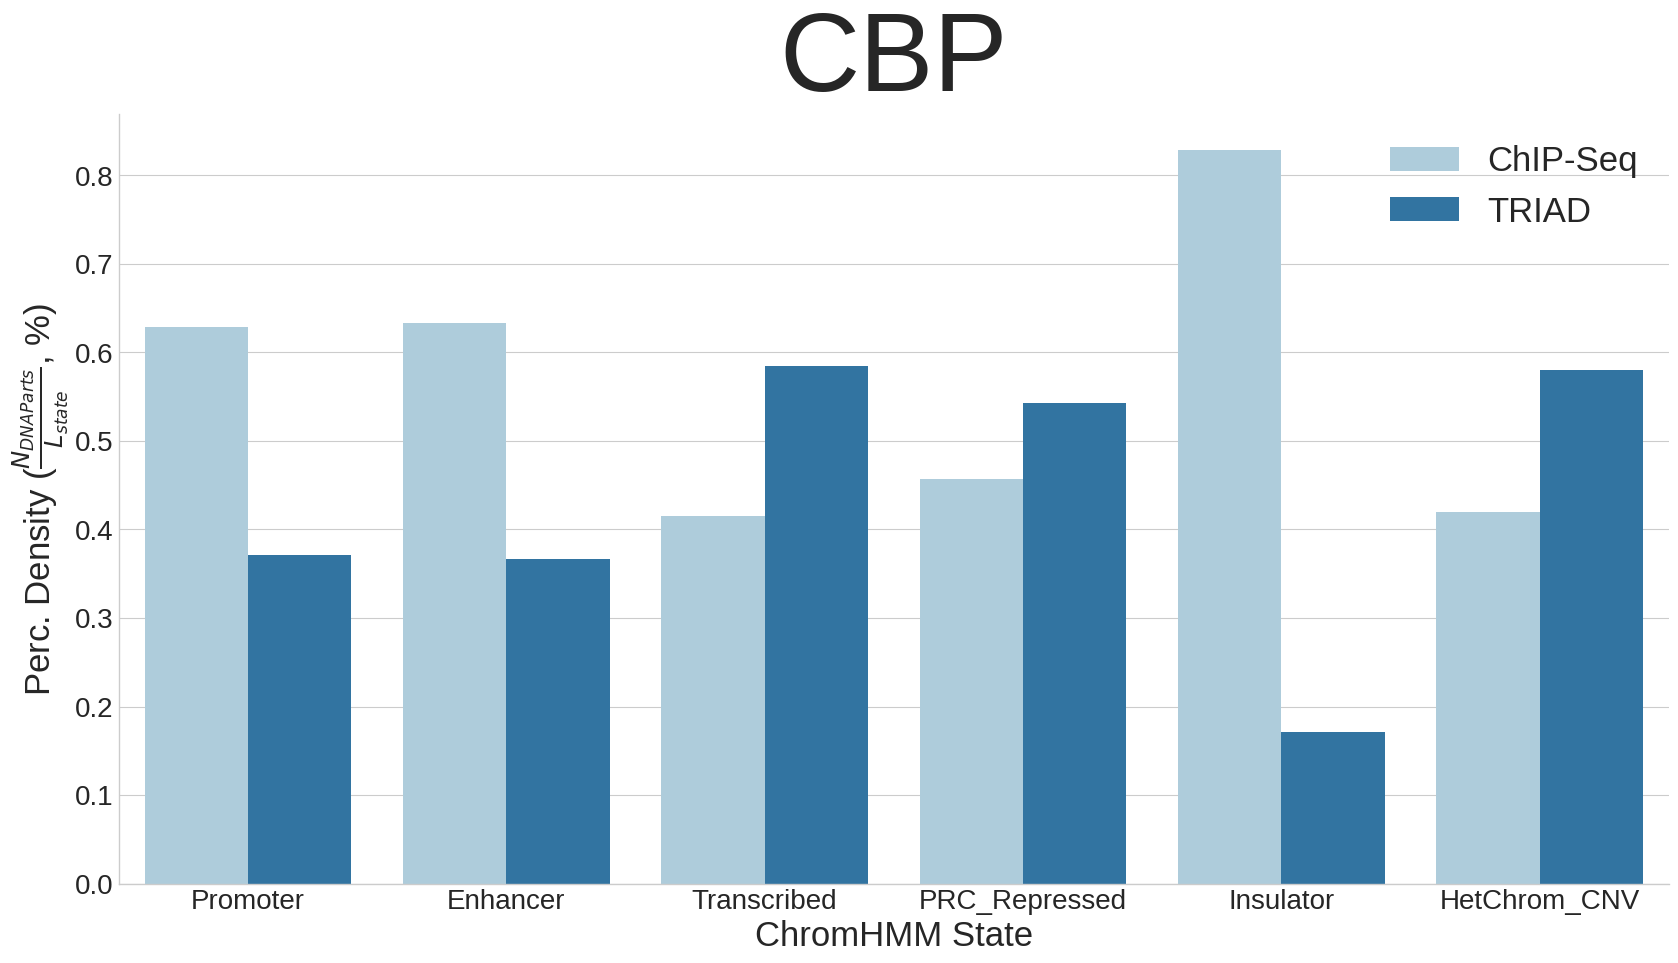

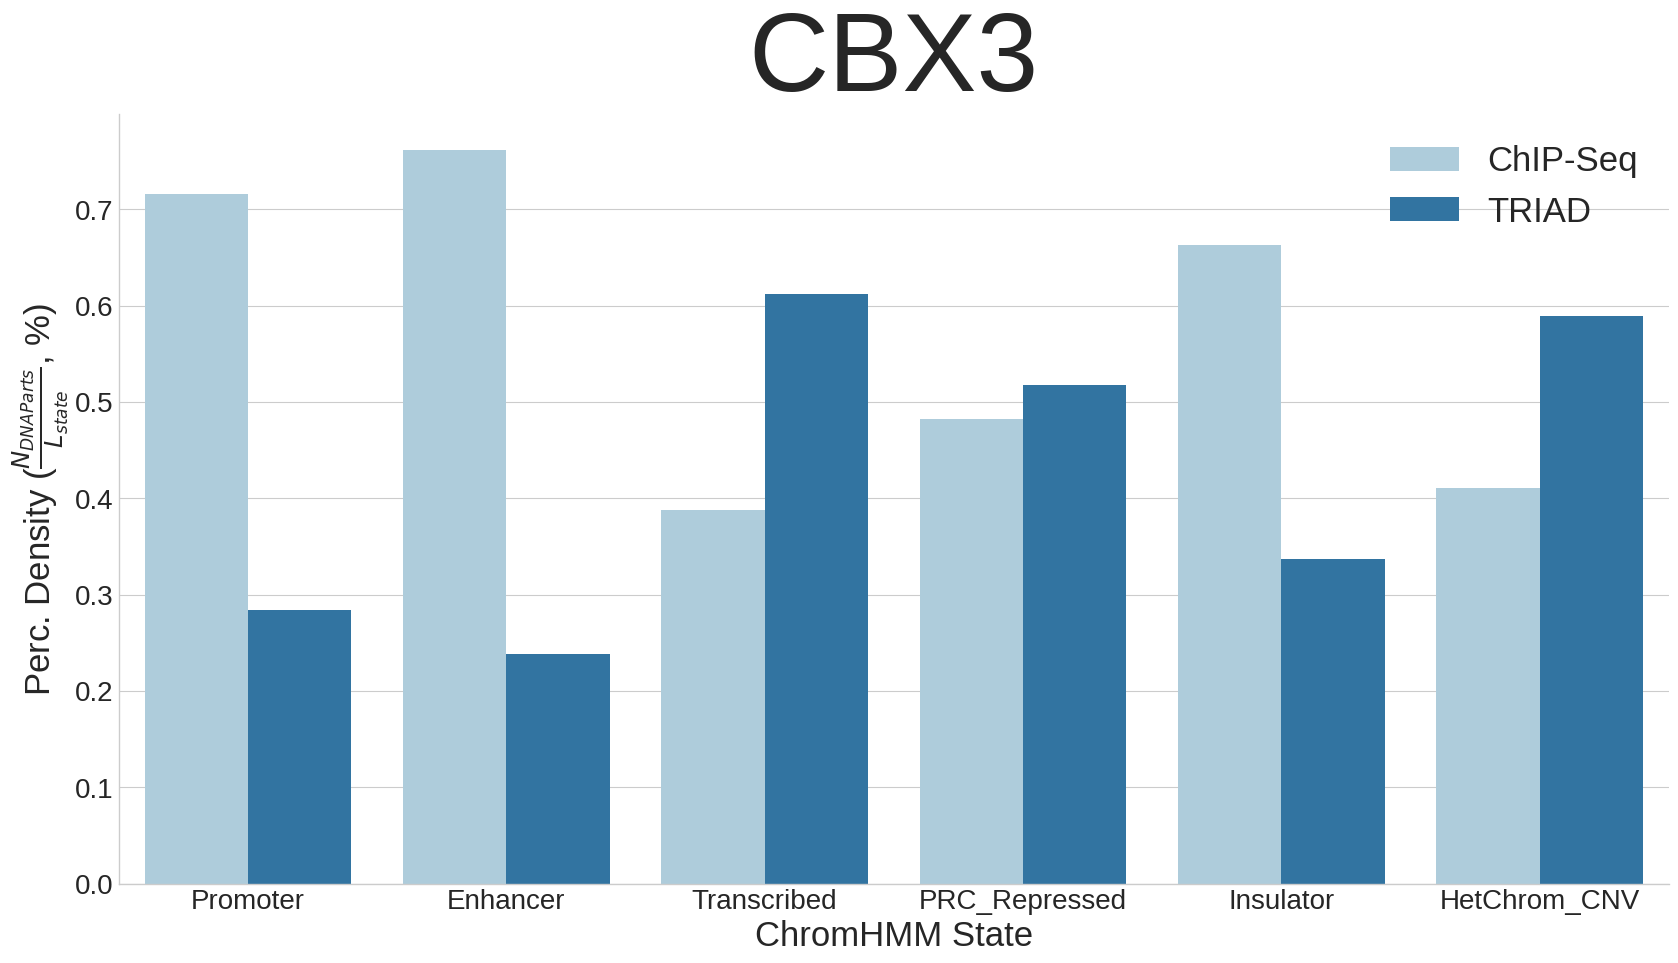

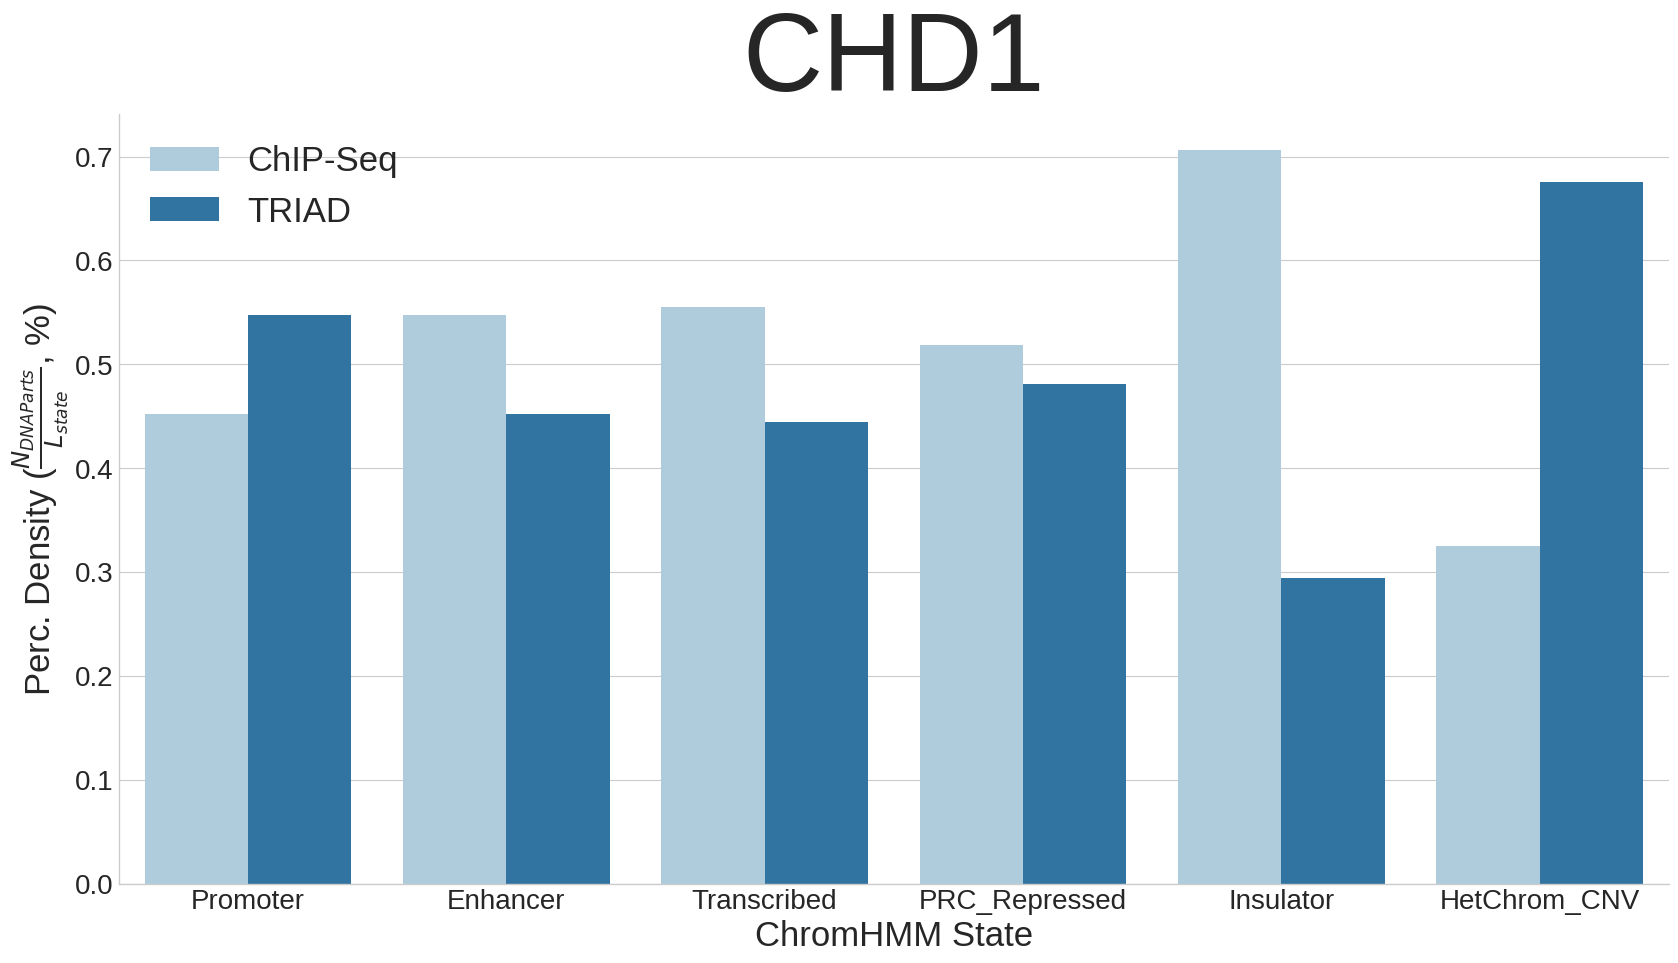

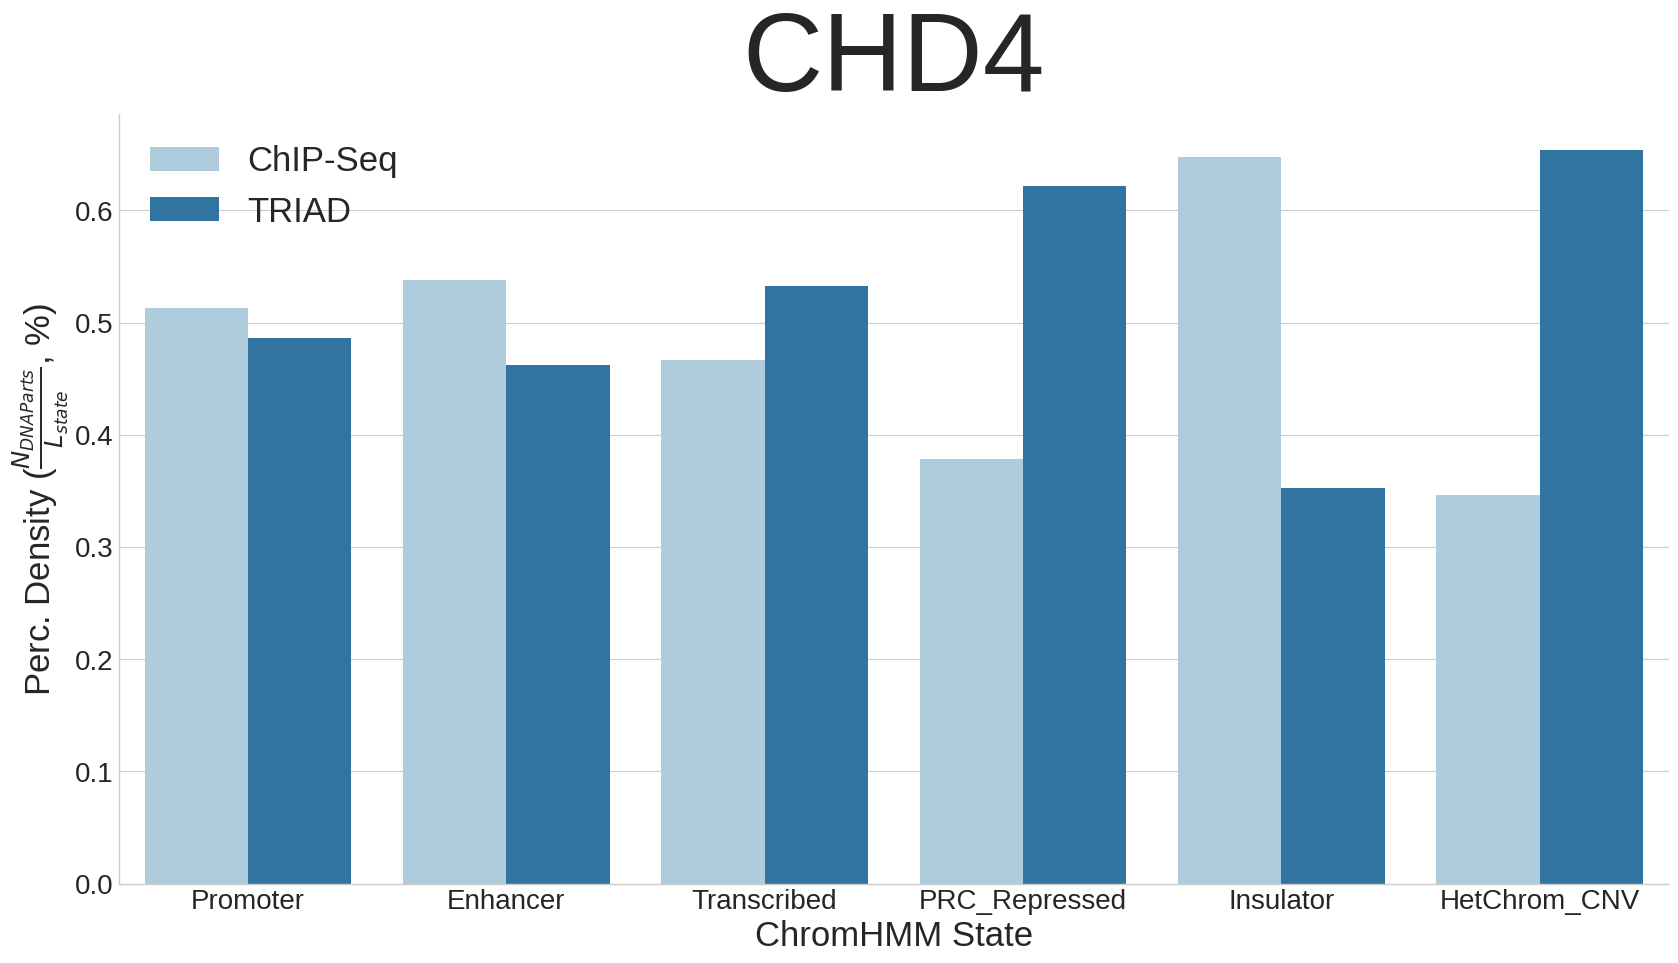

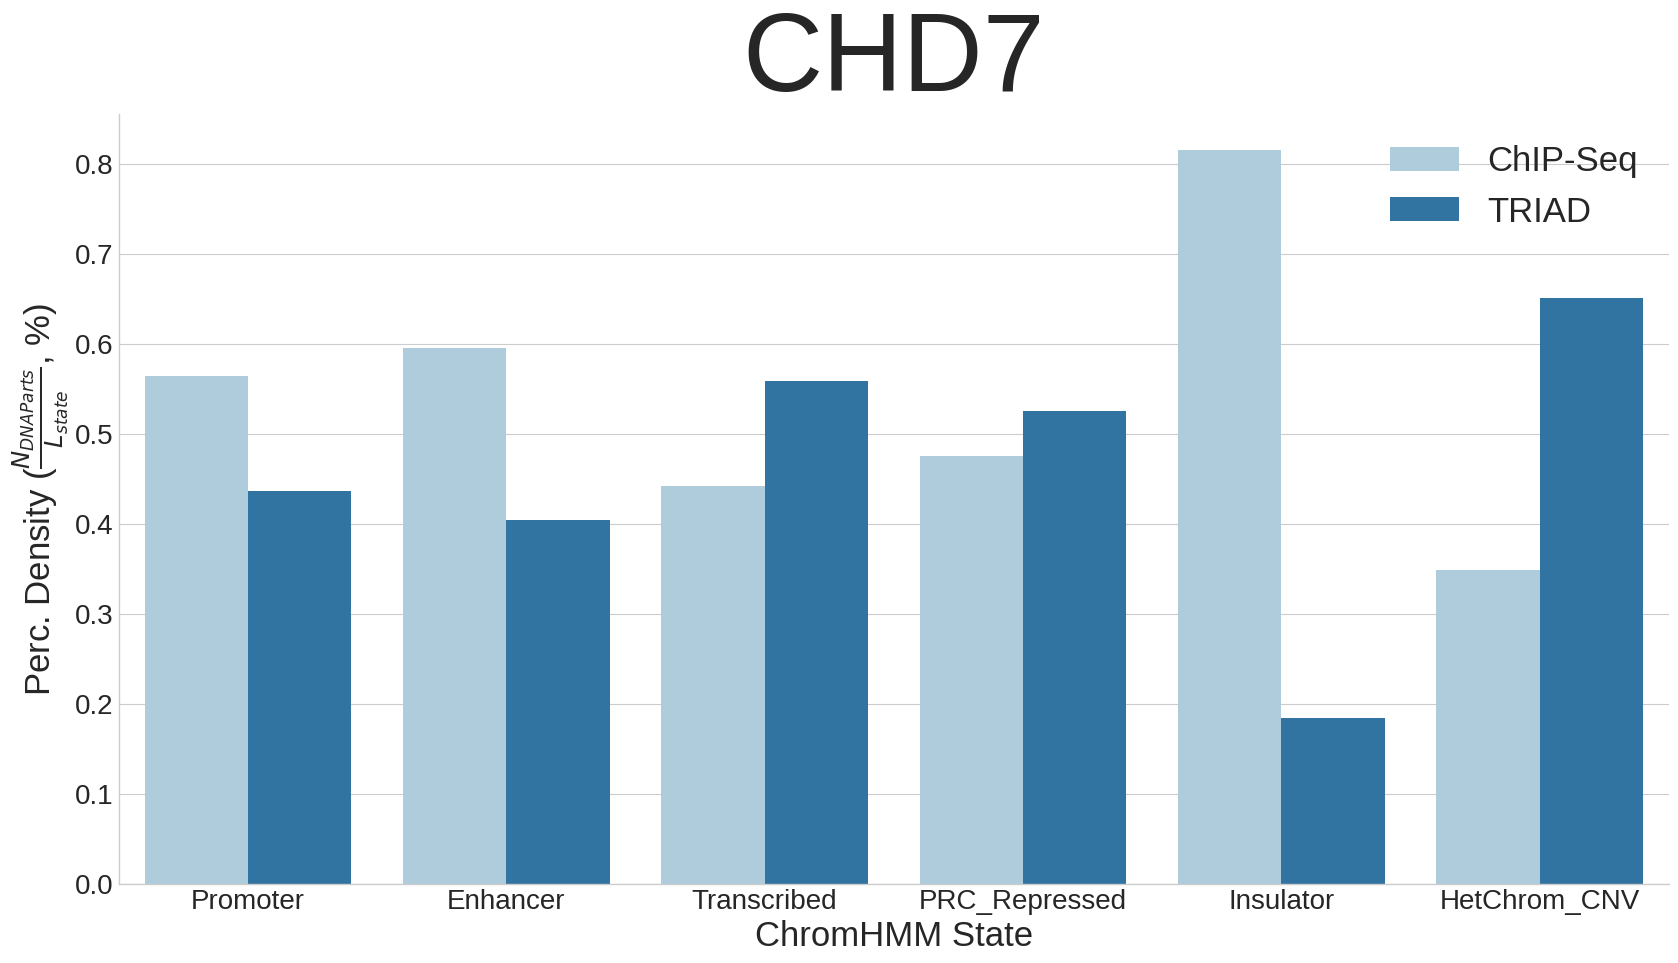

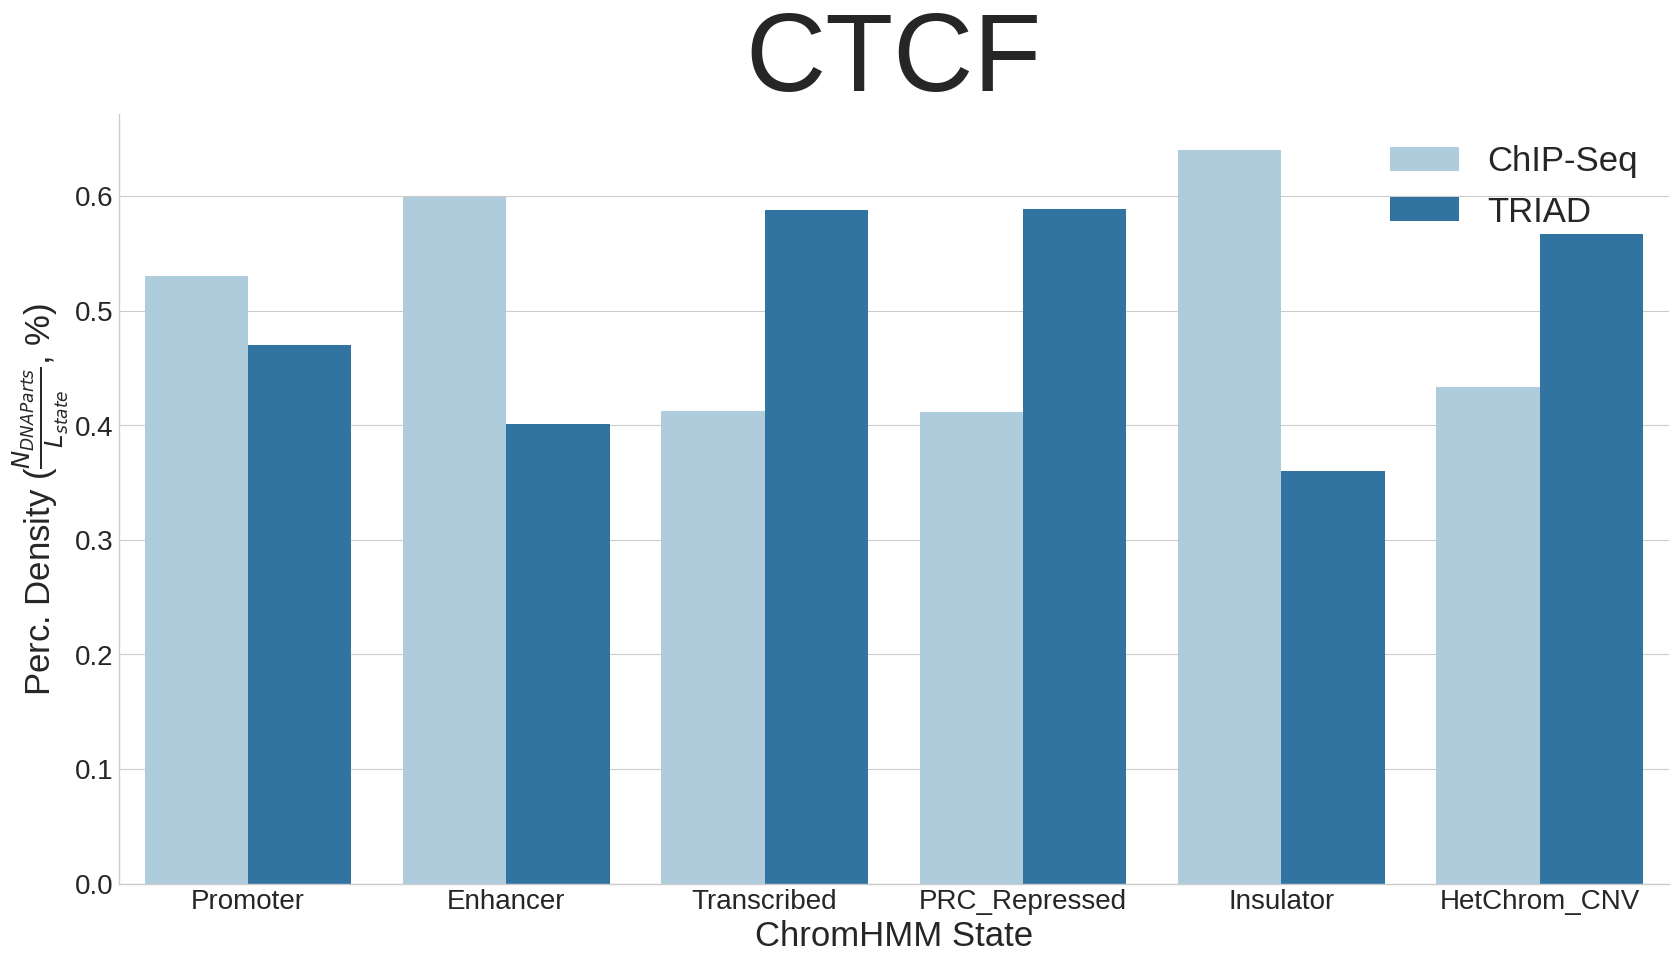

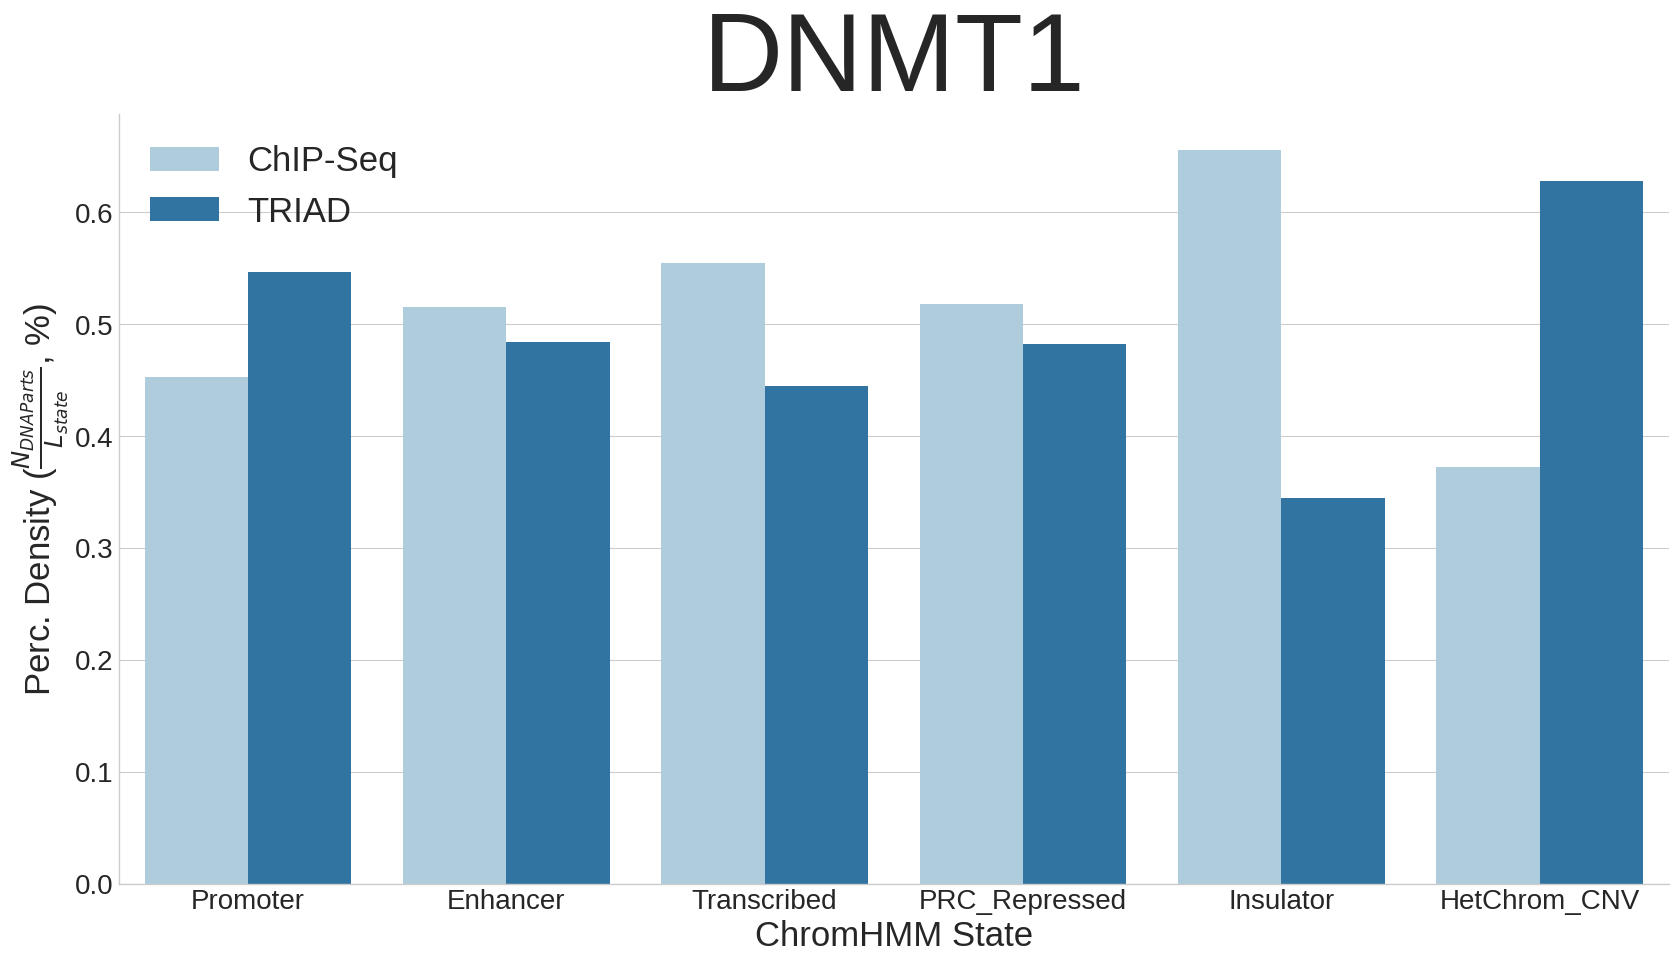

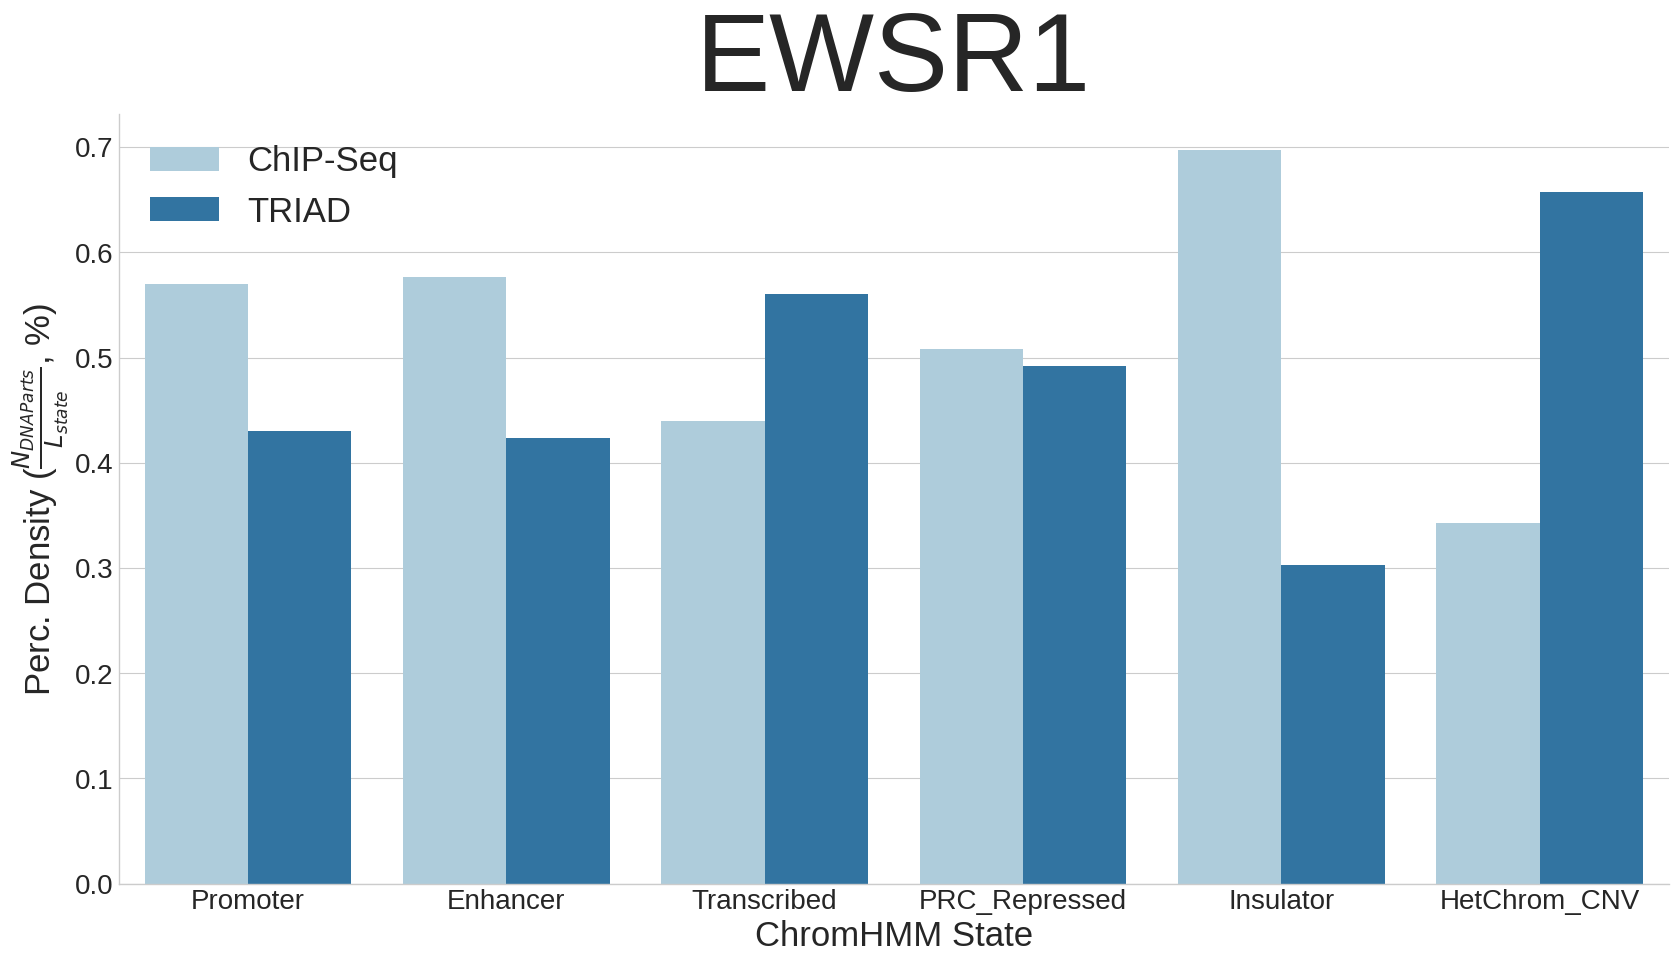

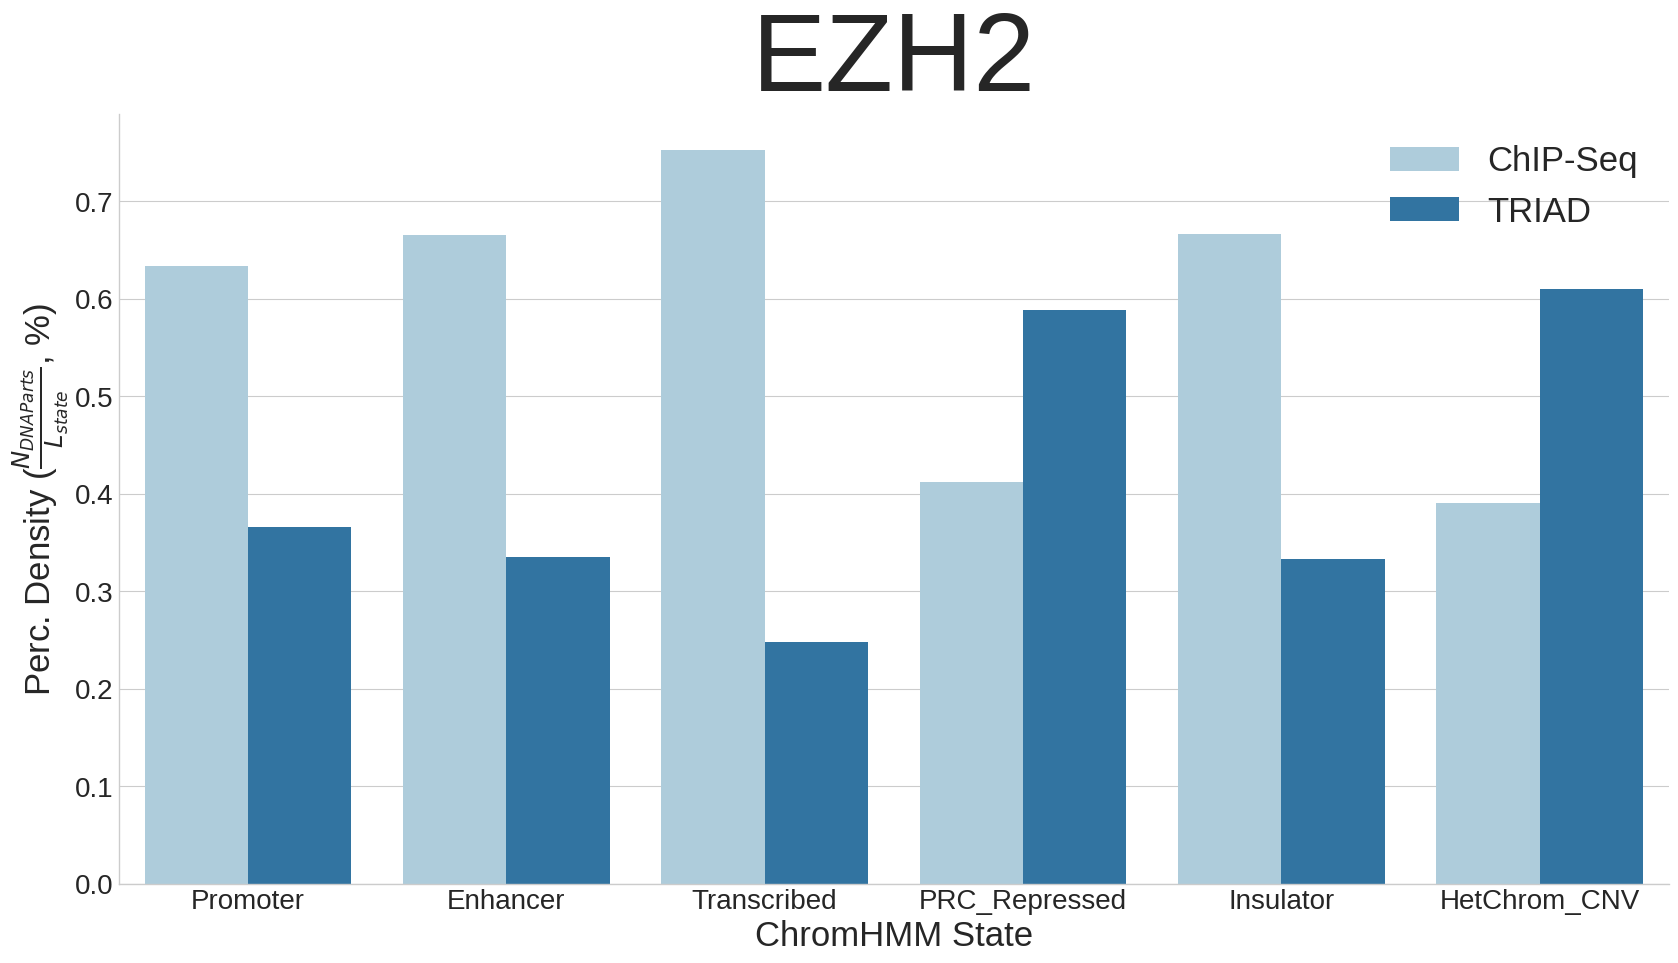

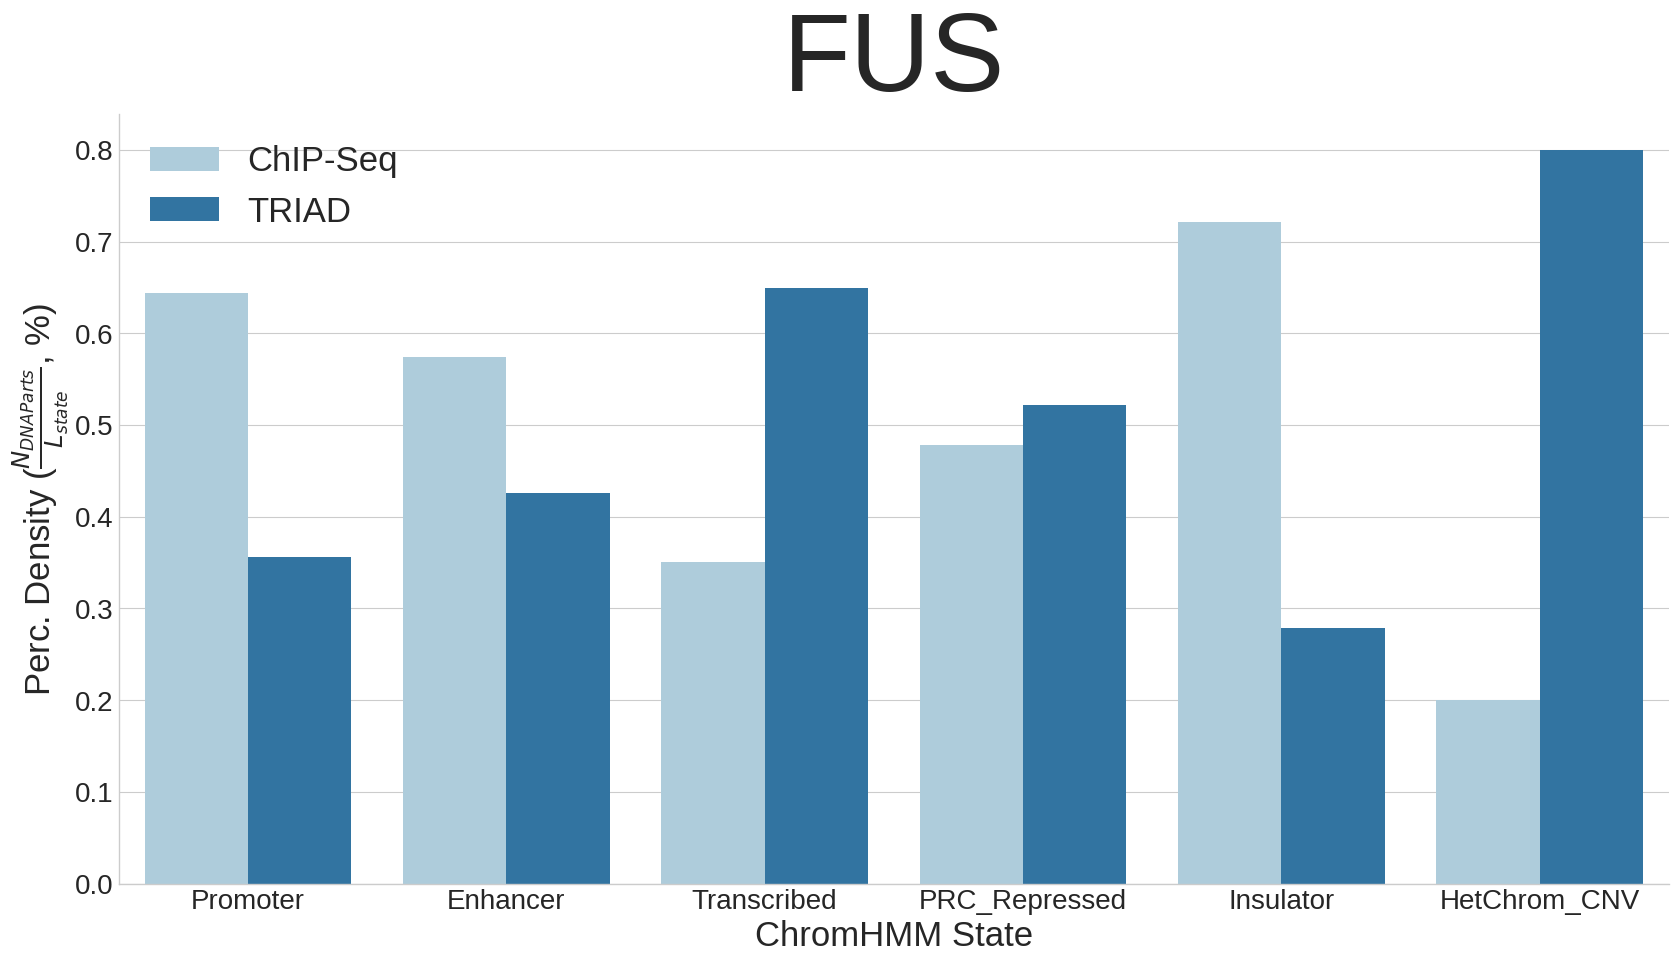

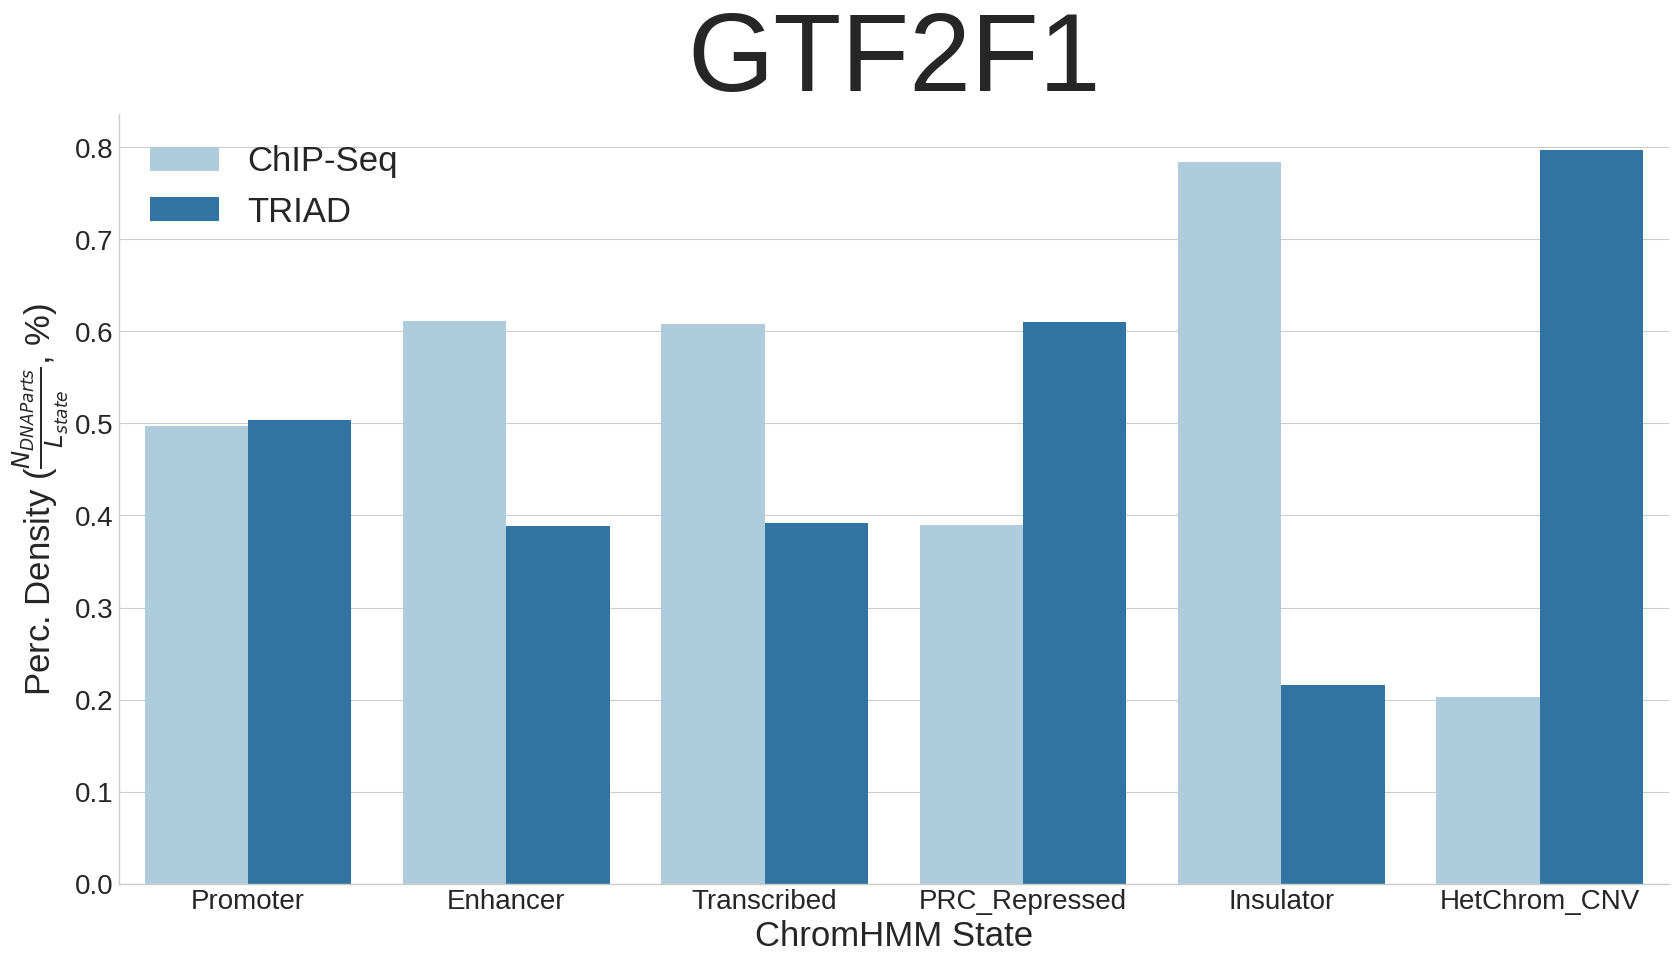

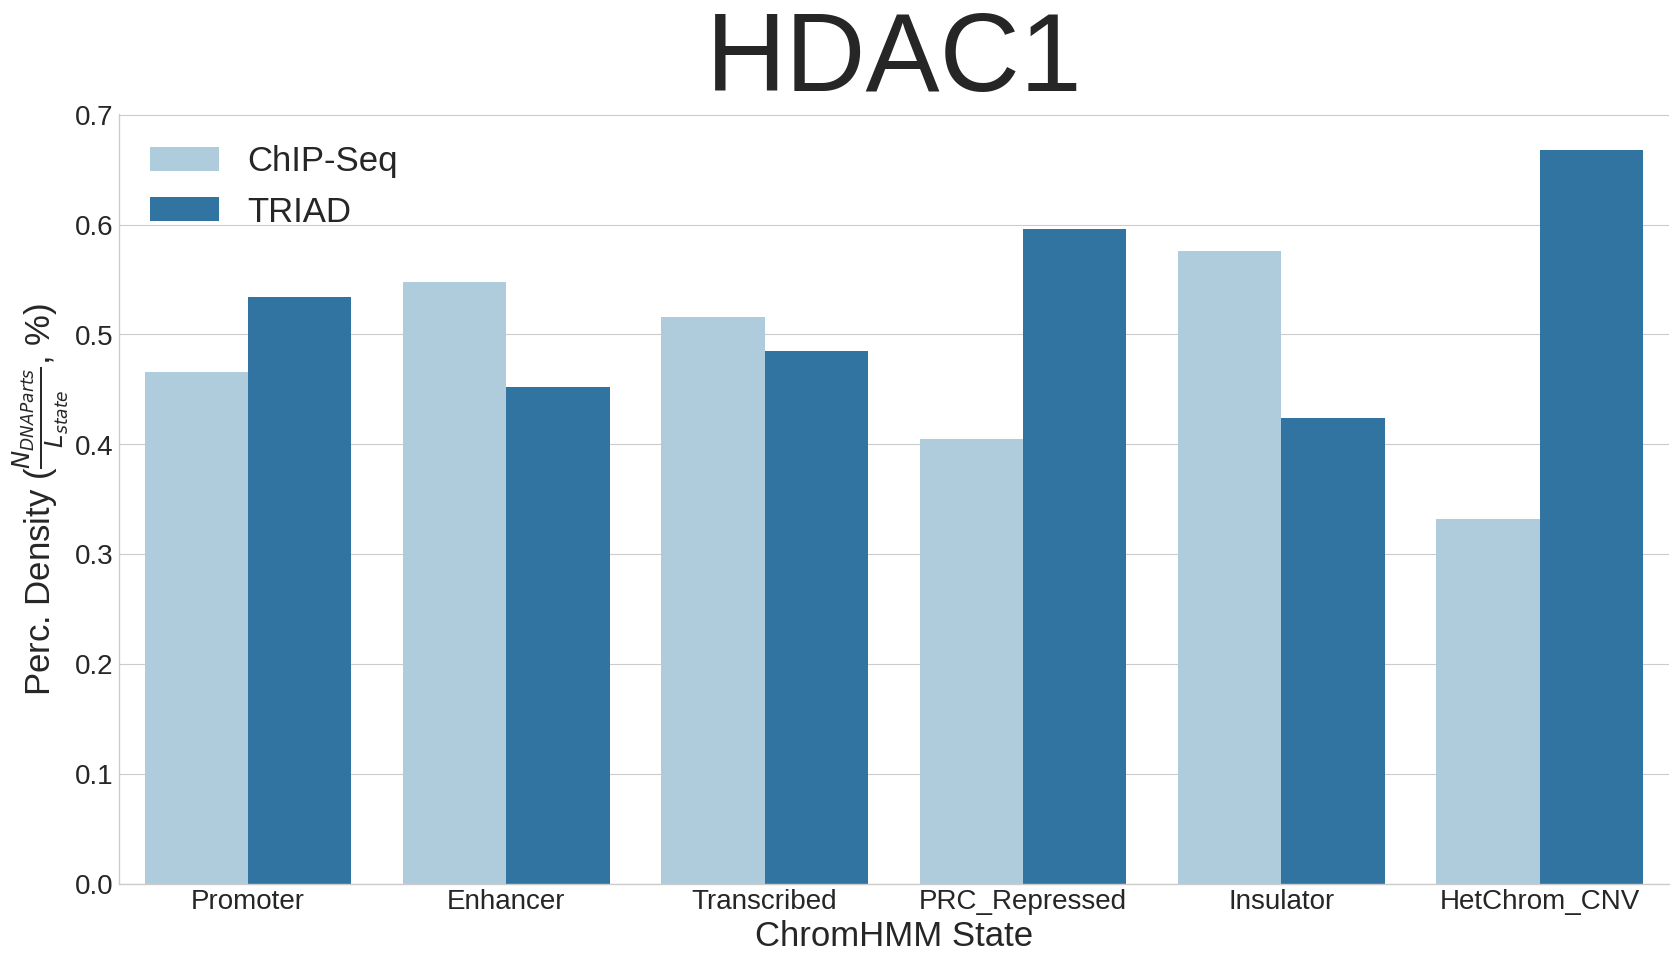

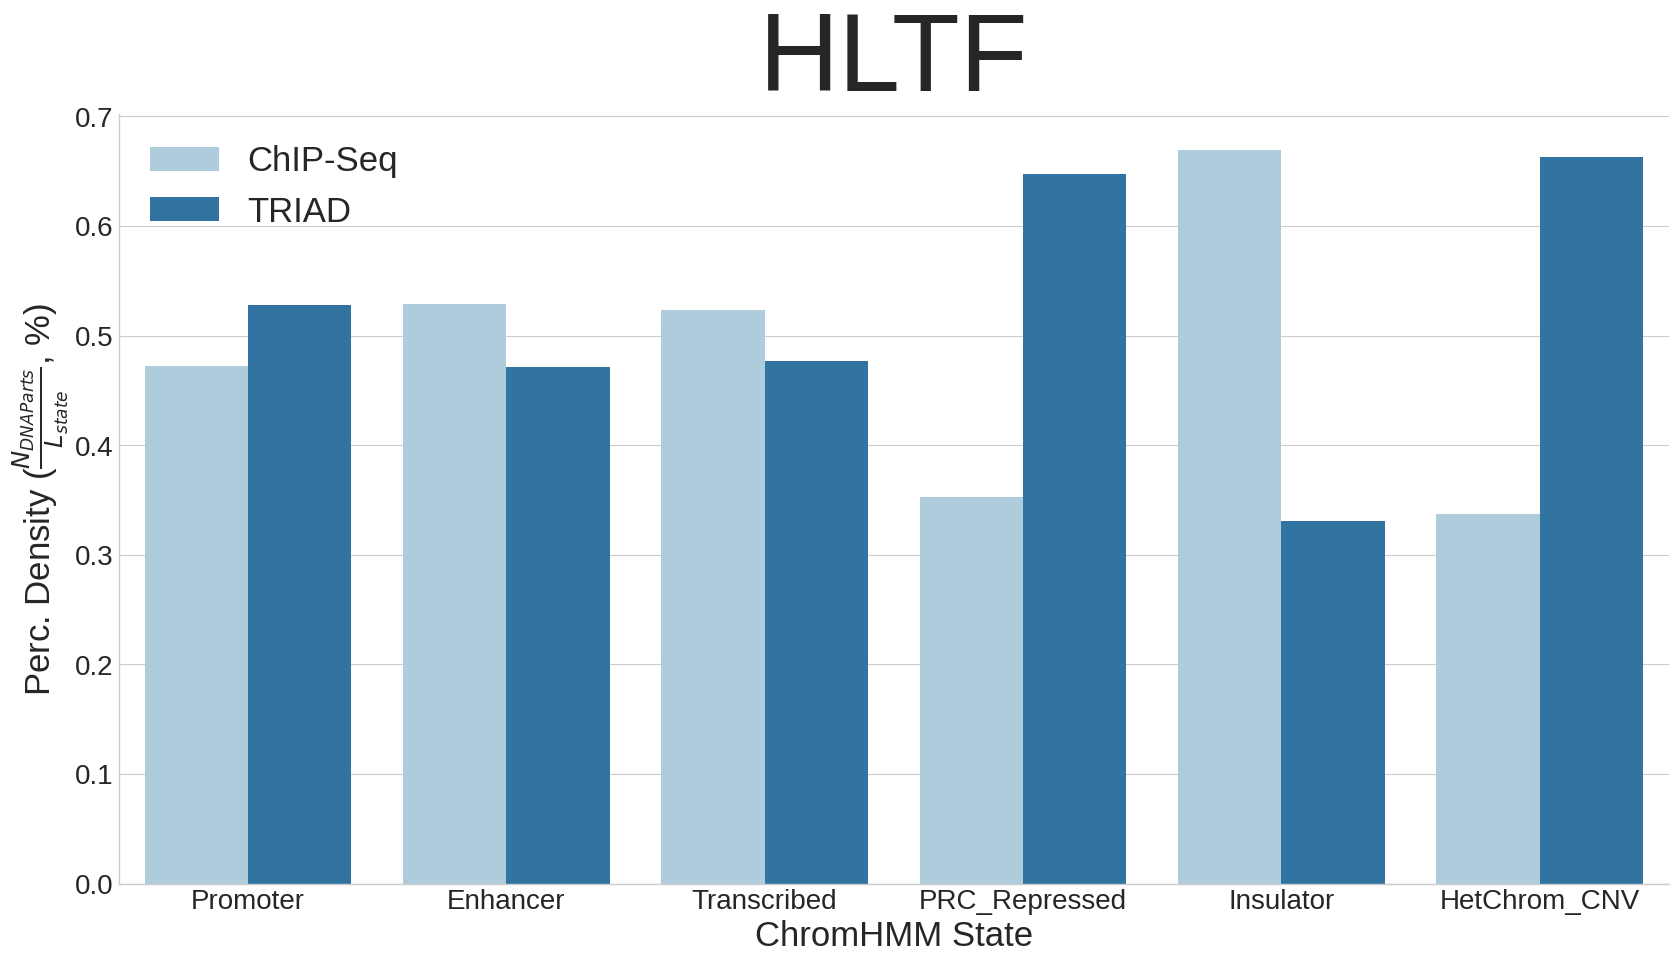

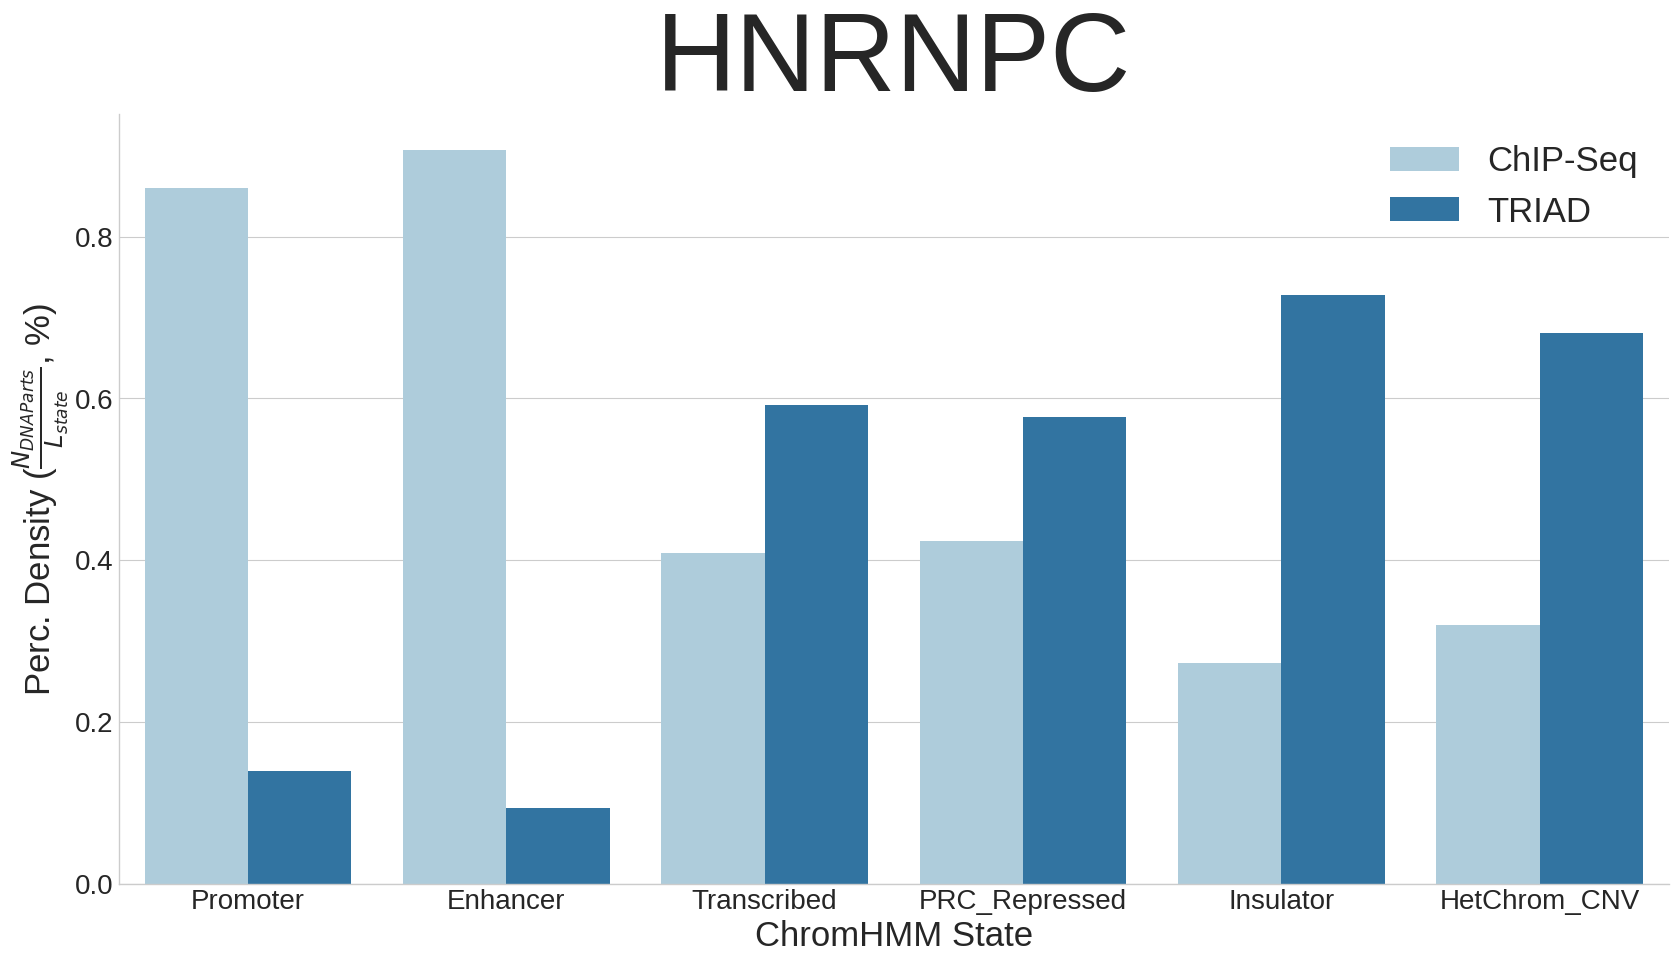

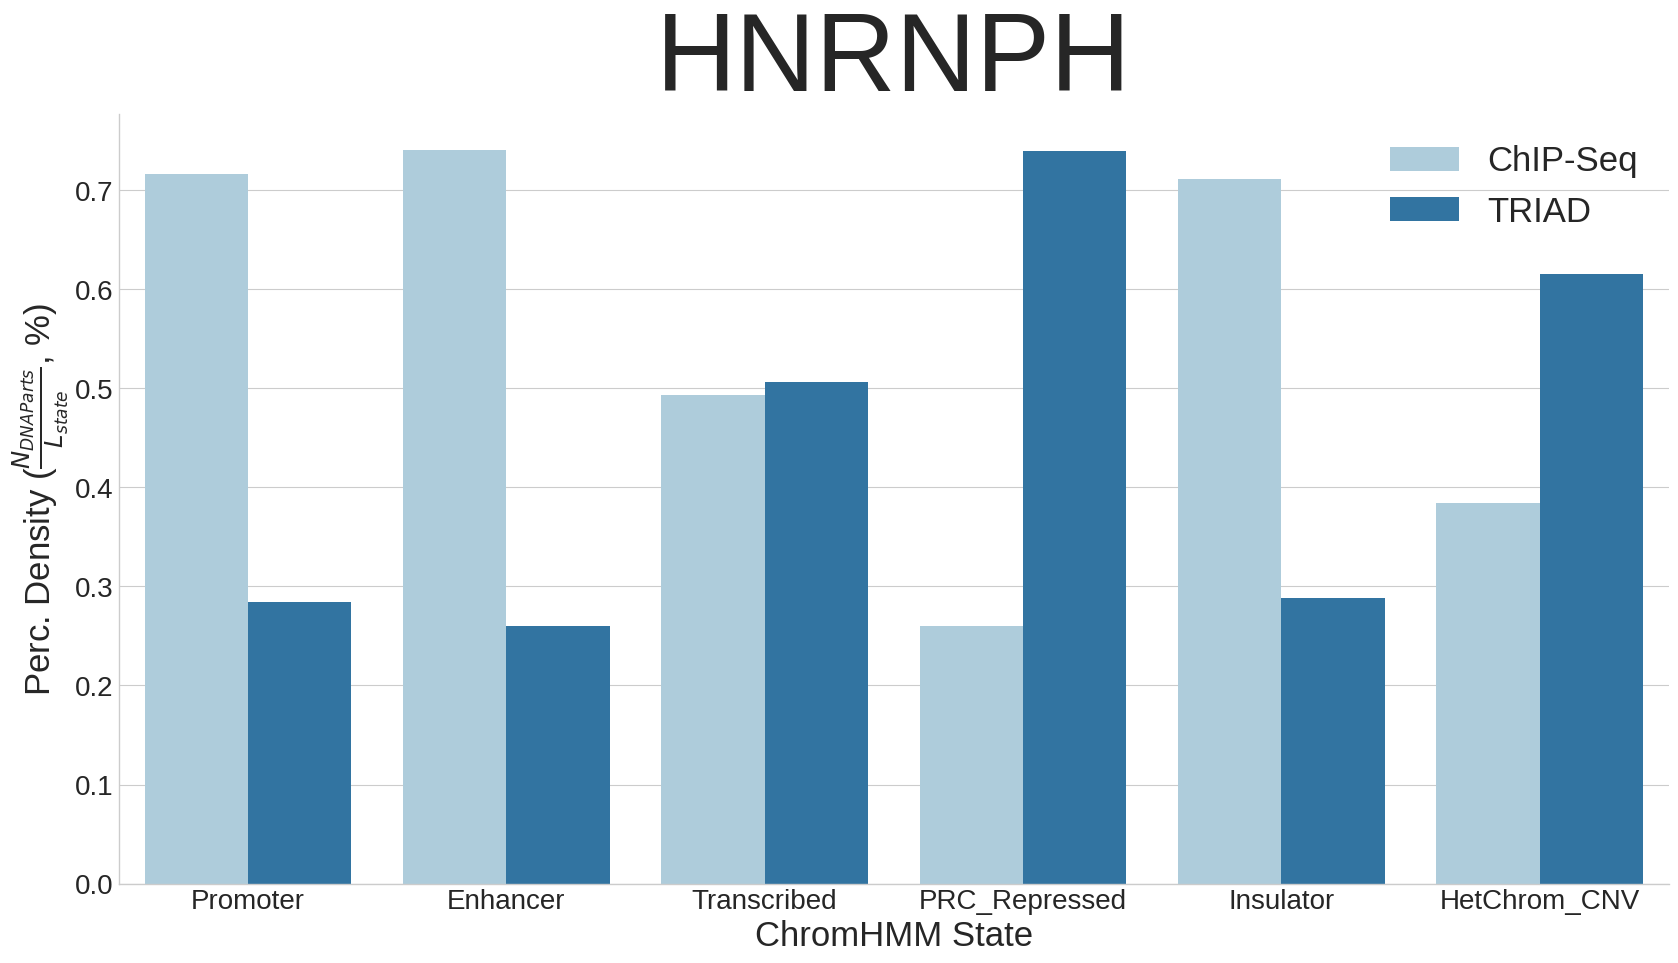

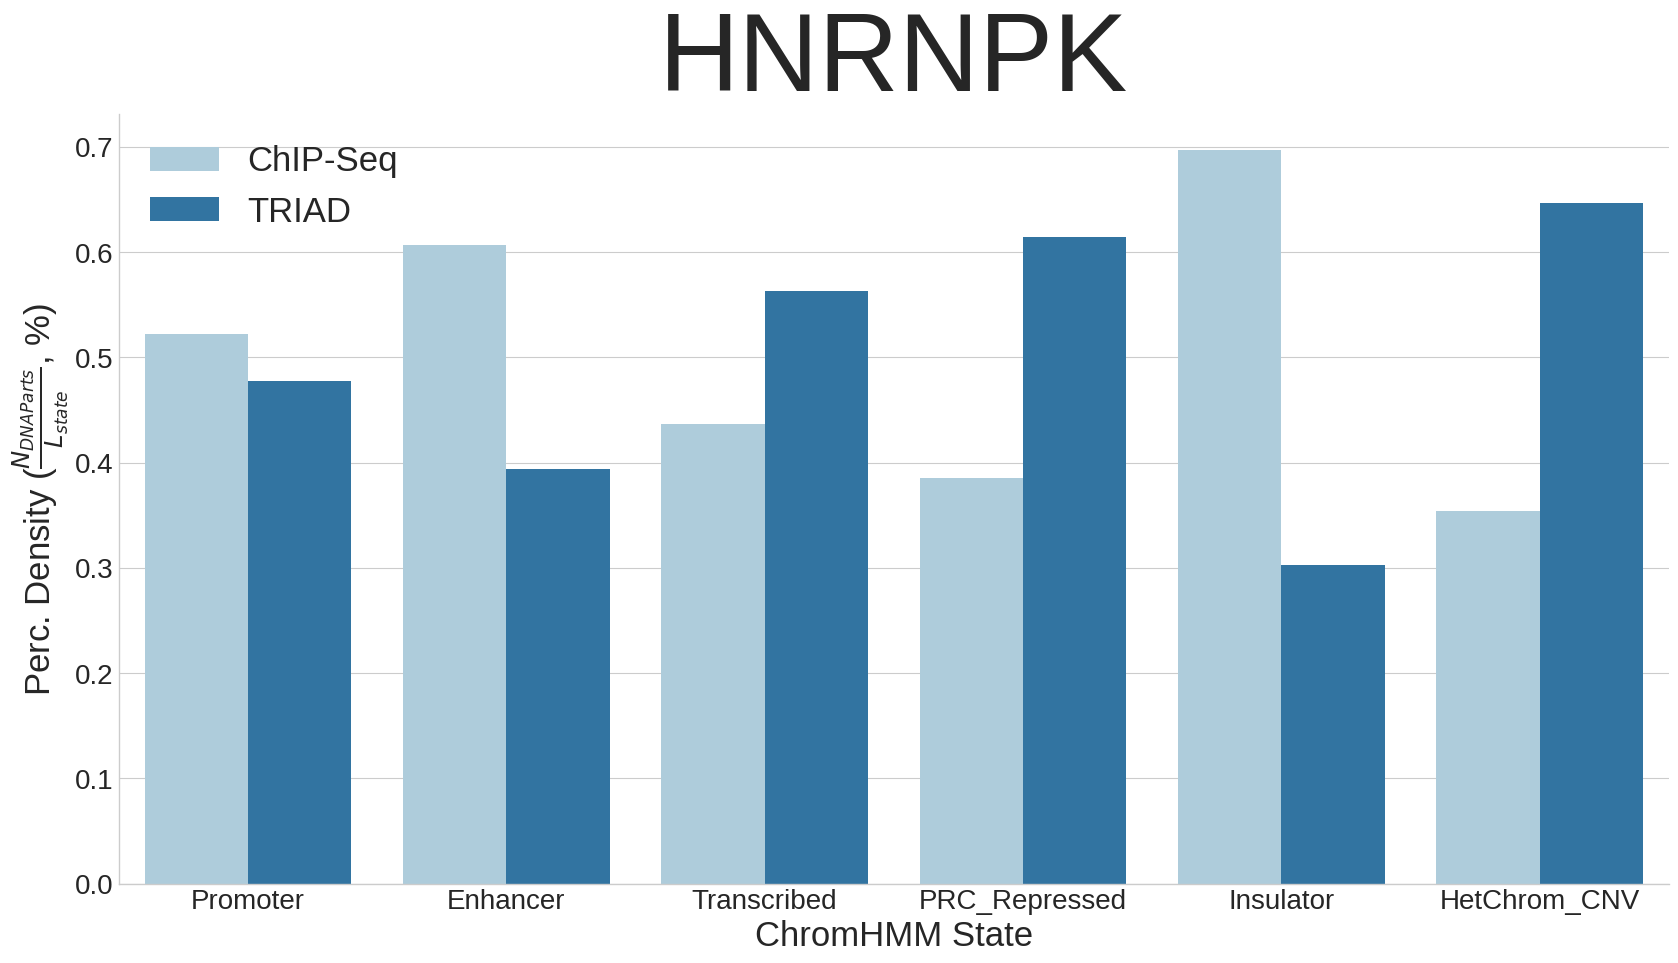

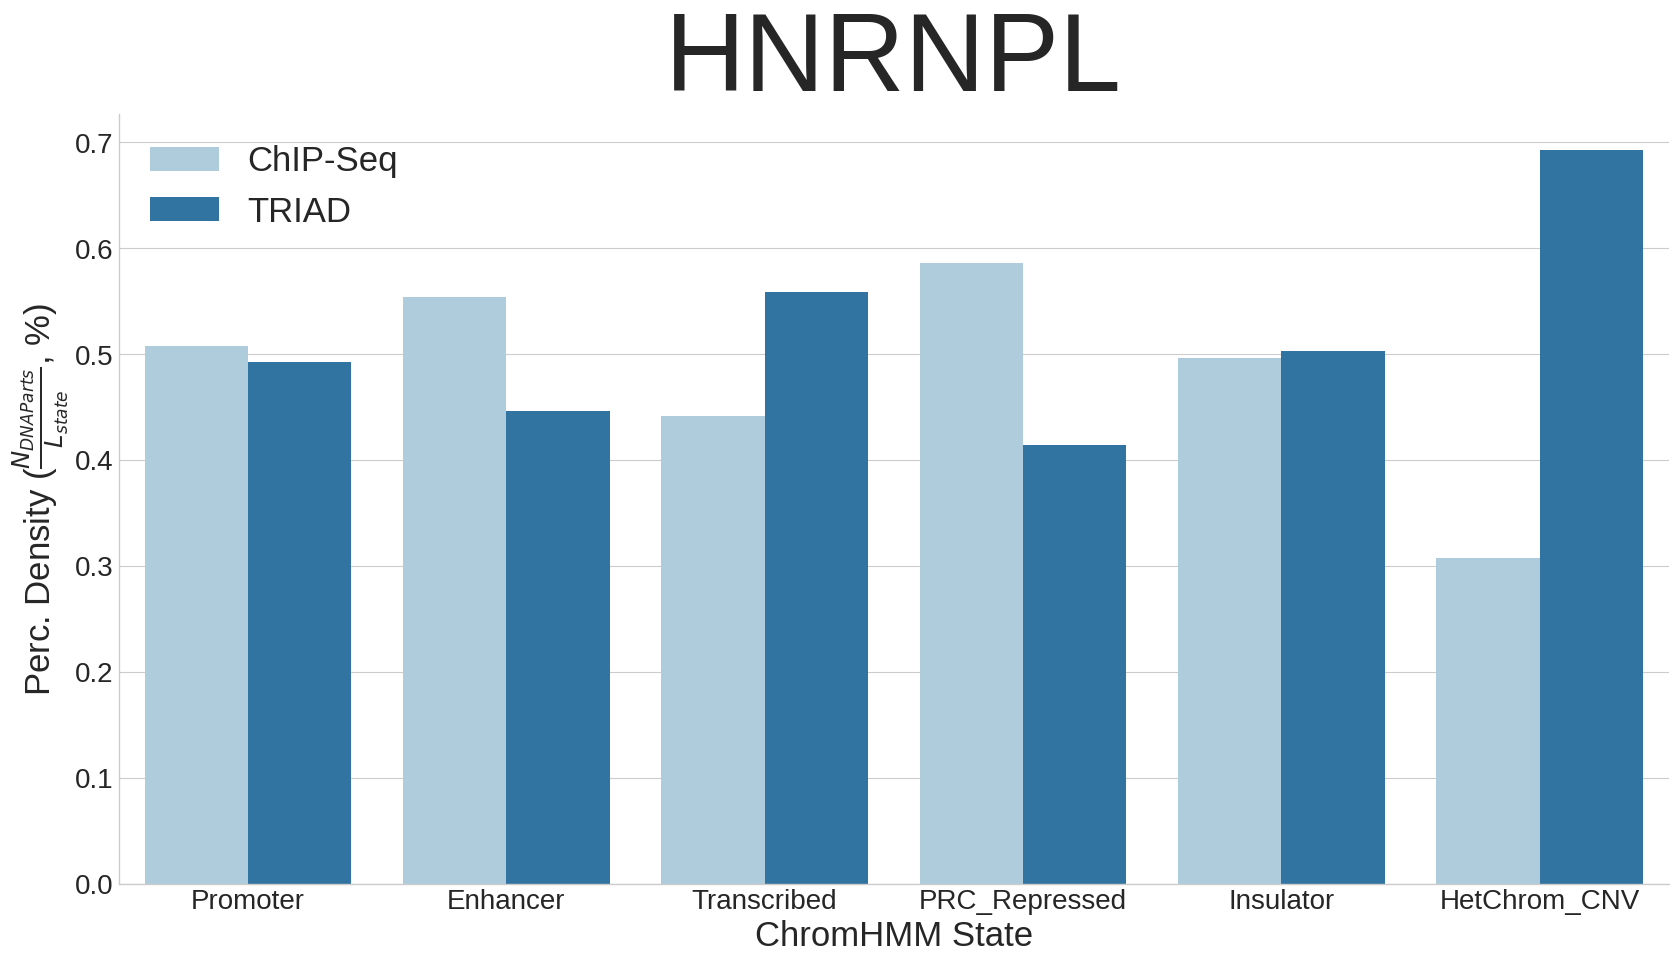

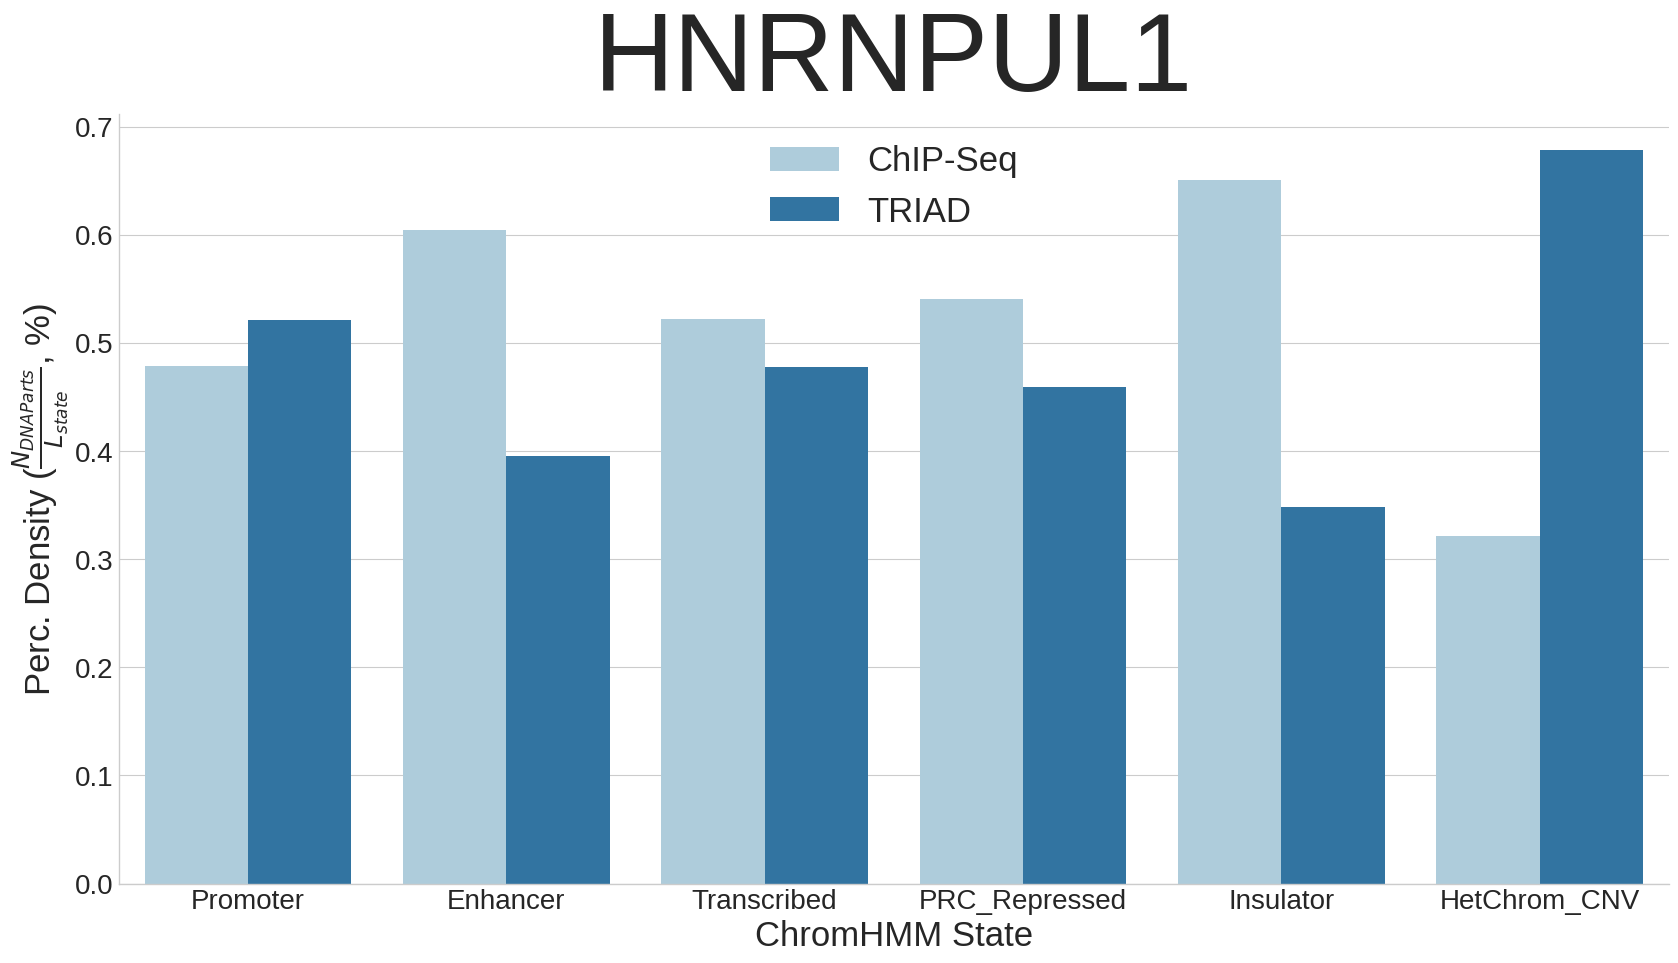

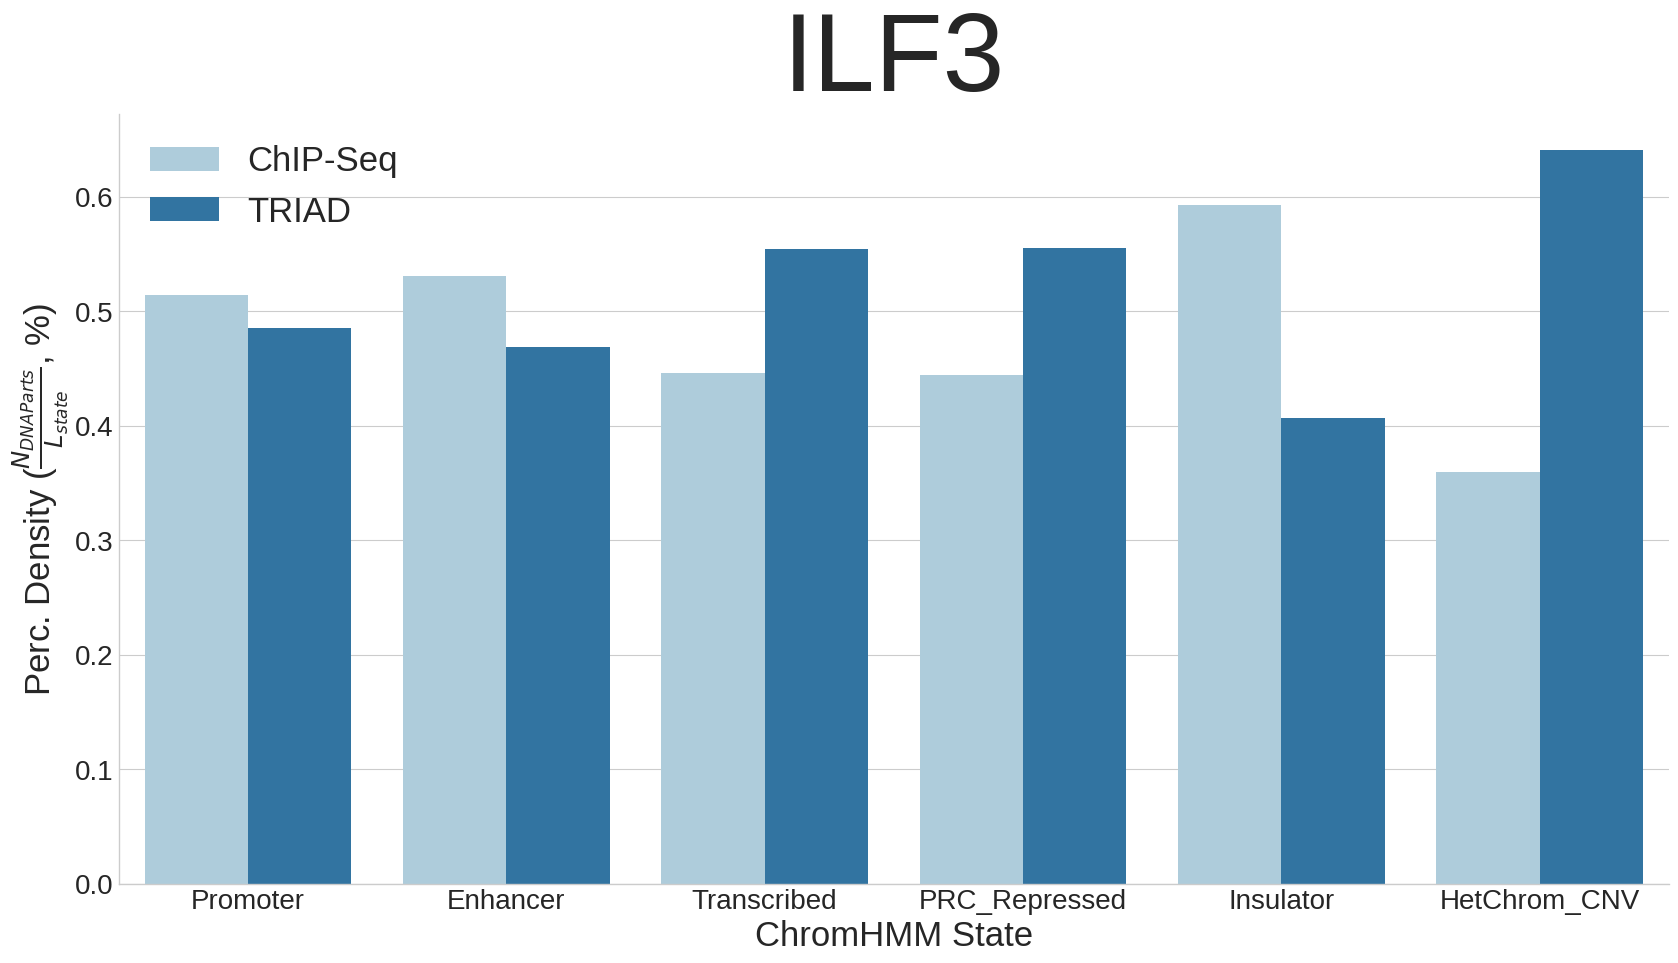

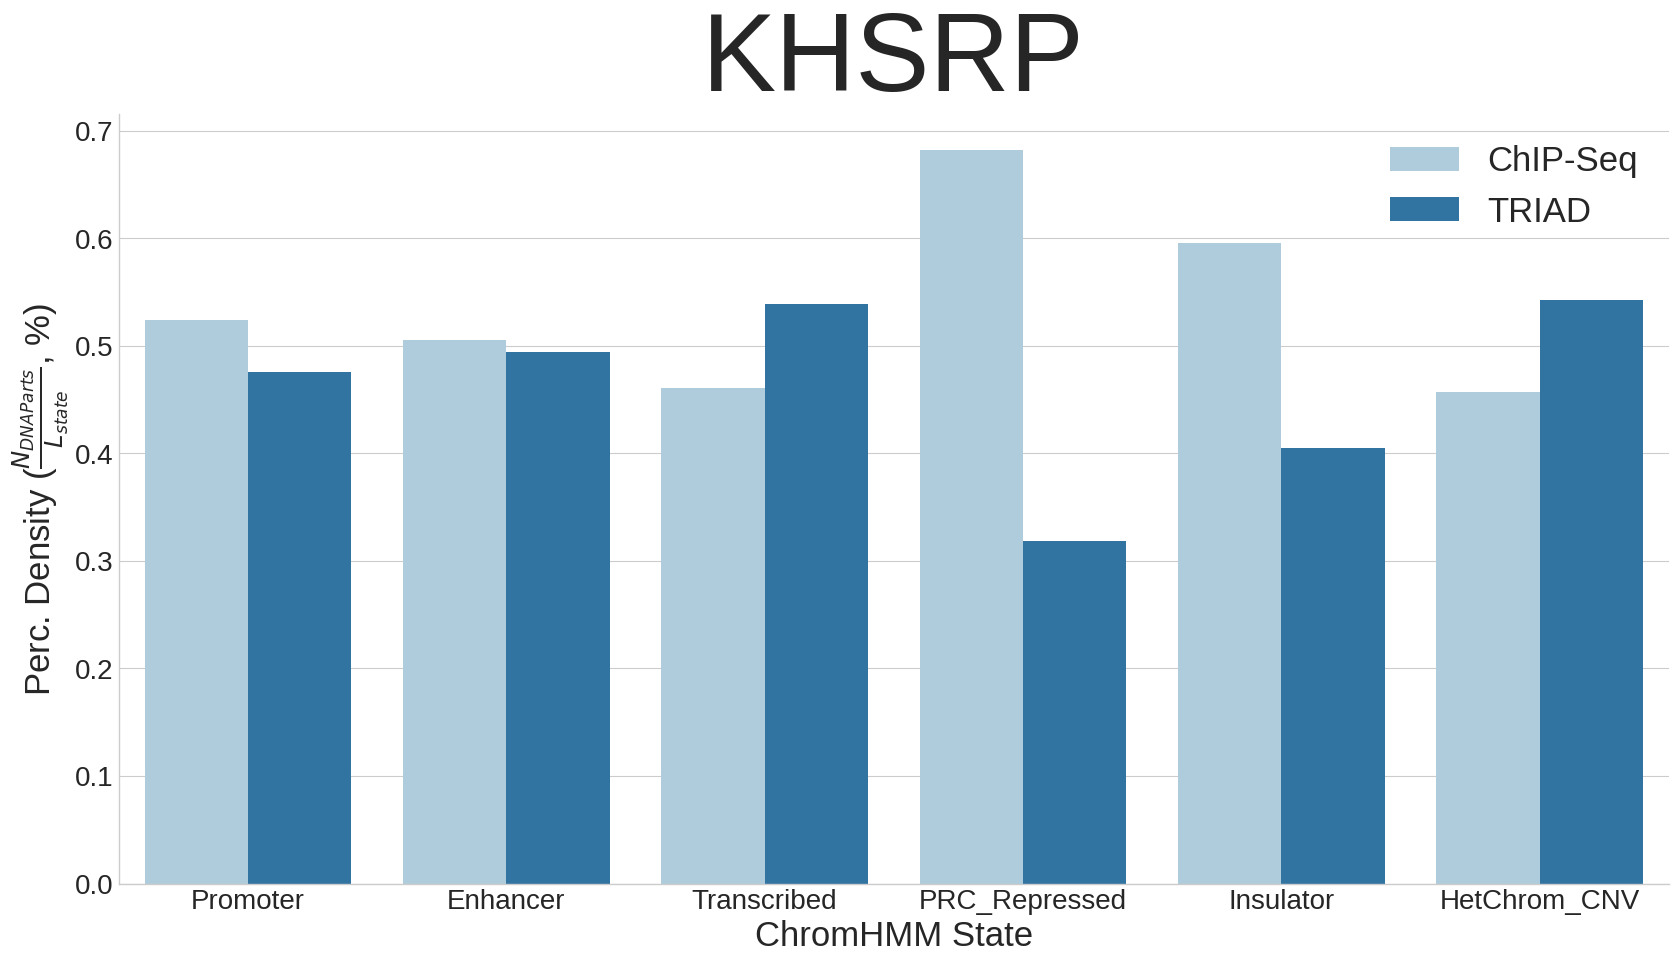

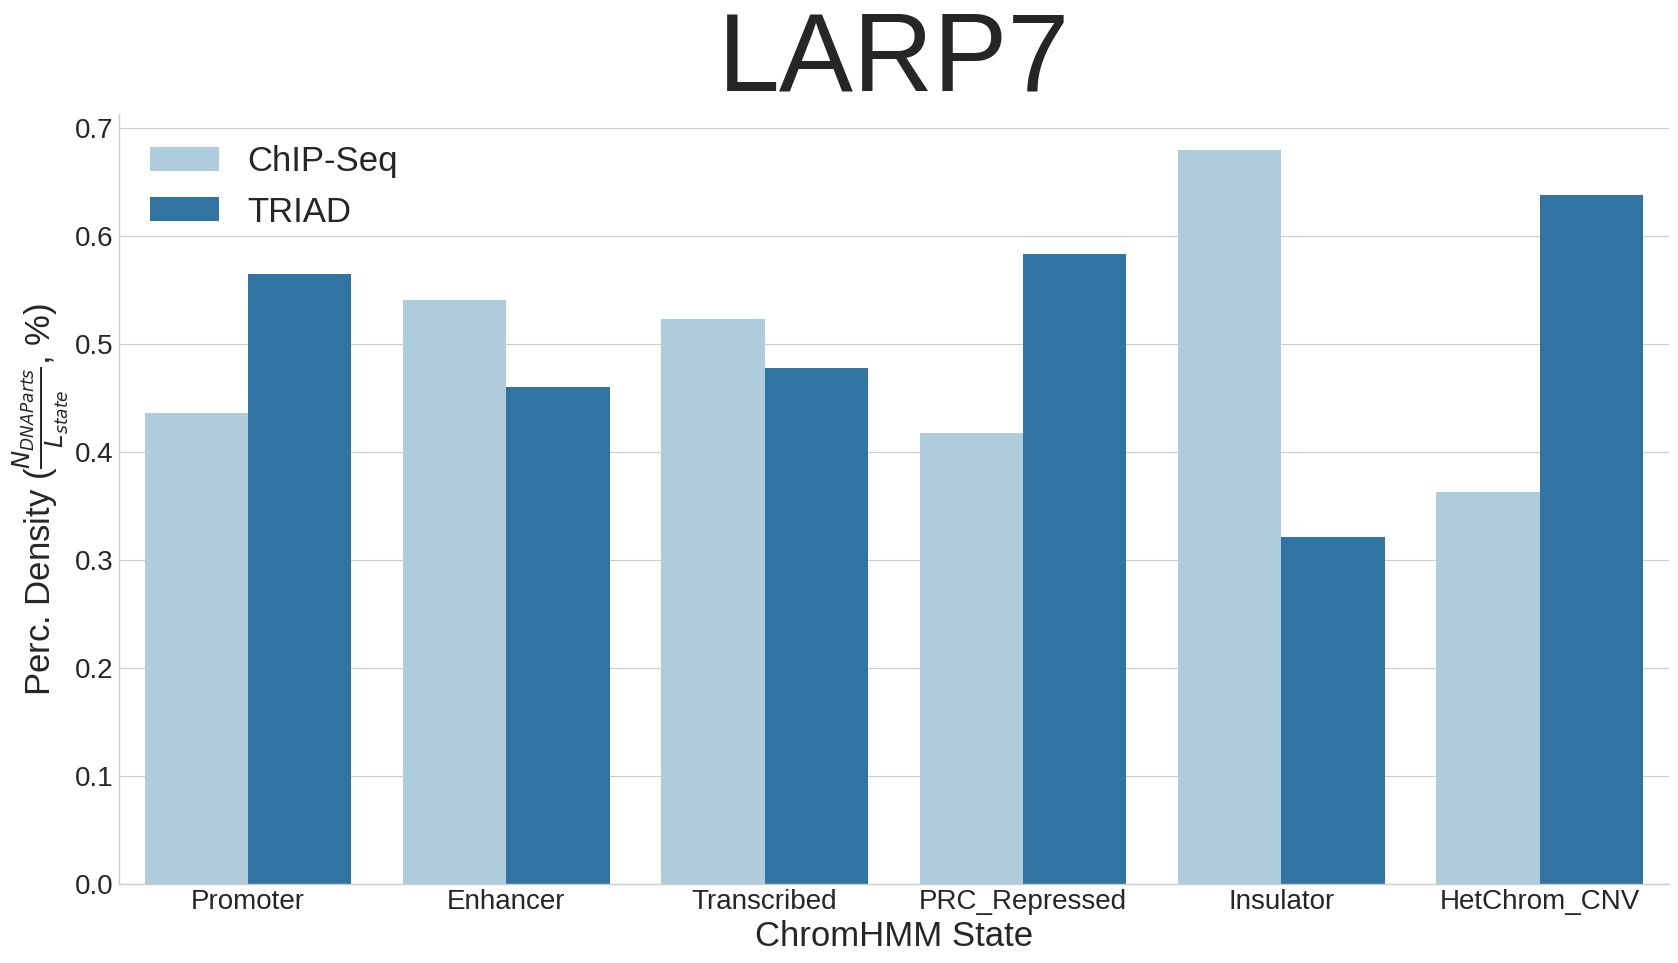

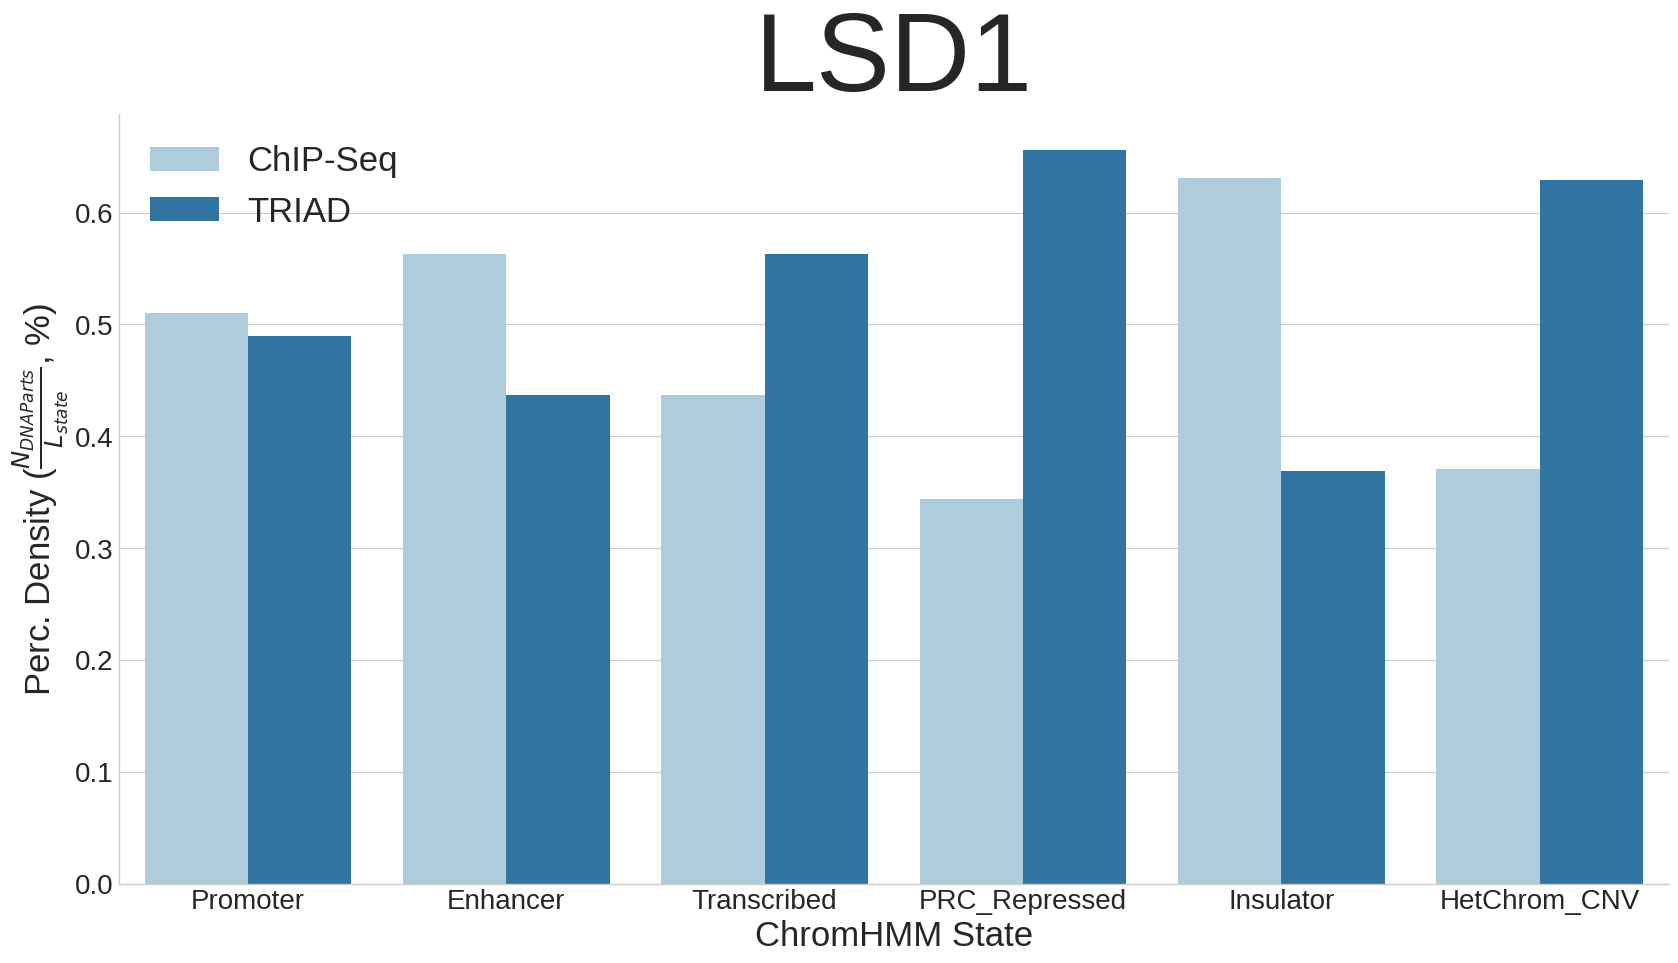

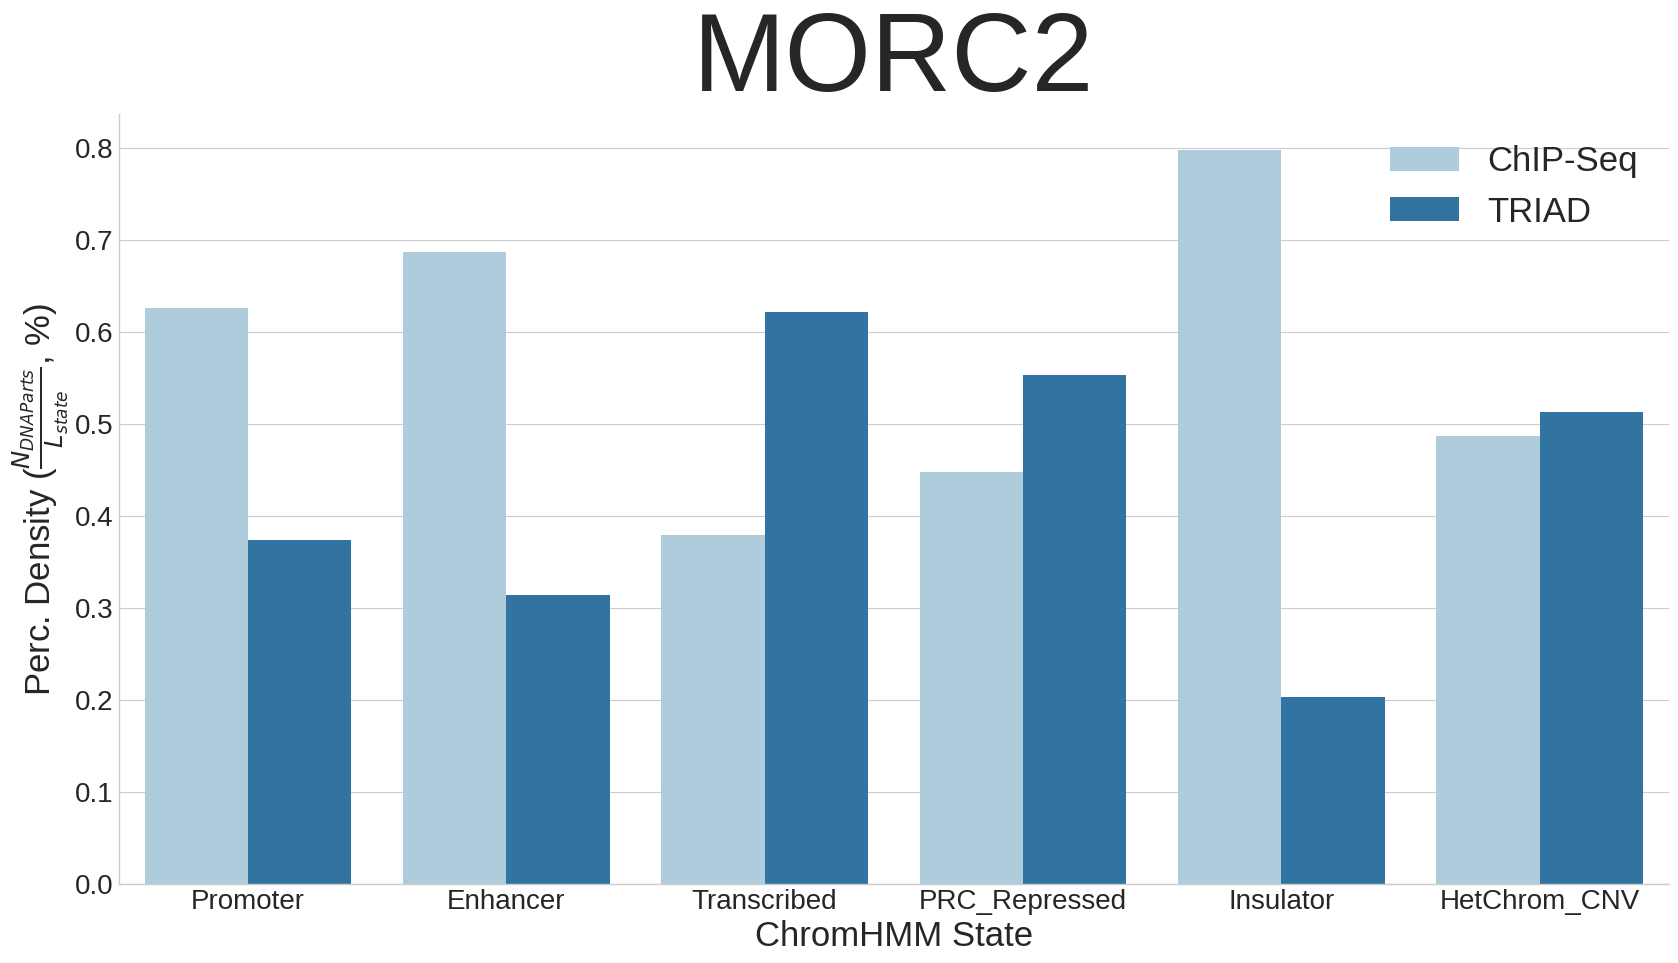

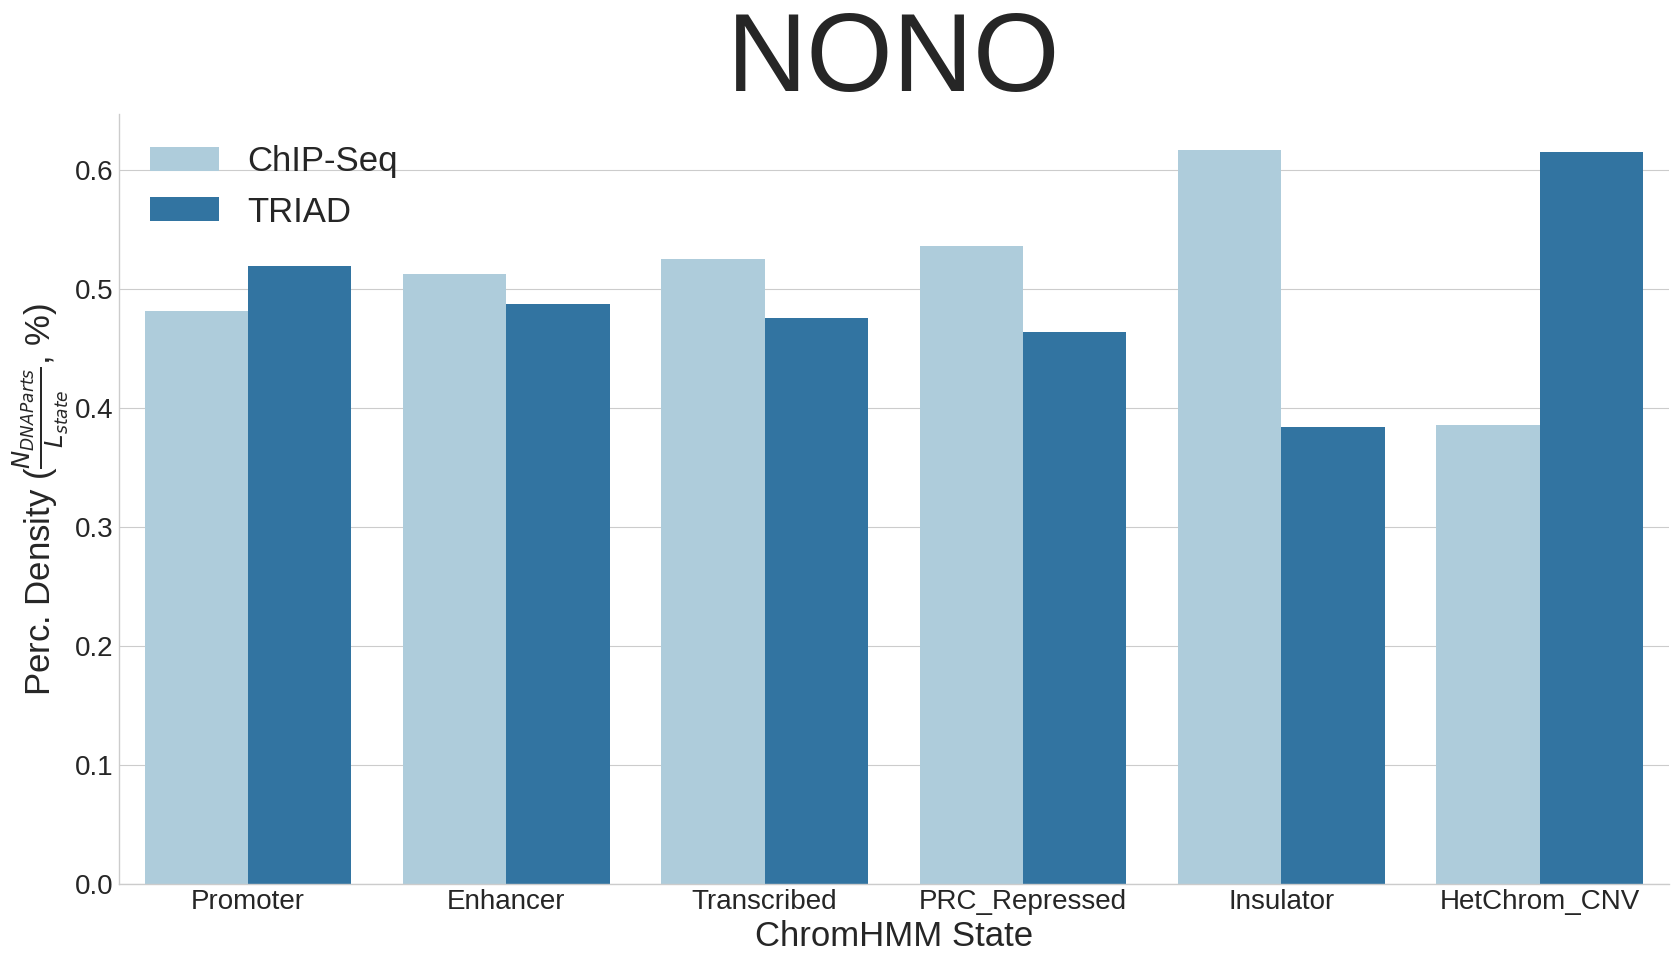

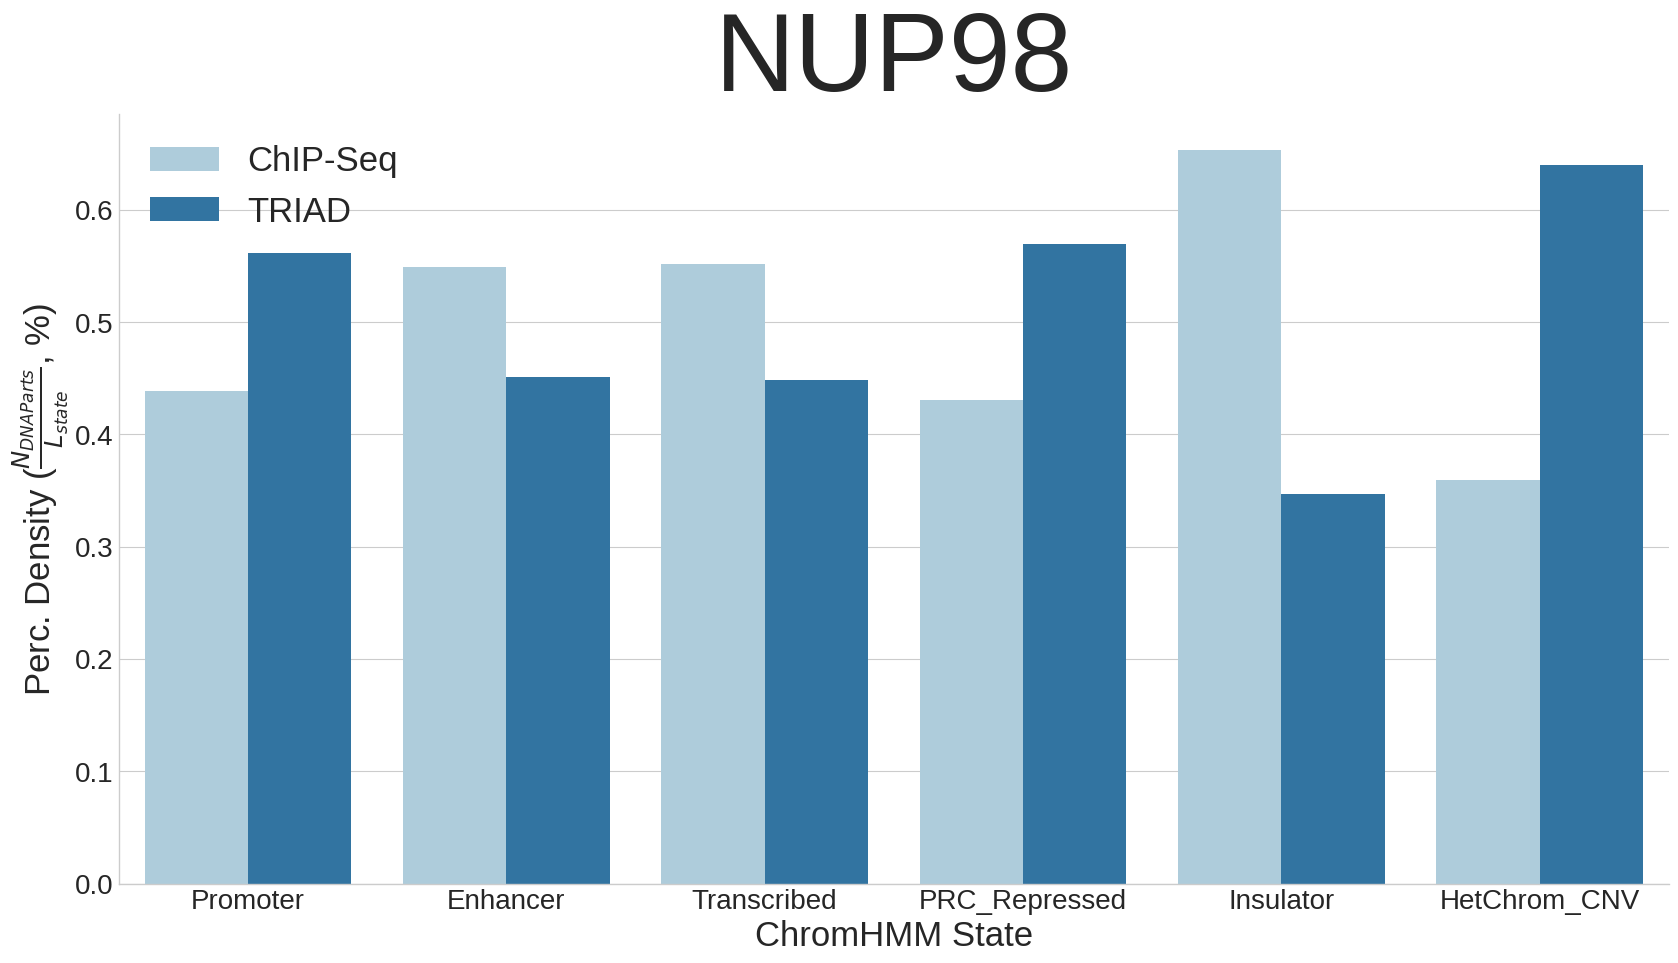

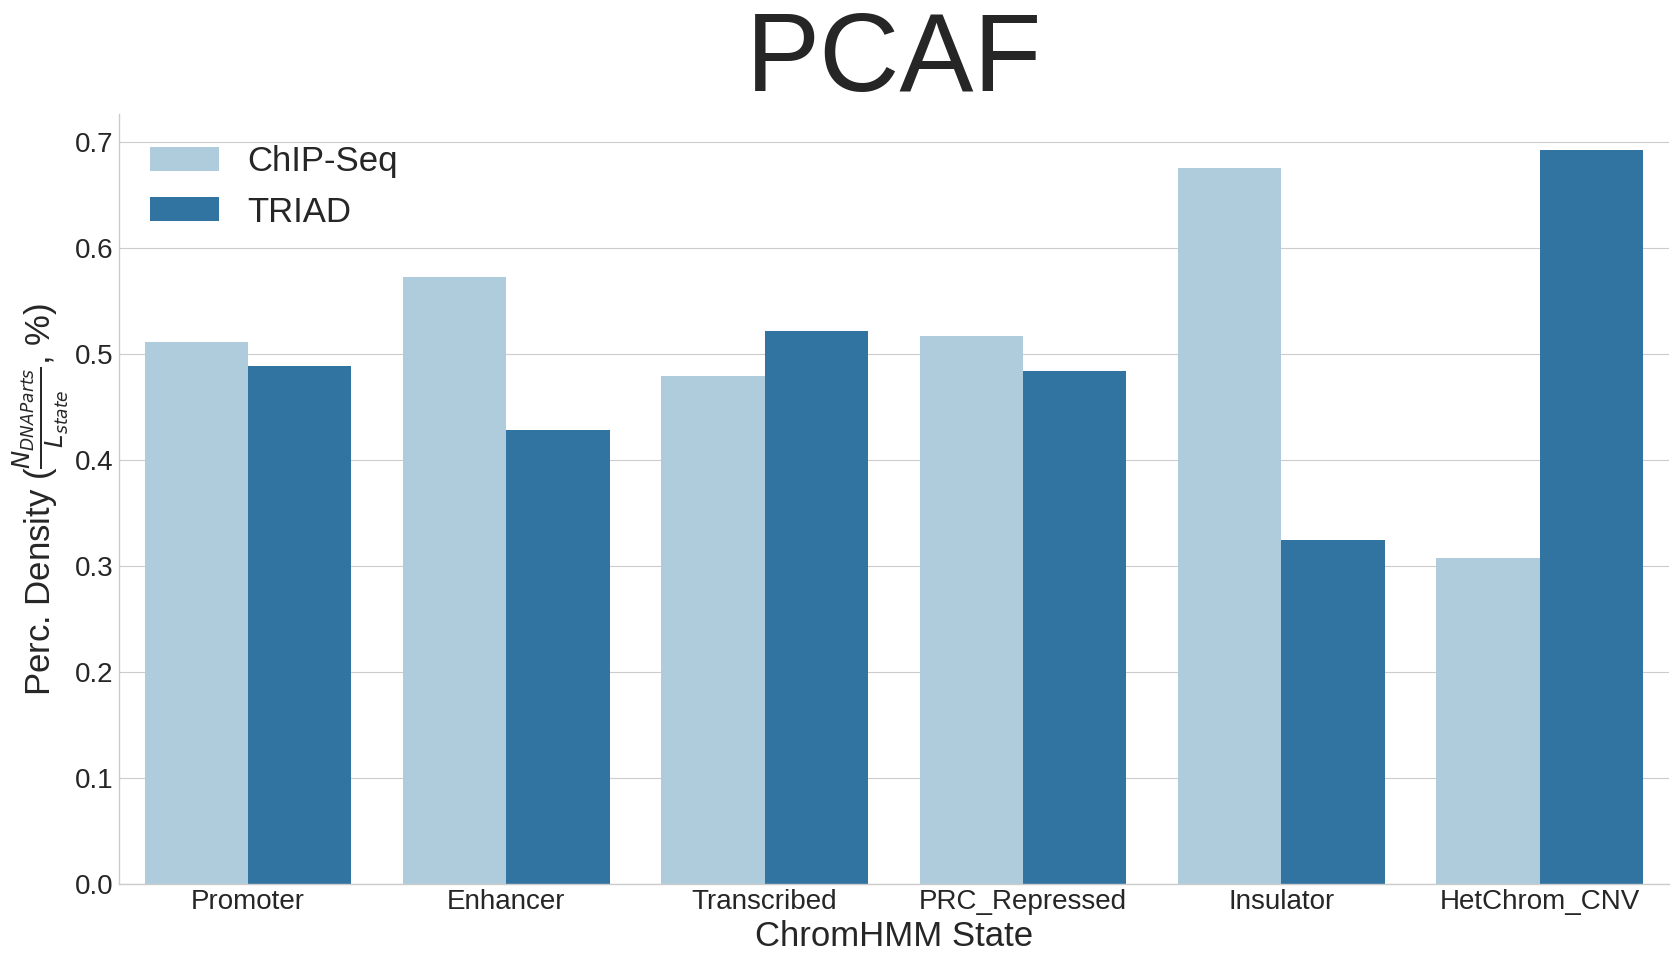

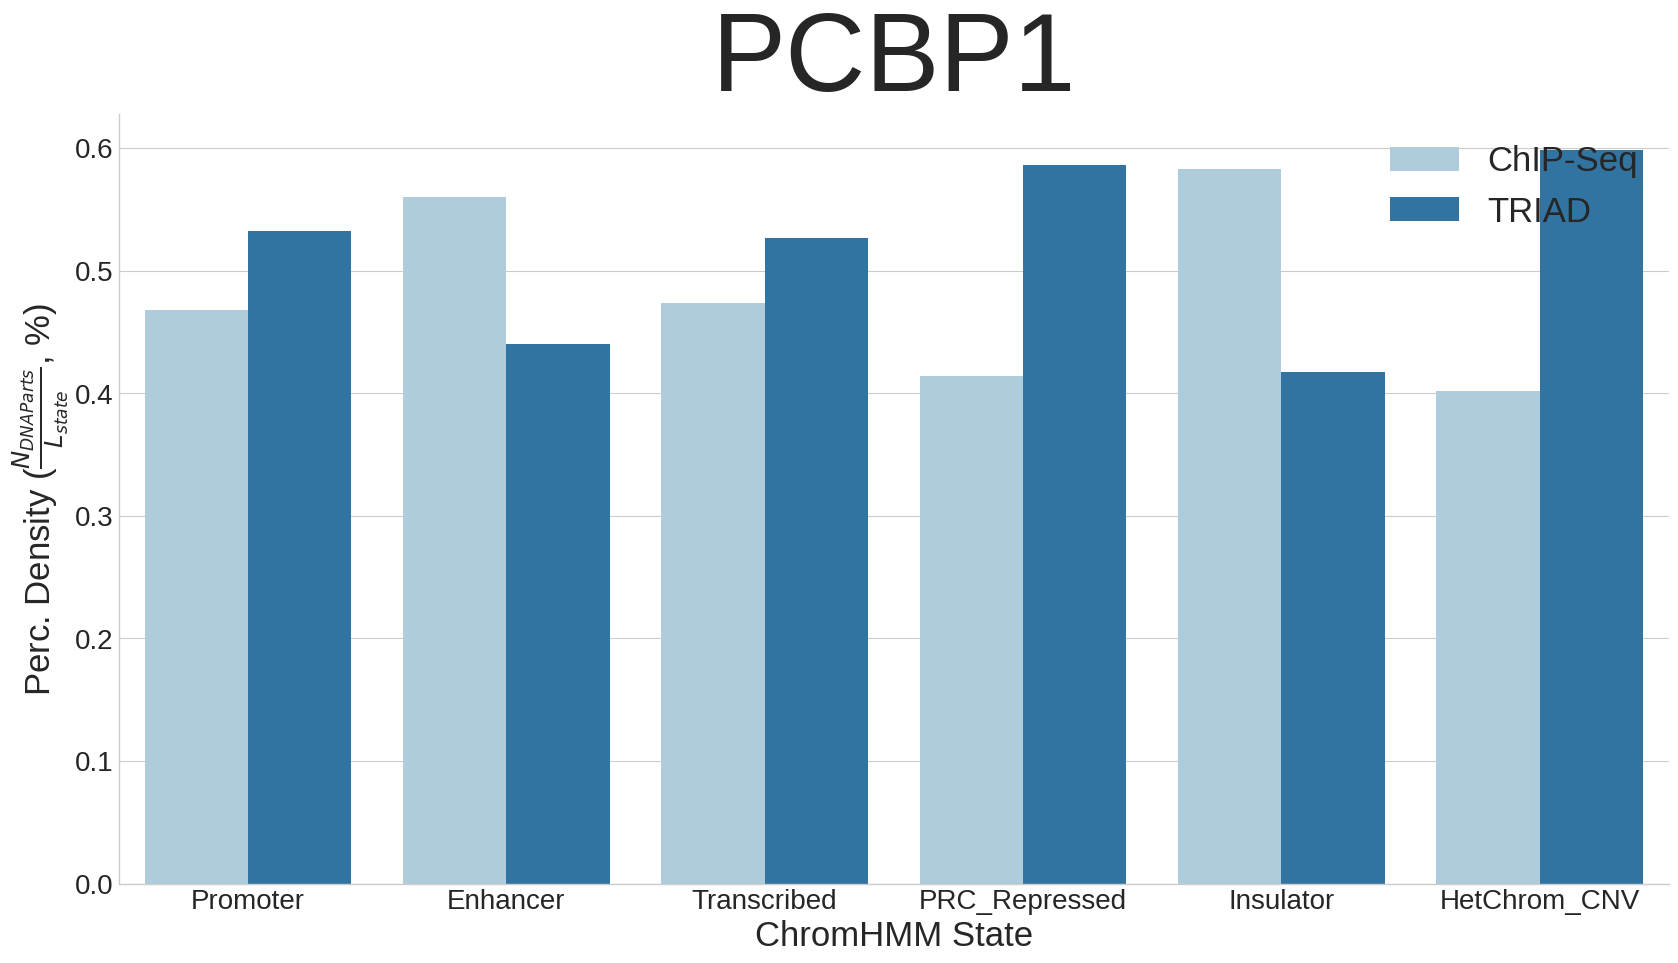

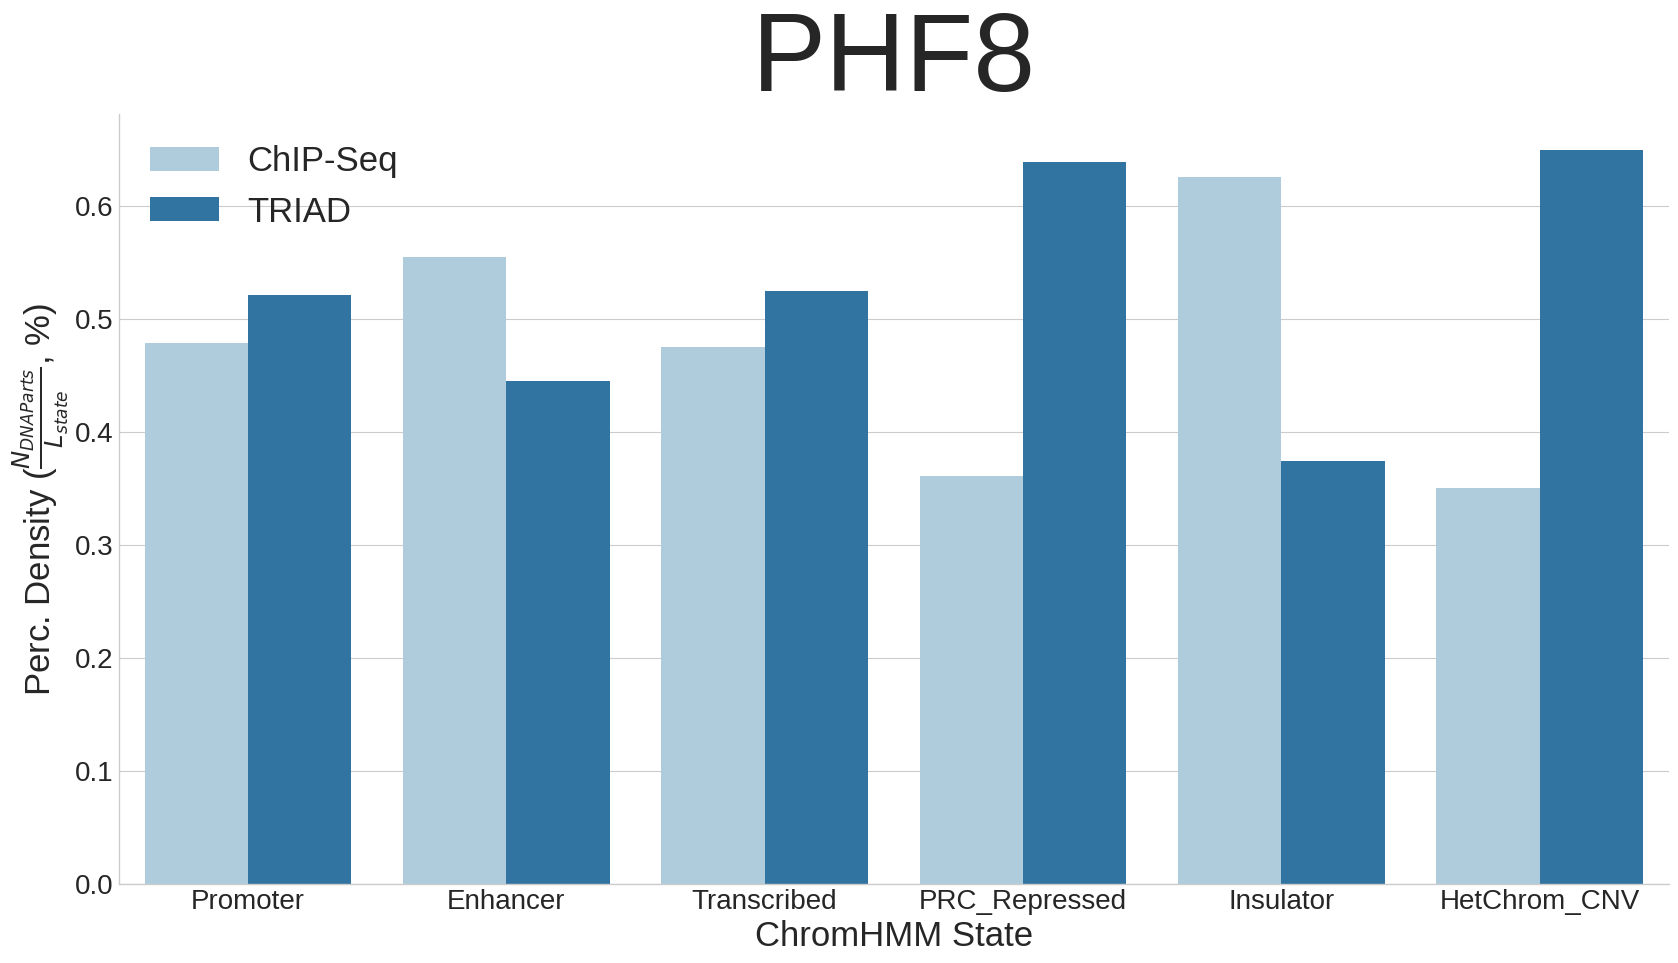

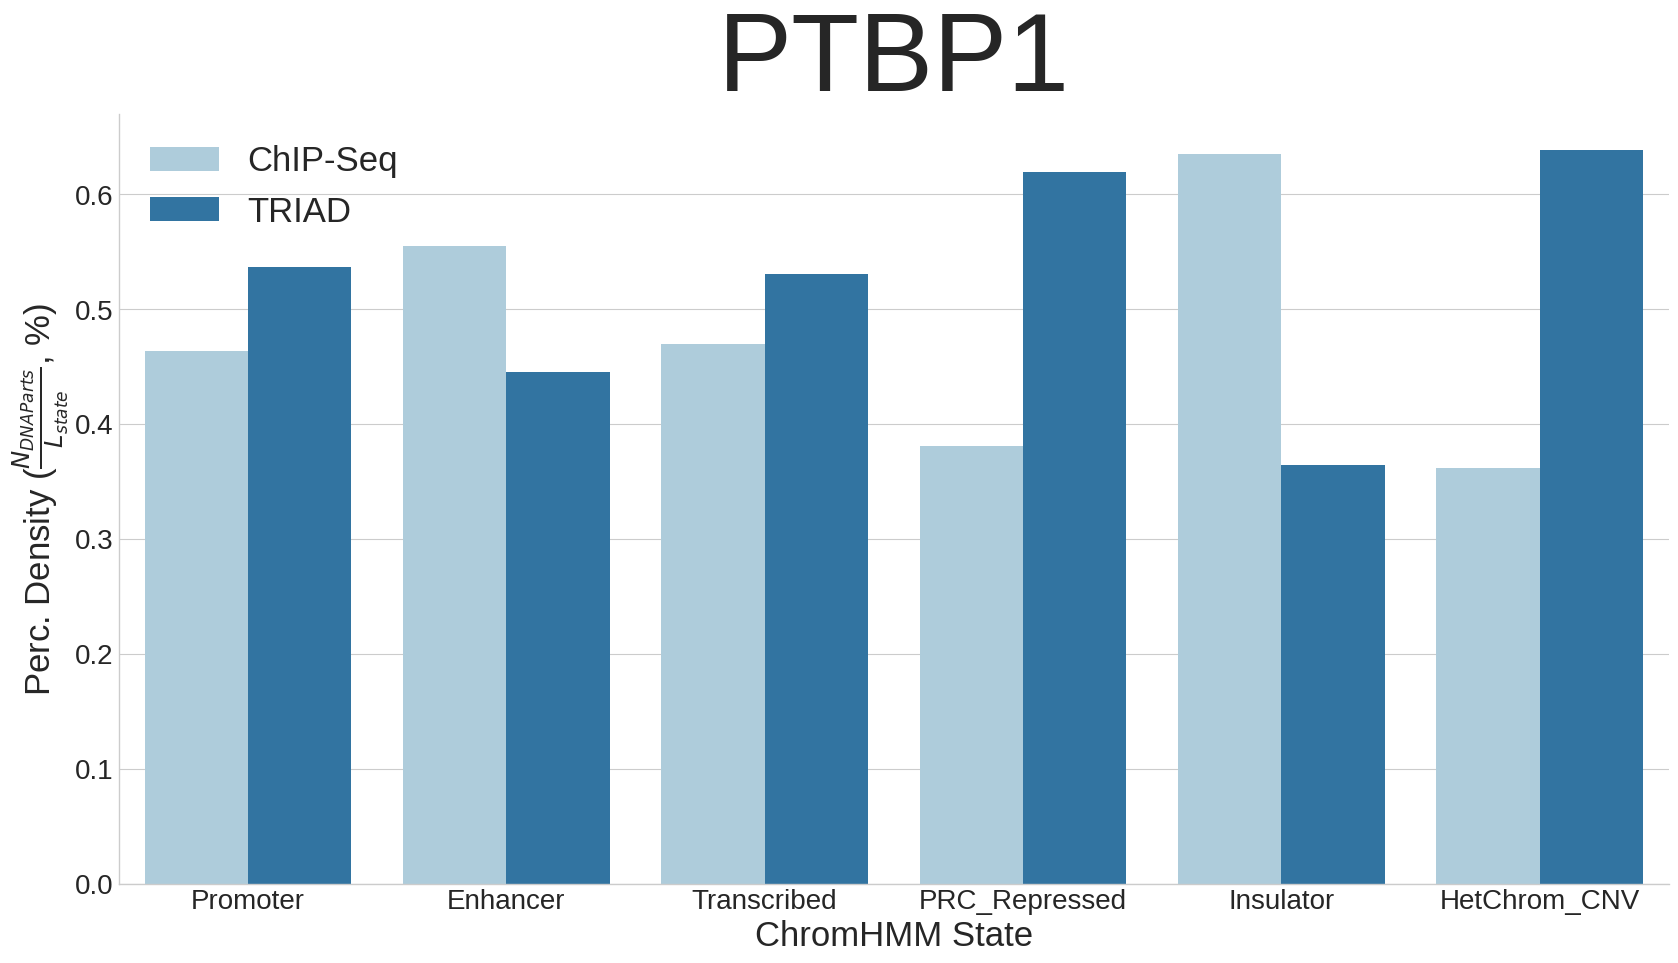

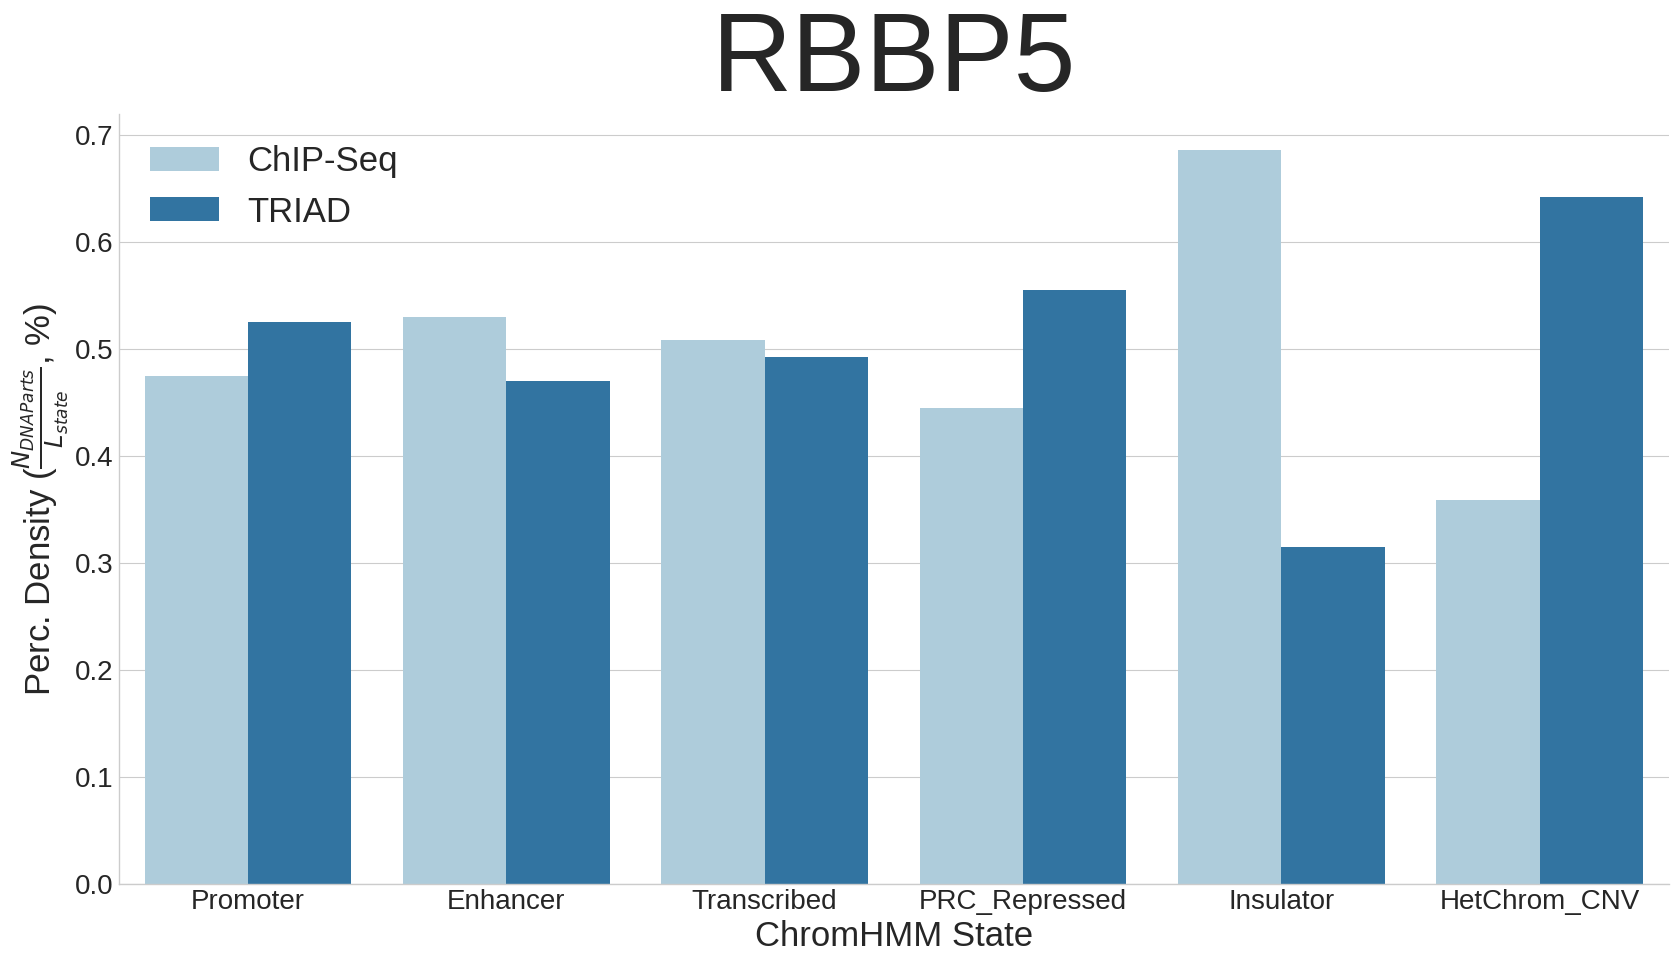

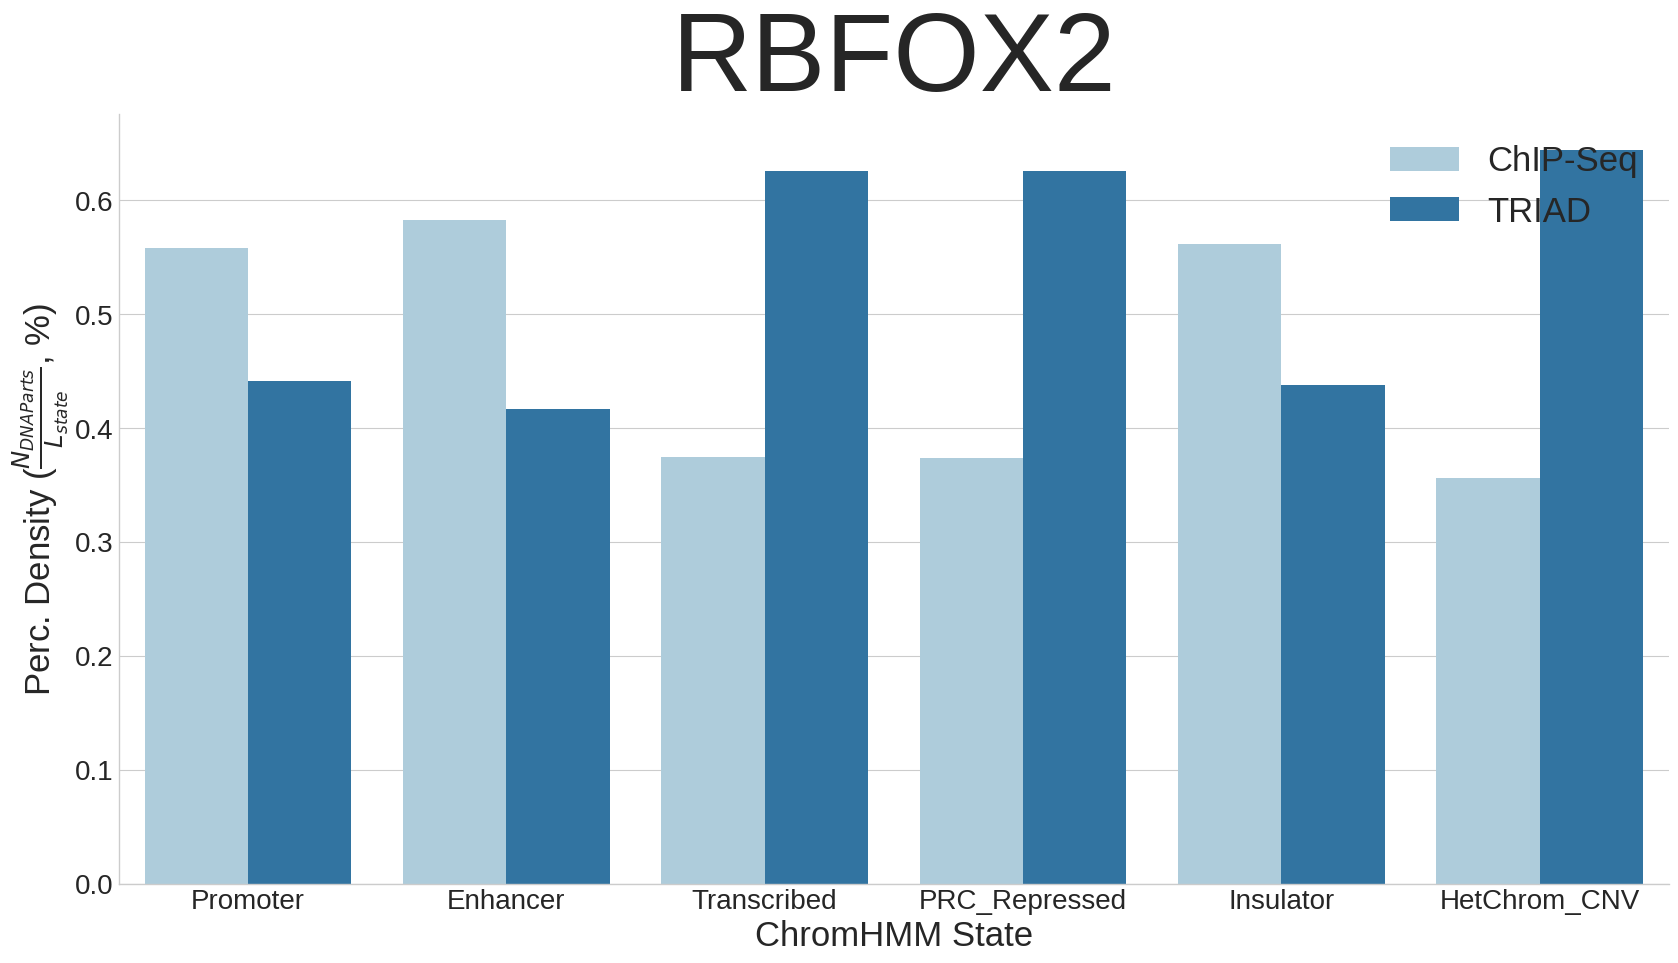

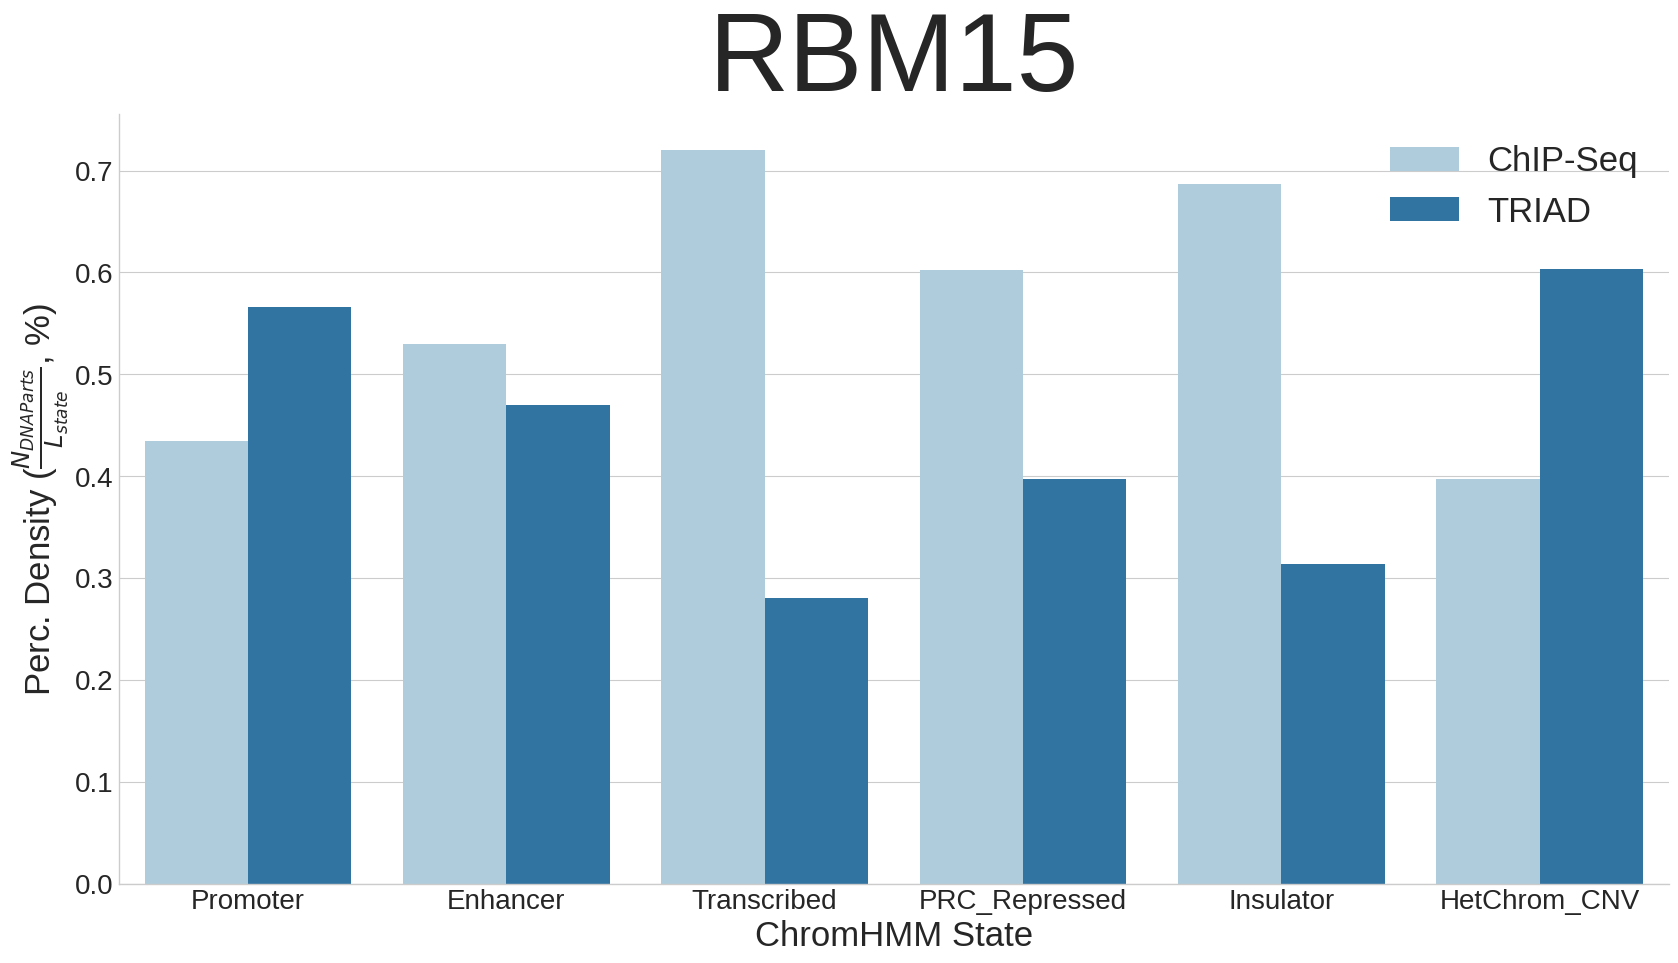

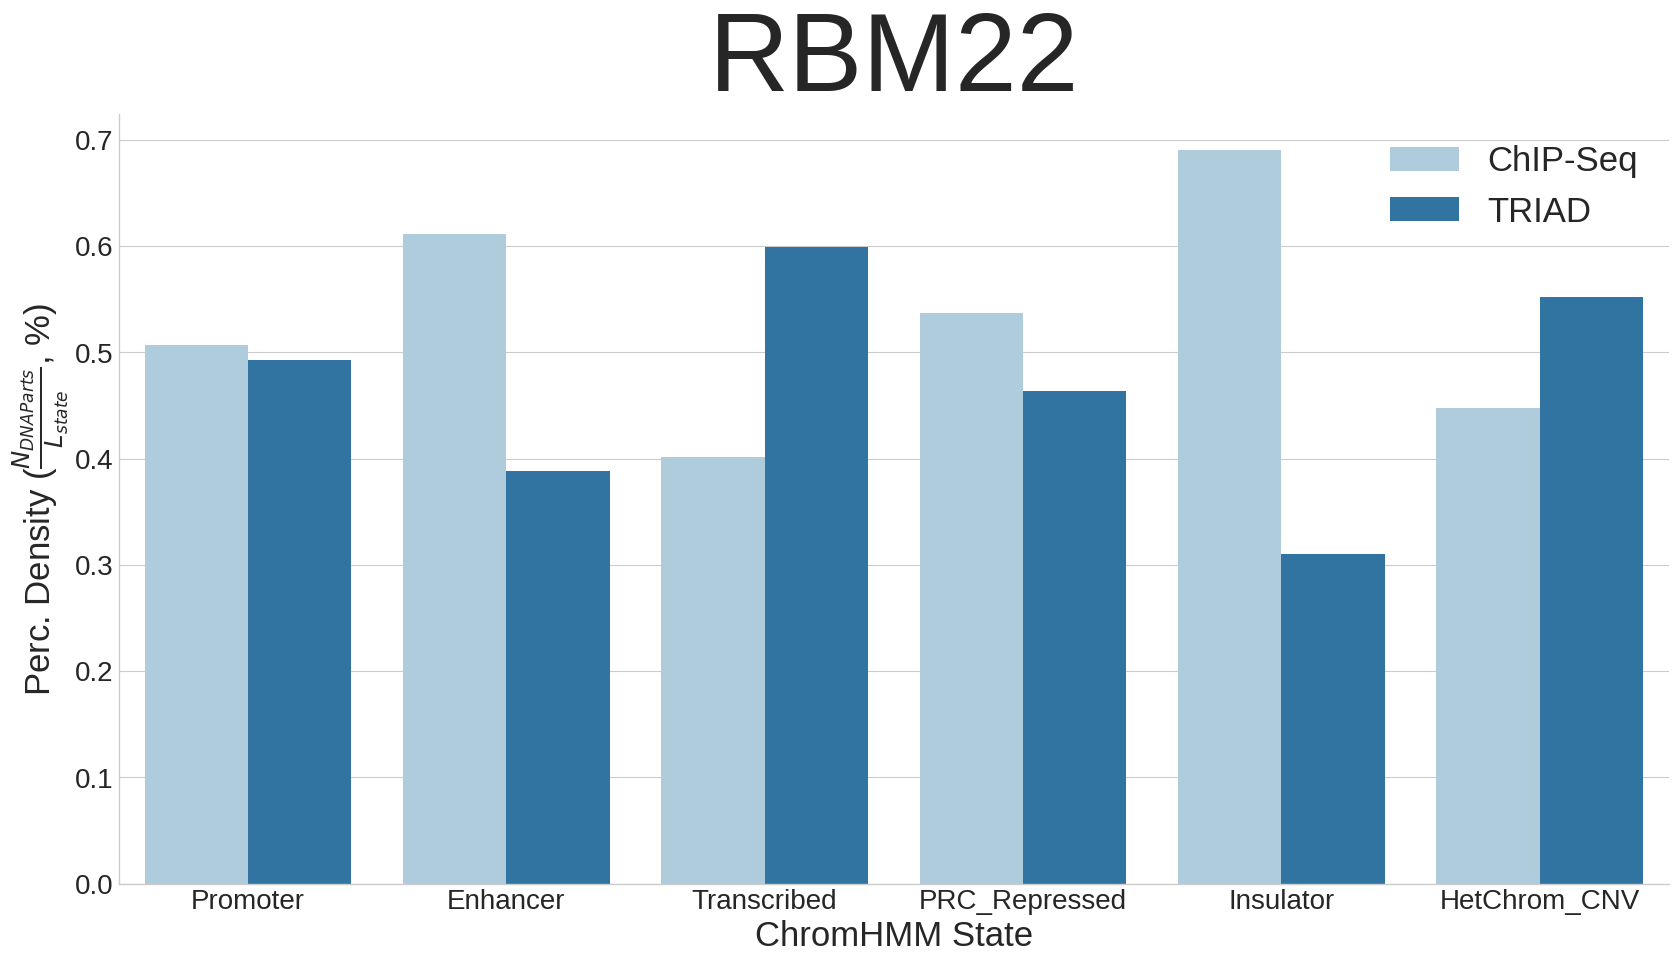

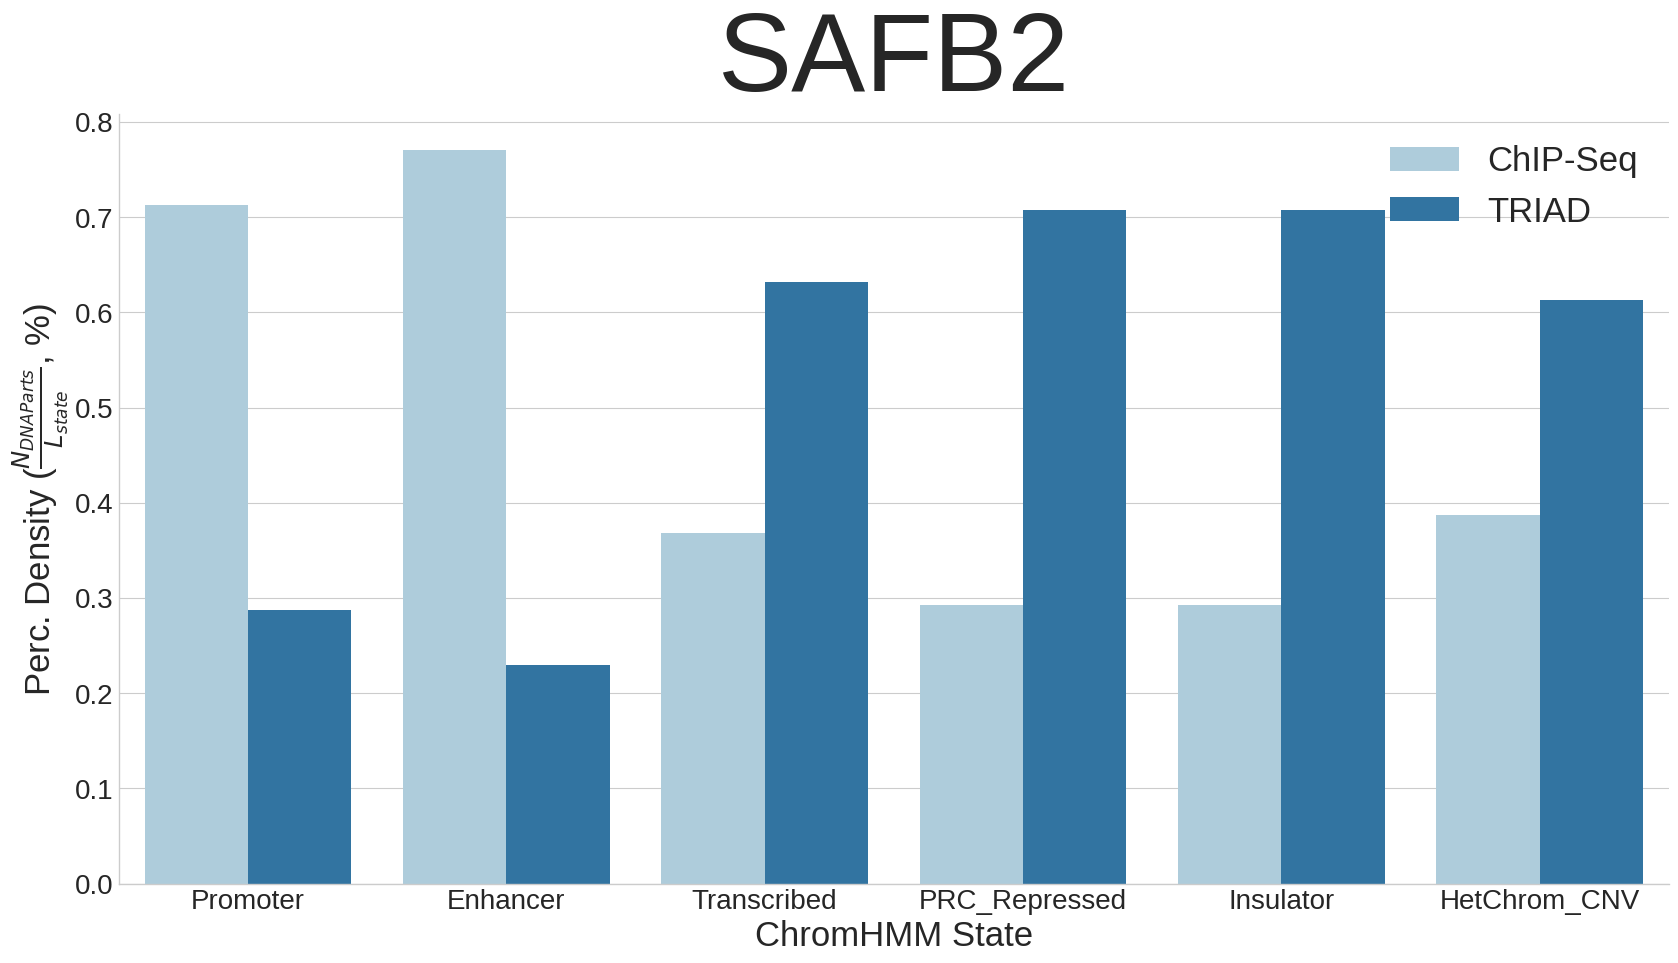

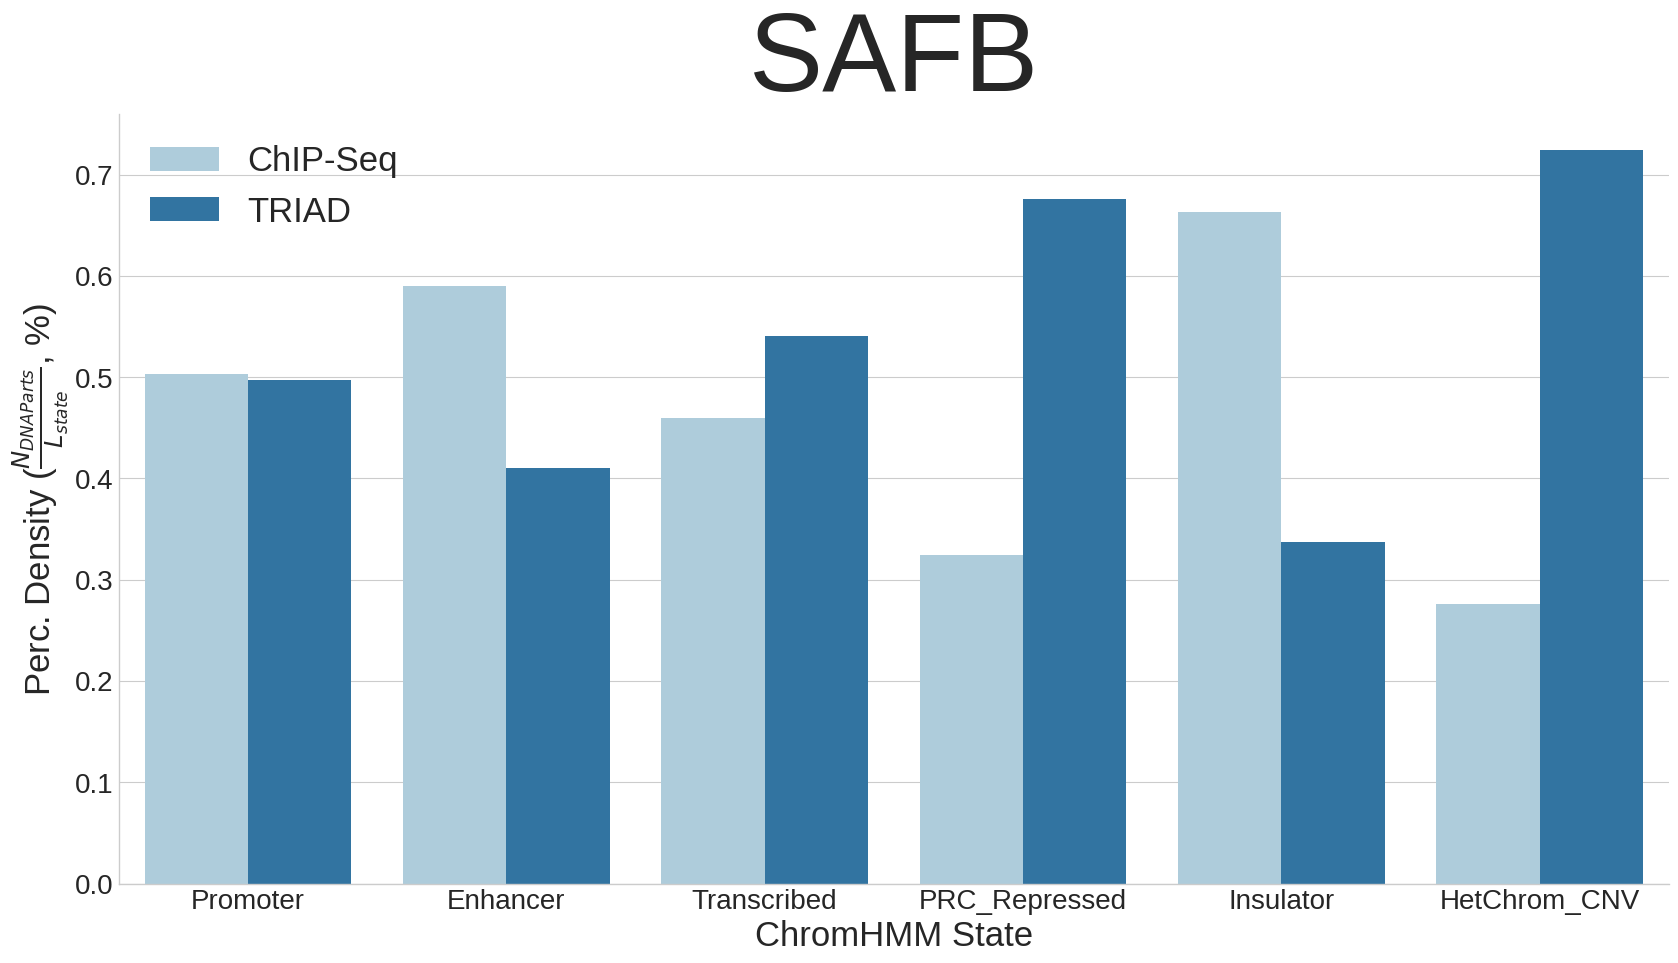

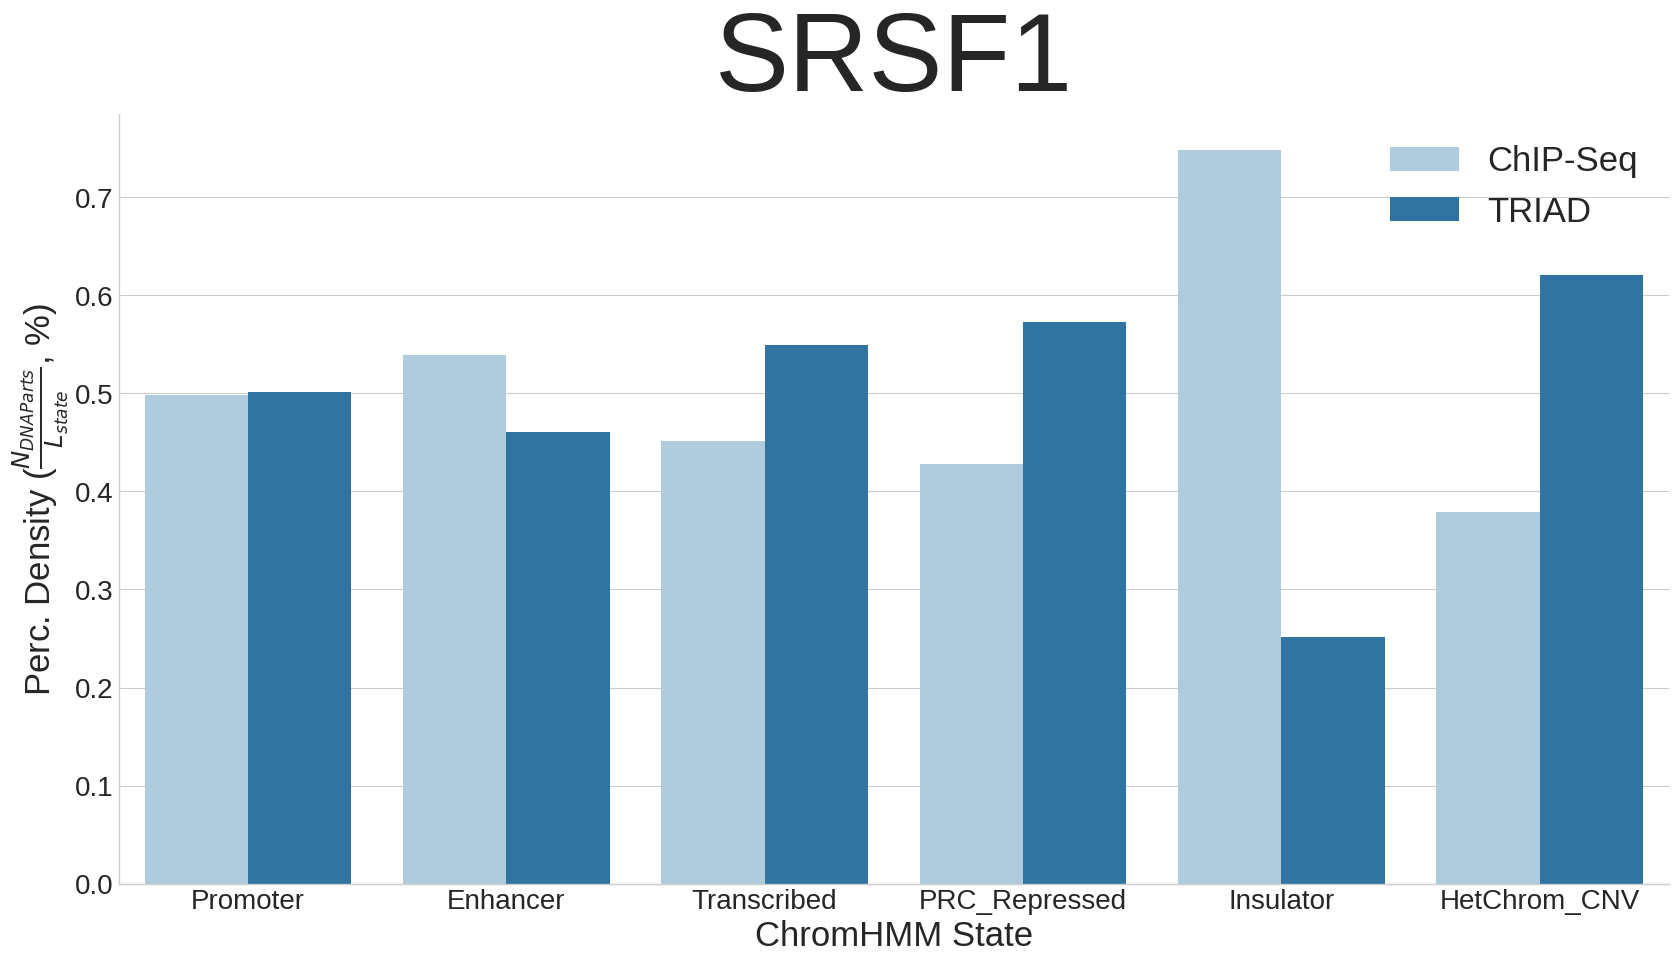

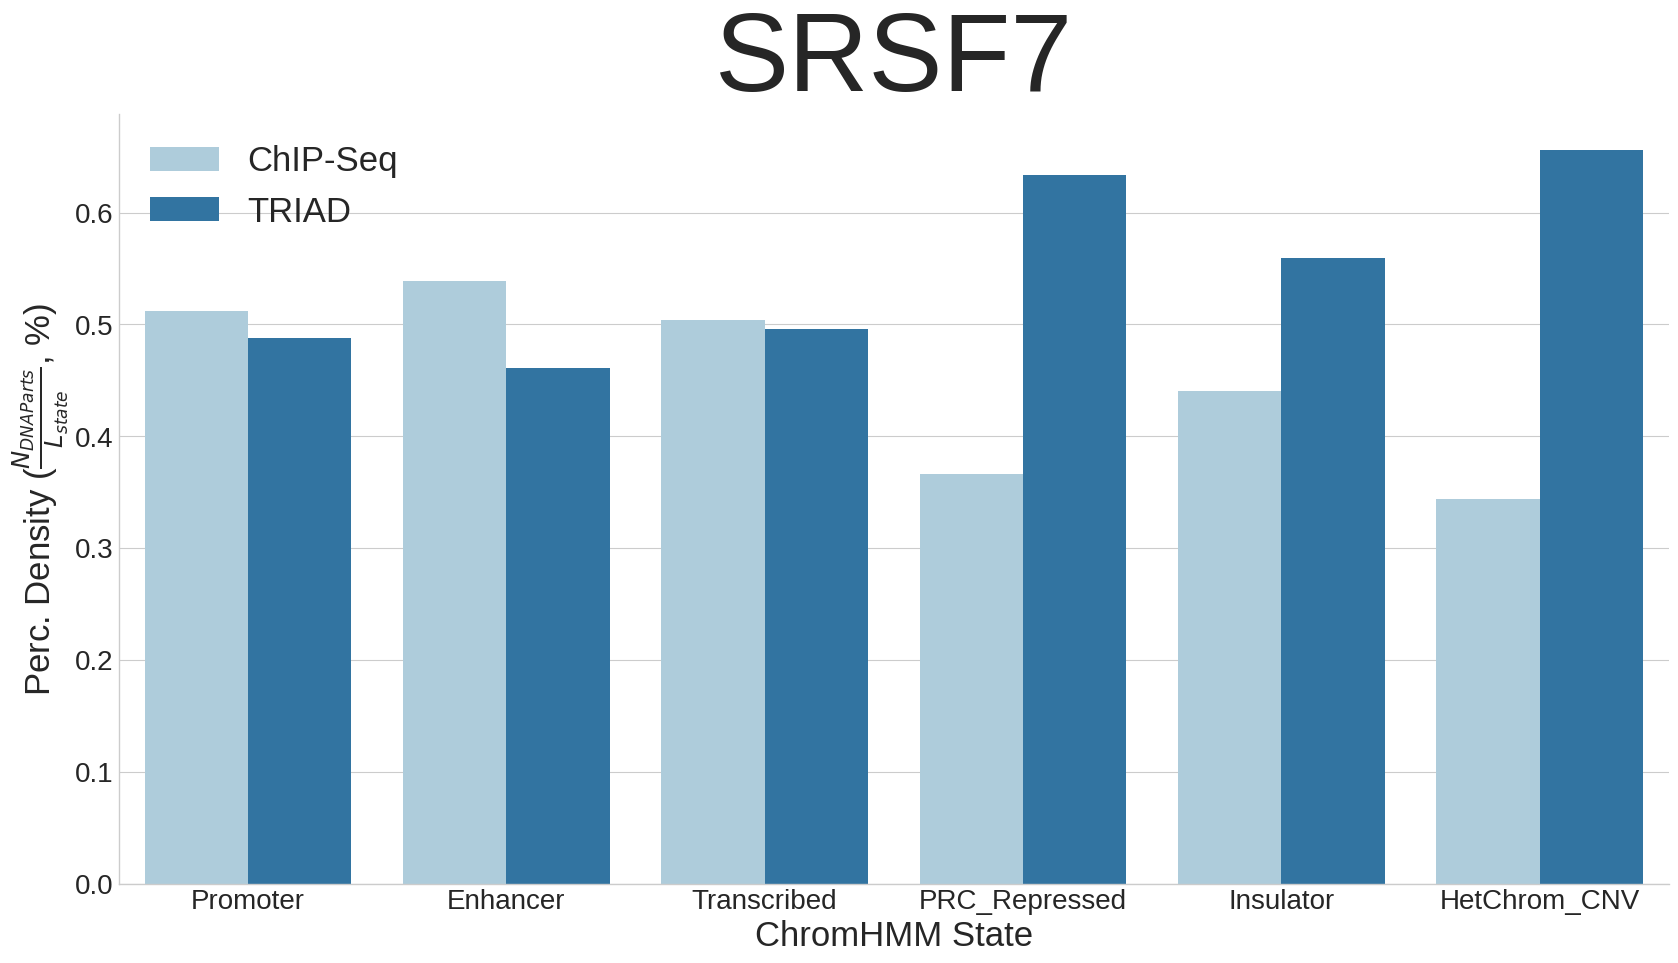

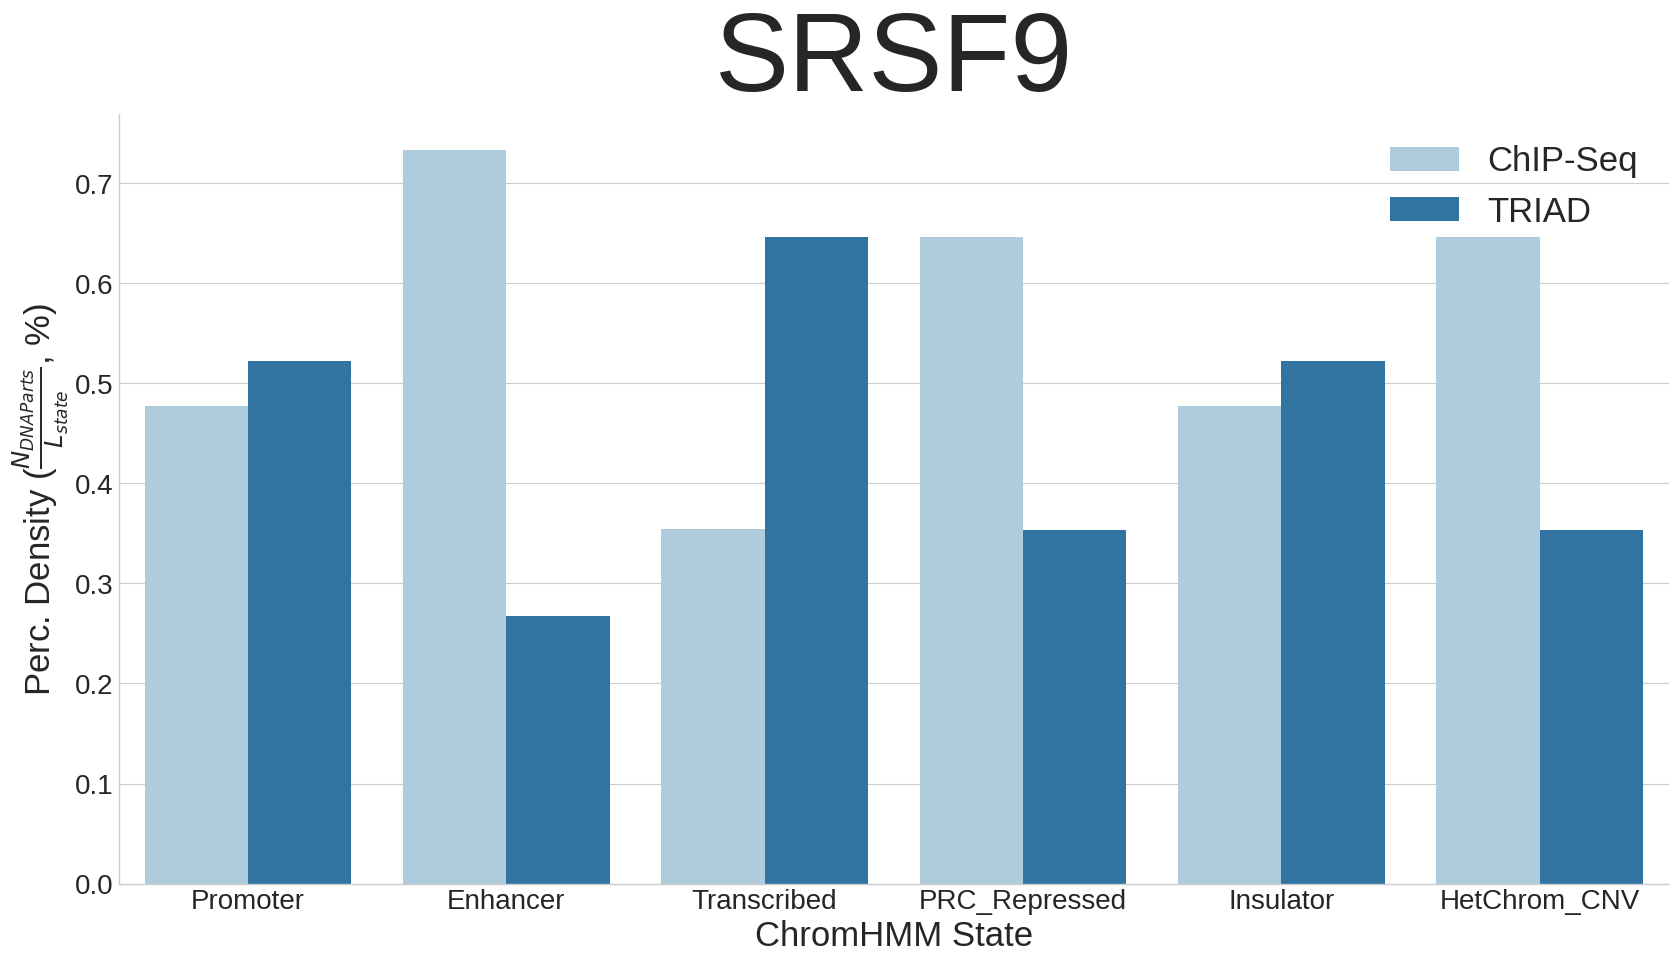

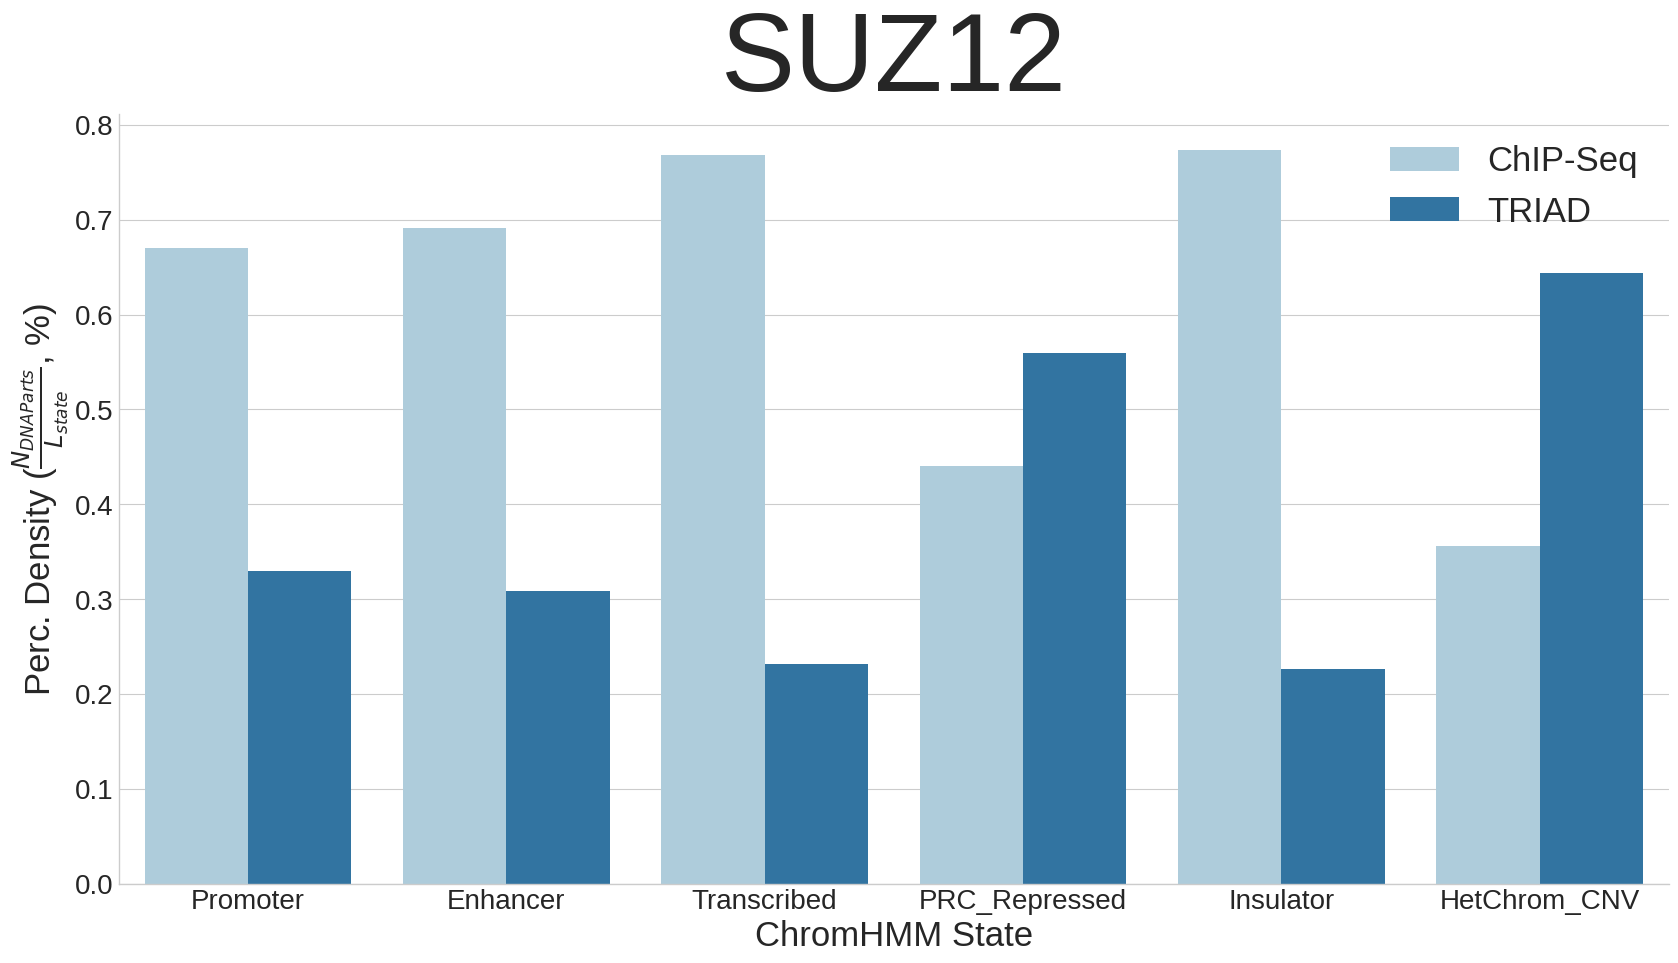

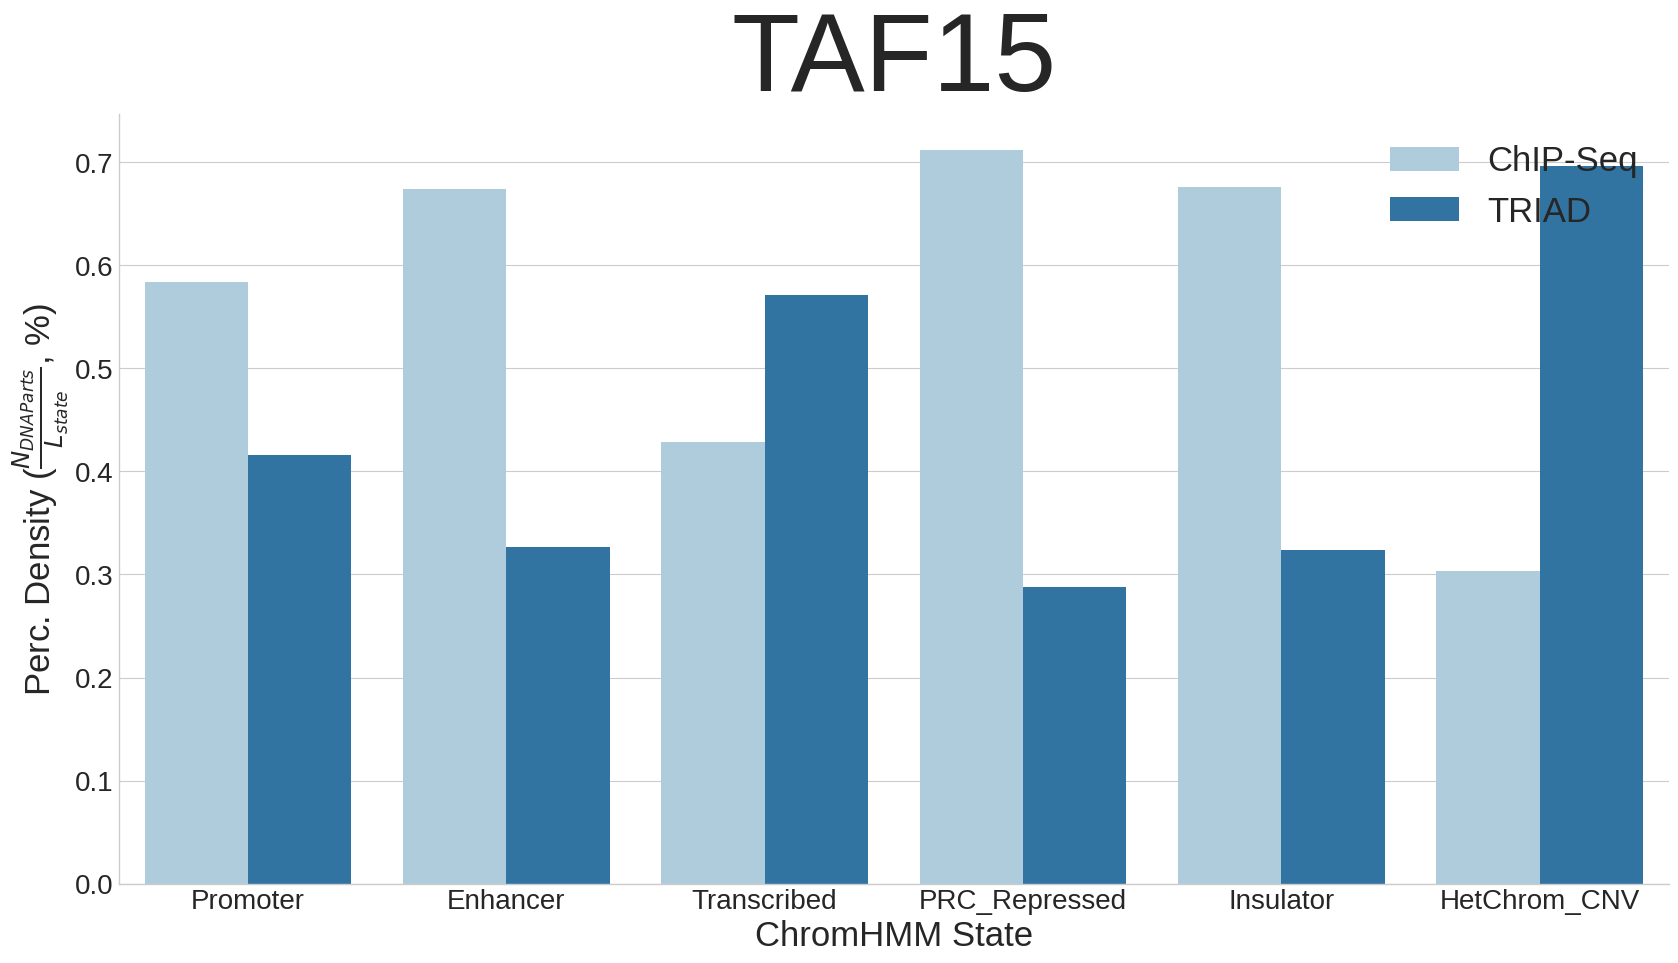

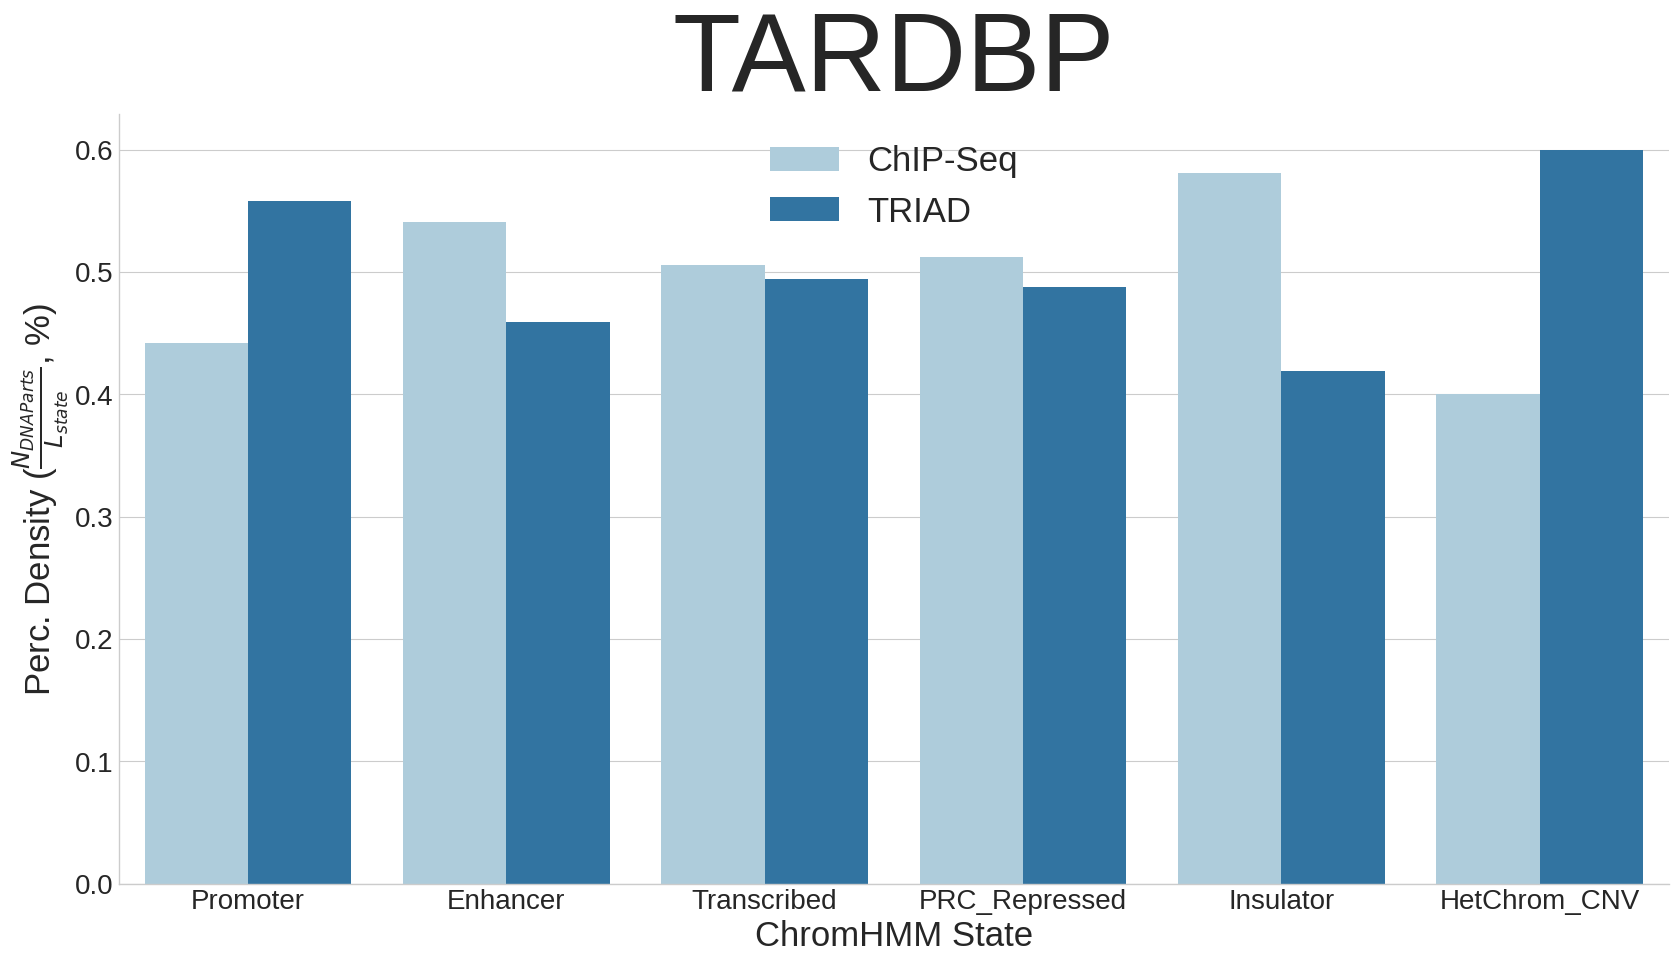

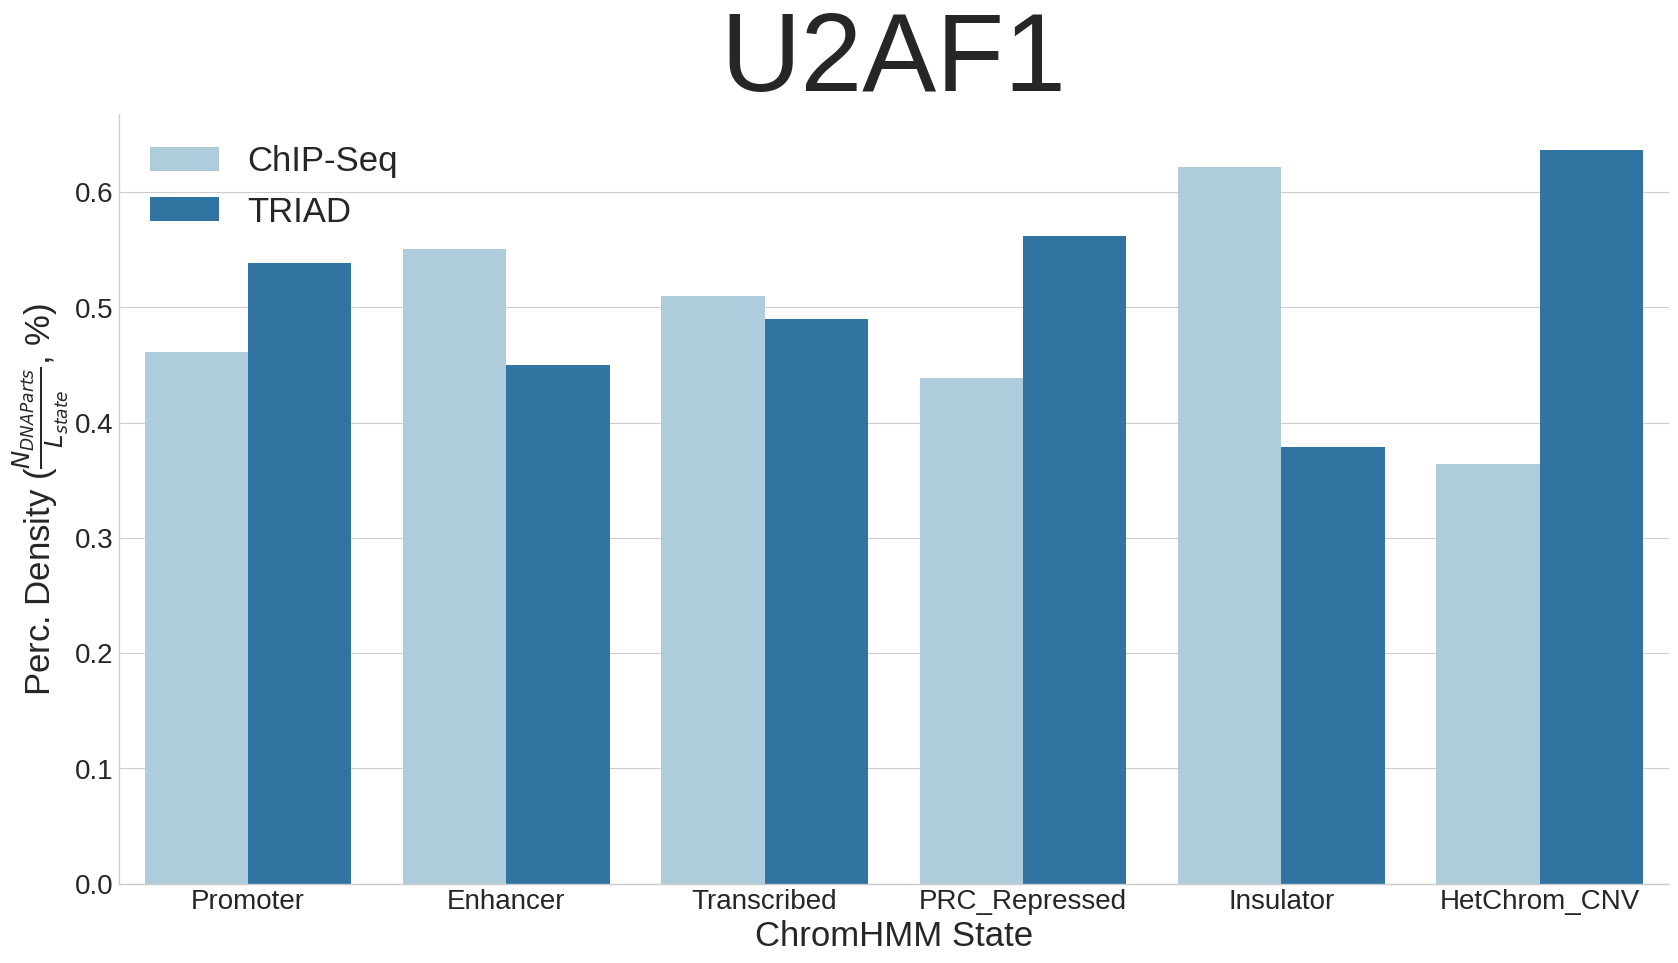

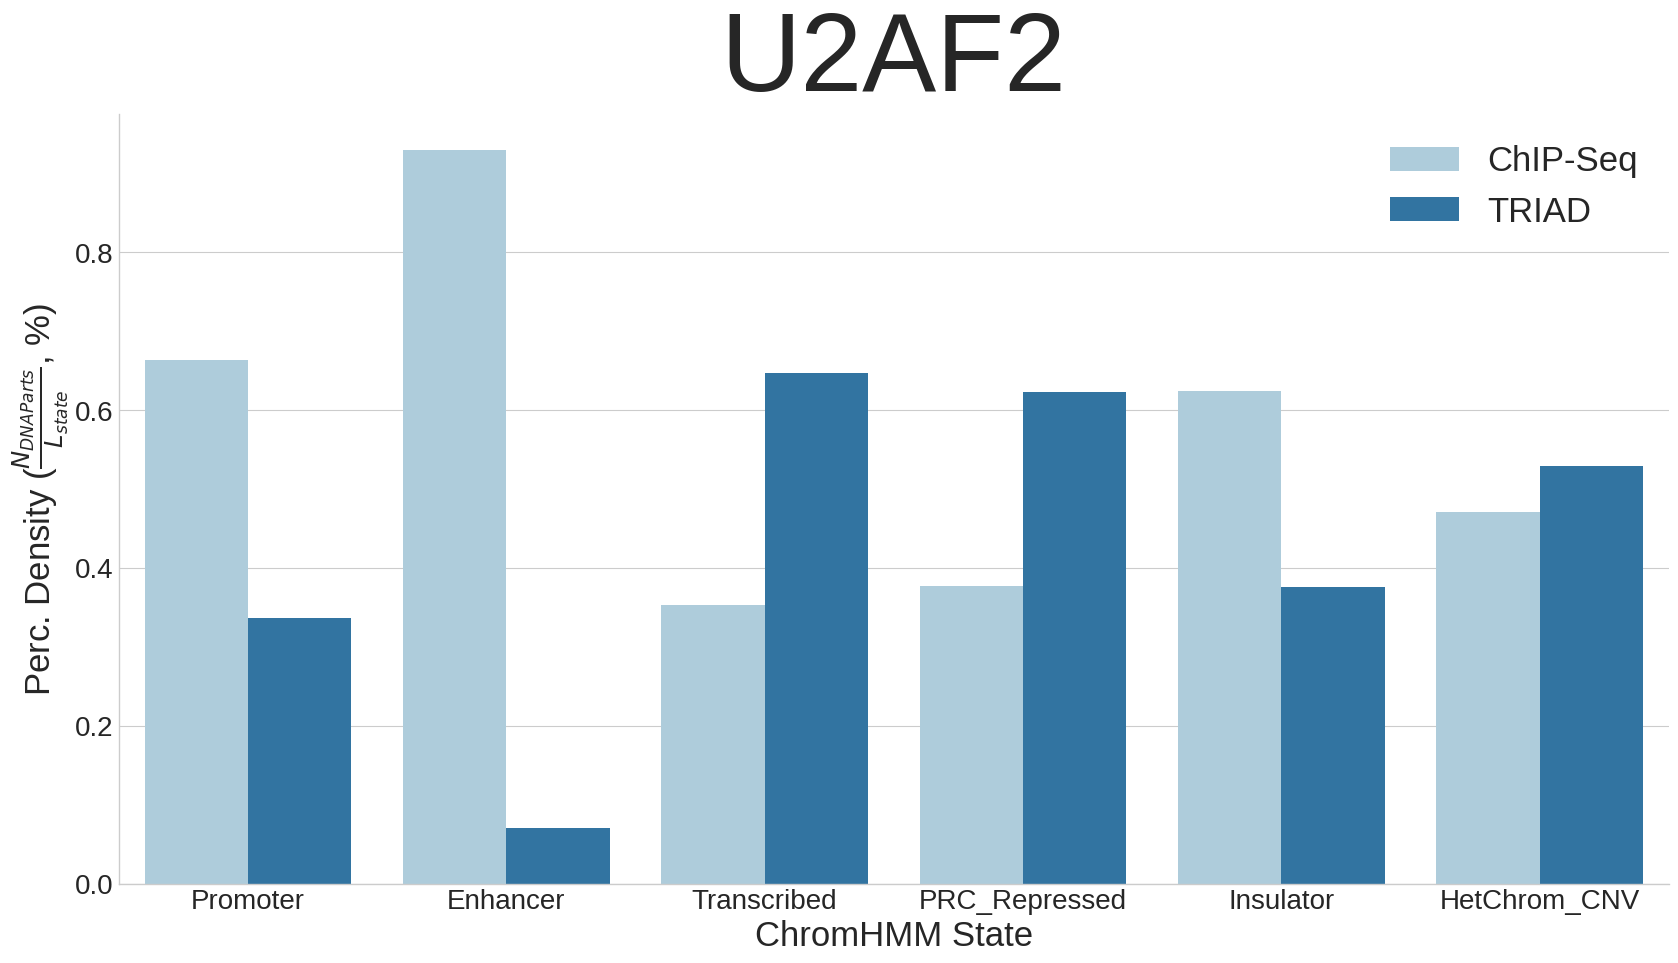

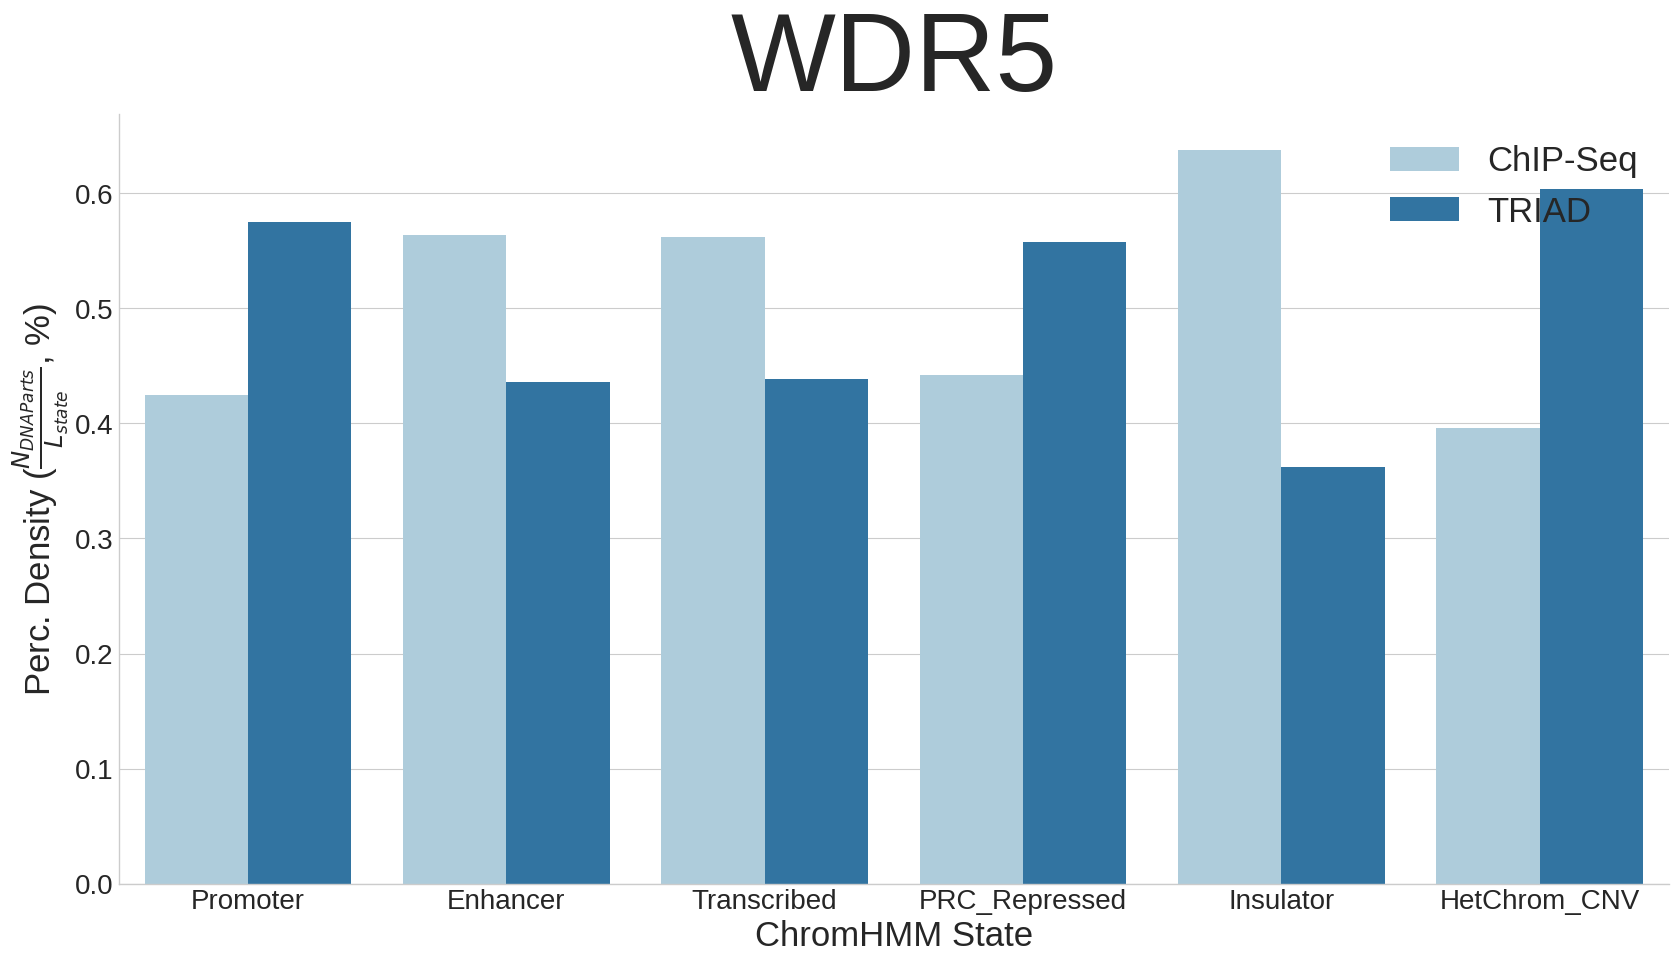

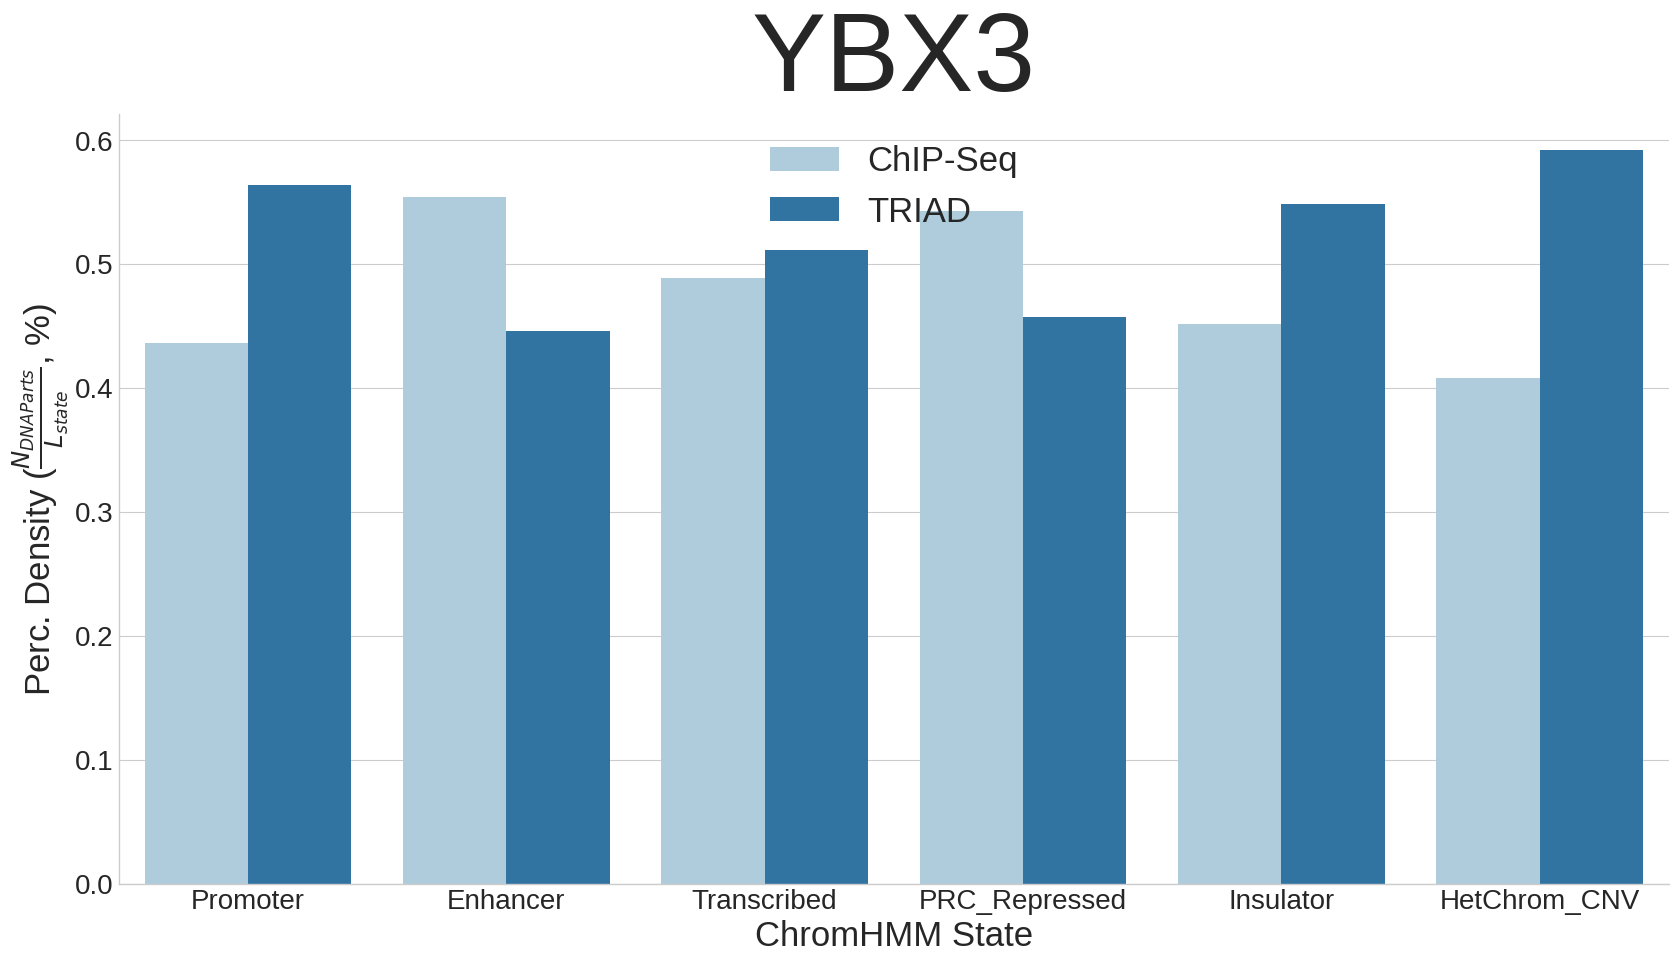

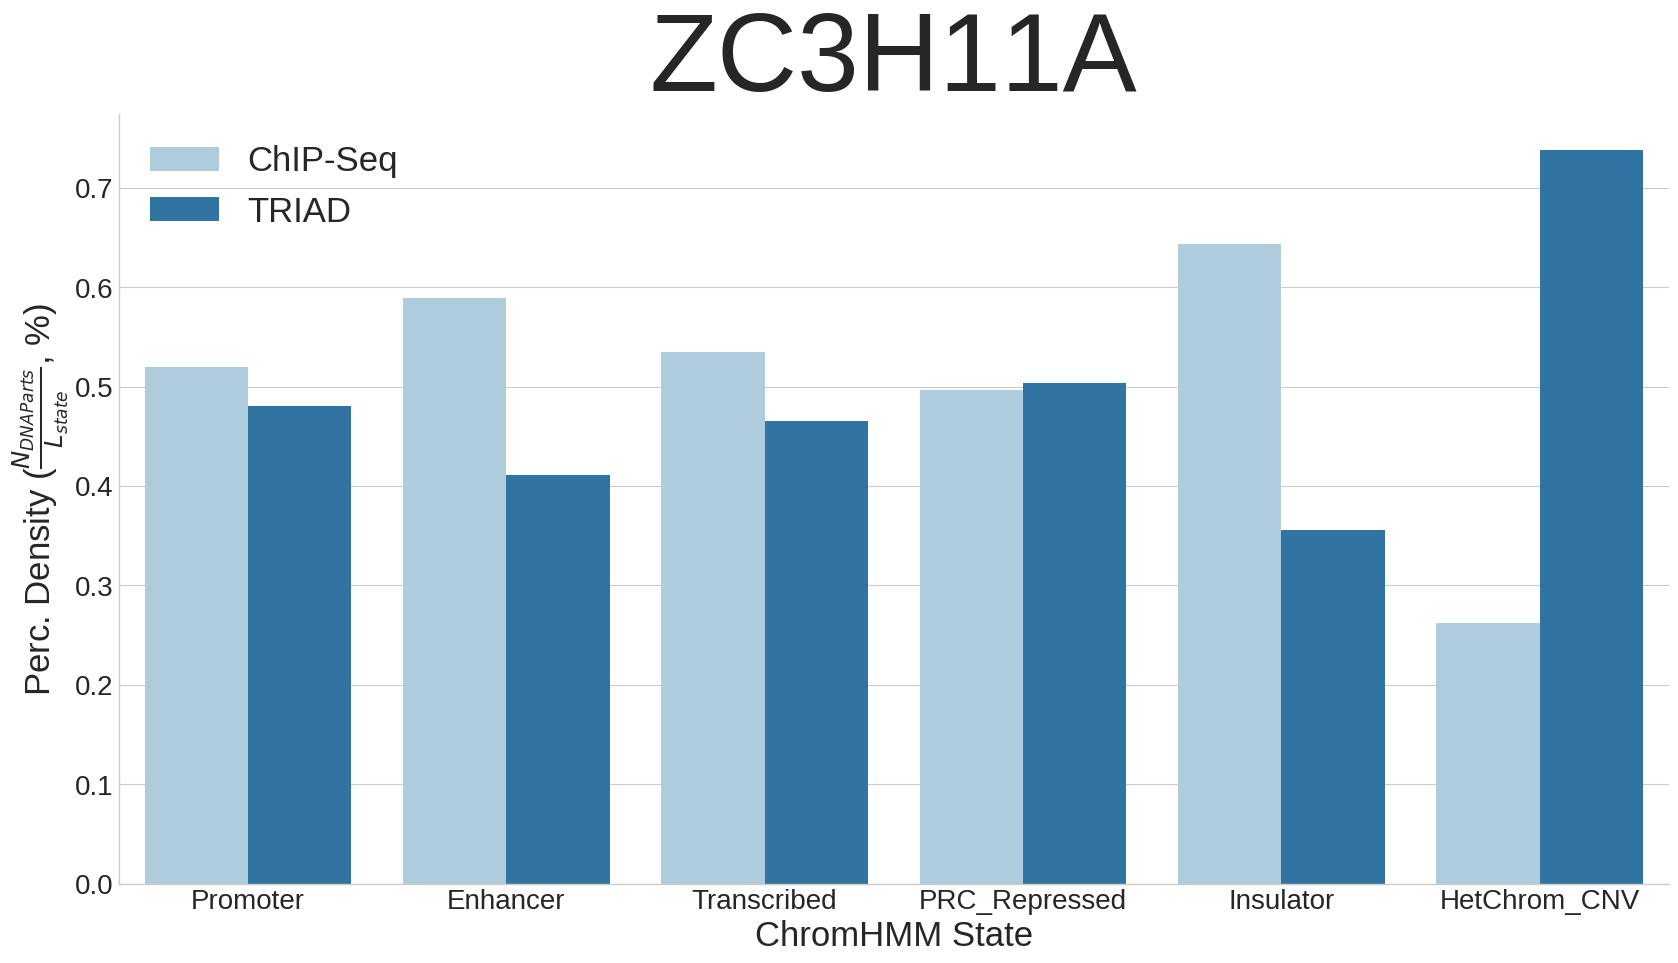

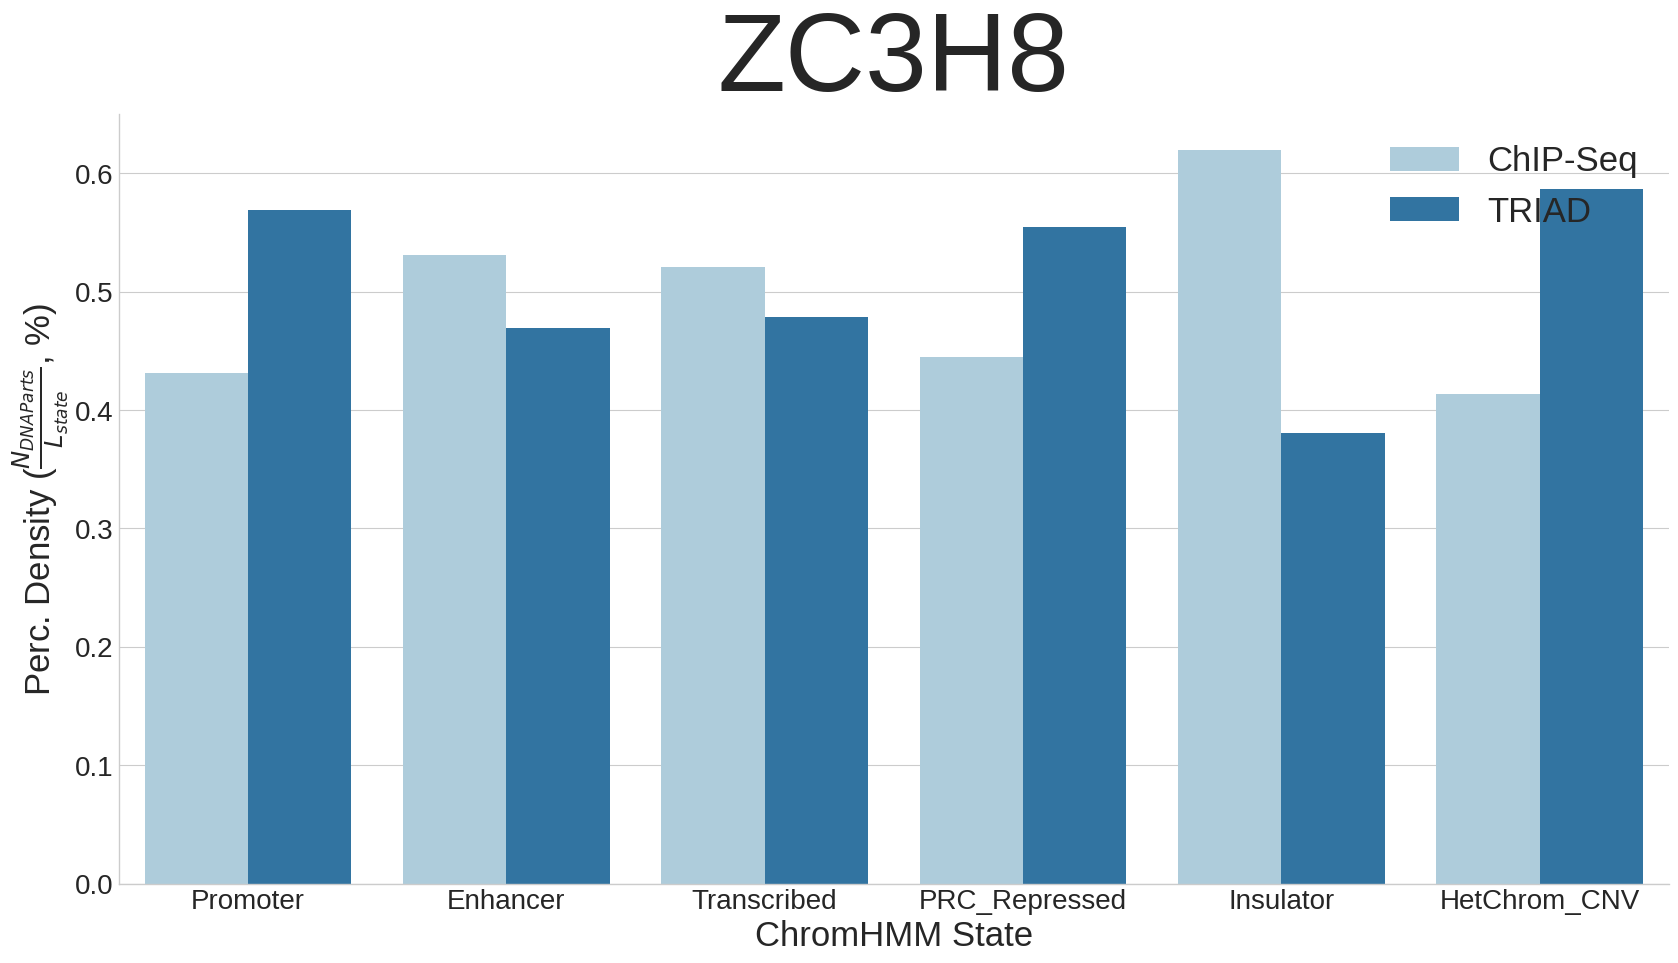

In [84]:
plt.rcParams["xtick.labelbottom"] = True
plt.style.use("seaborn-v0_8-whitegrid")

for i in ["top", "right"]:
    plt.rcParams[f"axes.spines.{i}"] = False

plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["figure.figsize"]=(20, 10)


for ind, PROTEIN in tqdm(enumerate(sorted(chip_df_norm.index.unique()))):
    prot = PROTEIN.split('_')[0]
    dt_new = {}
    tmp_dt = chip_df_norm[chip_df_norm.index.str.startswith(prot)].transpose().to_dict()
    triads_tmp = triad_df_norm[triad_df_norm.index.str.startswith(prot)].transpose().to_dict()
    for prot, states in sorted(list(tmp_dt.items())):
        for k, v in states.items():
            dt_new[("ChIP-Seq", k)] = v * 10_000_000
    for prot, states in sorted(list(triads_tmp.items())):
        for k, v in states.items():
            dt_new[("TRIAD", k)] = v * 10_000_000
    dt_new = [(a[0], a[1], b) for a,b in dt_new.items()]
    tmp = (pd.DataFrame(dt_new, columns=["Dataset", "ChromHMM_State", "Density"])
          .pivot(index="Dataset", columns="ChromHMM_State", values="Density"))
    tmp = (tmp
           .div(tmp.sum(axis=0)).reset_index()
           .melt(id_vars=["Dataset"], value_vars=["Promoter", "Enhancer", "Transcribed",
                    "PRC_Repressed", "Insulator", "HetChrom_CNV"], value_name="Density"))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xticklabels(["Promoter", "Enhancer", "Transcribed",
                        "PRC_Repressed", "Insulator", "HetChrom_CNV"], fontsize=20)
    plt.title(f"{PROTEIN.split('_')[0]}", fontsize=80)
    sns.barplot(x = "ChromHMM_State", y = "Density", hue="Dataset", data=tmp, palette="Paired")
    plt.xlabel("ChromHMM State", fontsize=25)
    plt.ylabel("Perc. Density ($\\frac{N_{DNA Parts}}{L_{state}}$, %)", fontsize=25)
    plt.legend(fontsize=25)
    plt.savefig(f"pictures_barplots/{PROTEIN.split('_')[0]}.png", transparent=True)